# Exporatory Analysis

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
X_test = pd.read_csv("tanzanian_water_wells/X_test.csv")
X_train = pd.read_csv("tanzanian_water_wells/X_train.csv")
y_train = pd.read_csv("tanzanian_water_wells/y_train.csv")

df = pd.concat([X_train, y_train], axis=1)

In [3]:
desc = {'amount_tsh': 'Total static head (amount water available to waterpoint)',
                    'date_recorded': 'The date the row was entered',
                    'funder': 'Who funded the well',
                    'gps_height': 'Altitude of the well',
                    'installer': 'Organization that installed the well',
                    'longitude': 'GPS coordinate',
                    'latitude': 'GPS coordinate',
                    'wpt_name': 'Name of the waterpoint if there is one',
                    'subvillage': 'Geographic location',
                    'region': 'Geographic location',
                    'region_code': 'Geographic location (coded)',
                    'district_code': 'Geographic location (coded)',
                    'lga': 'Geographic location',
                    'ward': 'Geographic location',
                    'population': 'Population around the well',
                    'public_meeting': 'True/False',
                    'recorded_by': 'Group entering this row of data',
                    'scheme_management': 'Who operates the waterpoint',
                    'scheme_name': 'Who operates the waterpoint',
                    'permit': 'If the waterpoint is permitted',
                    'construction_year': 'Year the waterpoint was constructed',
                    'extraction_type': 'The kind of extraction the waterpoint uses',
                    'extraction_type_group': 'The kind of extraction the waterpoint uses',
                    'extraction_type_class': 'The kind of extraction the waterpoint uses',
                    'management': 'How the waterpoint is managed',
                    'management_group': 'How the waterpoint is managed',
                    'payment': 'What the water costs',
                    'payment_type': 'What the water costs',
                    'water_quality': 'The quality of the water',
                    'quality_group': 'The quality of the water',
                    'quantity': 'The quantity of water',
                    'quantity_group': 'The quantity of water',
                    'source': 'The source of the water',
                    'source_type': 'The source of the water',
                    'source_class': 'The source of the water',
                    'waterpoint_type': 'The kind of waterpoint',
                    'waterpoint_type_group': 'The kind of waterpoint'}

In [4]:
# Eliminating null values

df.funder.fillna("Unknown", inplace=True)
df.installer.fillna("Unknown", inplace=True)
df.scheme_management.fillna("None", inplace=True)
df.permit.fillna('Unknown', inplace=True)
df.scheme_name.fillna('Unknown', inplace=True)
df.subvillage.fillna('Unknown', inplace=True)
df.public_meeting.fillna('Unknown', inplace=True)

In [97]:
# df['fundernum'] = df['funder'].map(df.funder.value_counts())

# df['funder_installer'] = df['funder'] == df['installer']
# df['funder_installer'] = df['funder_installer'].astype('int')

# df['permit'] = df['permit'].map({True: 1, False: 0, 'Unknown': 2})

df['status_id'] = df['status_group'].map({'non functional': 0, 'functional needs repair': 1, 'functional': 2})

# Amount_Tsh: Total static head (amount water available to waterpoint)

This variable seems to be positively correlated with the target variable, status_group. Looking at the right scatterplot reveals a very linear connection between the two variables. This seems to be a promising candidate for the models.

In [6]:
df.amount_tsh

0        6000.0
1           0.0
2          25.0
3           0.0
4           0.0
          ...  
59395      10.0
59396    4700.0
59397       0.0
59398       0.0
59399       0.0
Name: amount_tsh, Length: 59400, dtype: float64

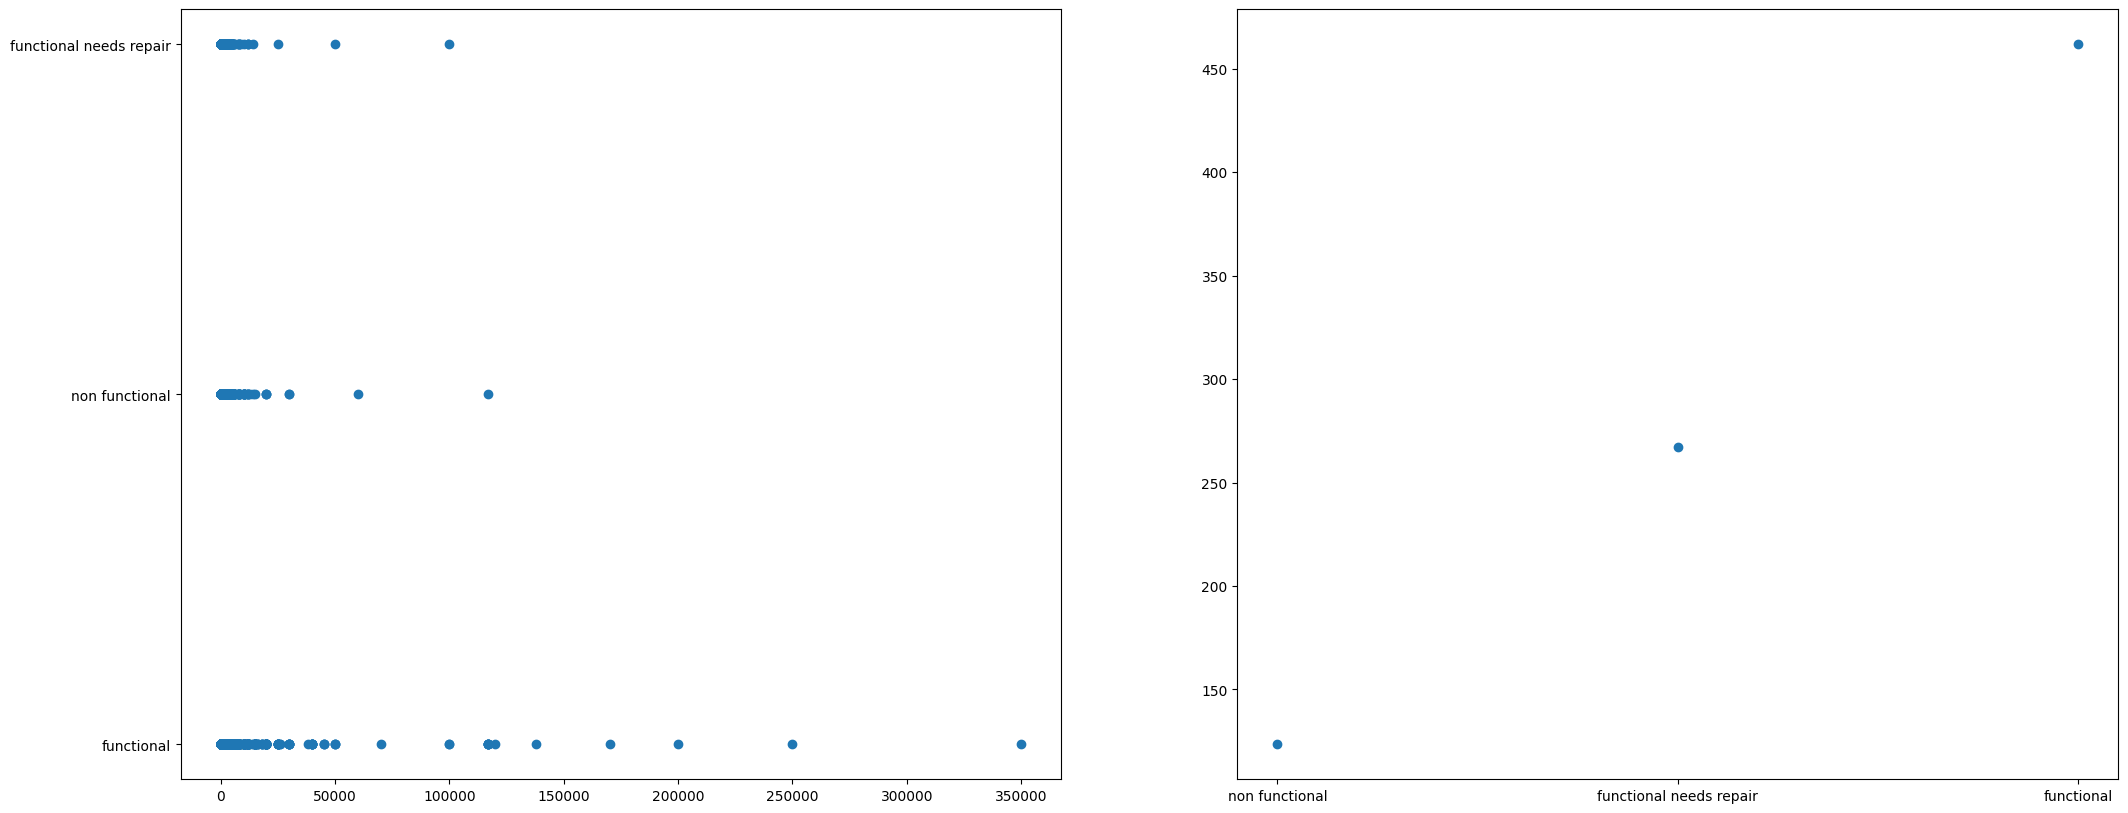

In [7]:
vals = ['non functional', 'functional needs repair', 'functional']

dictionary = {}
for val in df.status_group.unique():
    group = df[df.status_group == val]
    dictionary[val] = group.amount_tsh.mean()

fig, ax = plt.subplots(1, 2, figsize=(25,10))
ax[0].scatter(df['amount_tsh'], df['status_group'])
ax[1].scatter(['non functional', 'functional needs repair', 'functional'], [dictionary[i] for i in vals])

# Date_recorded: the date each row was entered

Rows entered range from being entered in October 2002 to December of 2013.

You might want to eliminate certain points from earlier years as they have little to no data points on them.

In [8]:
print (" Earliest: ", pd.to_datetime(df.date_recorded).min(), 
       
       "\n", 
       
       "Latest: ", pd.to_datetime(df.date_recorded).max())

 Earliest:  2002-10-14 00:00:00 
 Latest:  2013-12-03 00:00:00


In [9]:
print("Years that entries were recoreded:",
      list(df.date_recorded.map(lambda x: x[:4]).astype(int).unique()))

Years that entries were recoreded: [2011, 2013, 2012, 2004, 2002]


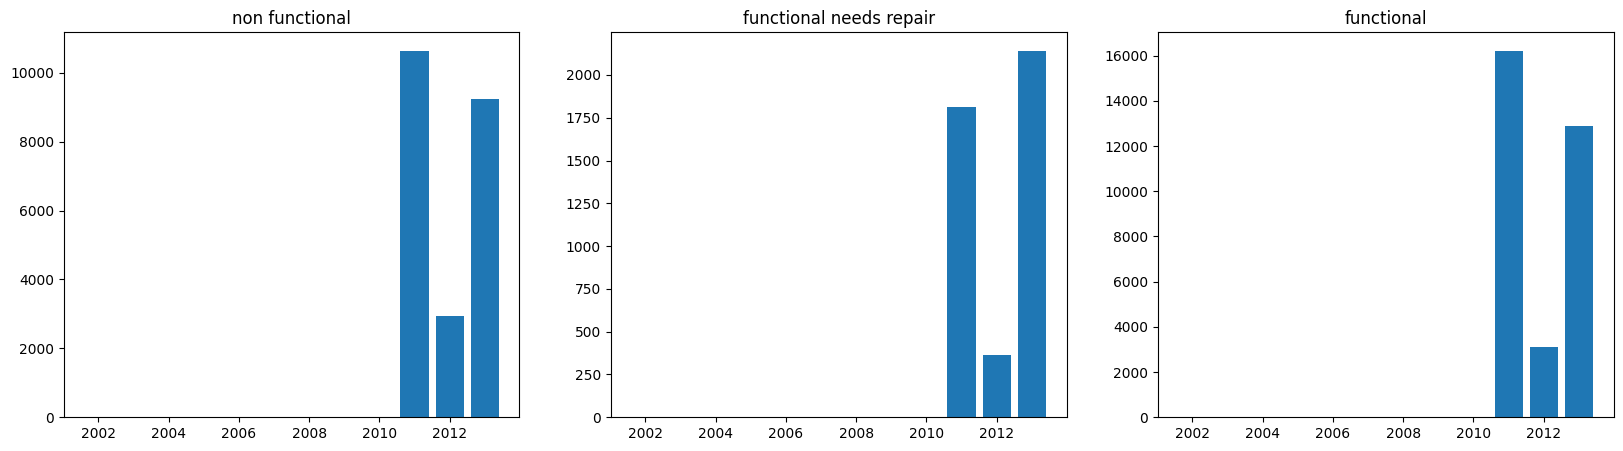

In [10]:
status_dict = {}

statuses = ['non functional', 'functional needs repair', 'functional']

for status in statuses:
    
    status_dict[status] = []
    
    years = [2002, 2004, 2011, 2012, 2013]

    for year in years:
        group = df.copy()
        group.date_recorded = df.date_recorded.map(lambda x: x[:4]).astype(int)
        group = group[group.date_recorded == year]
        group = group[group.status_group == status]
        status_dict[status].append(len(group))
        
fig, axes = plt.subplots(1, 3, figsize=(20,5))

for ax in range(len(axes)):
    axes[ax].bar(years, status_dict[statuses[ax]])
    axes[ax].set_title(statuses[ax])

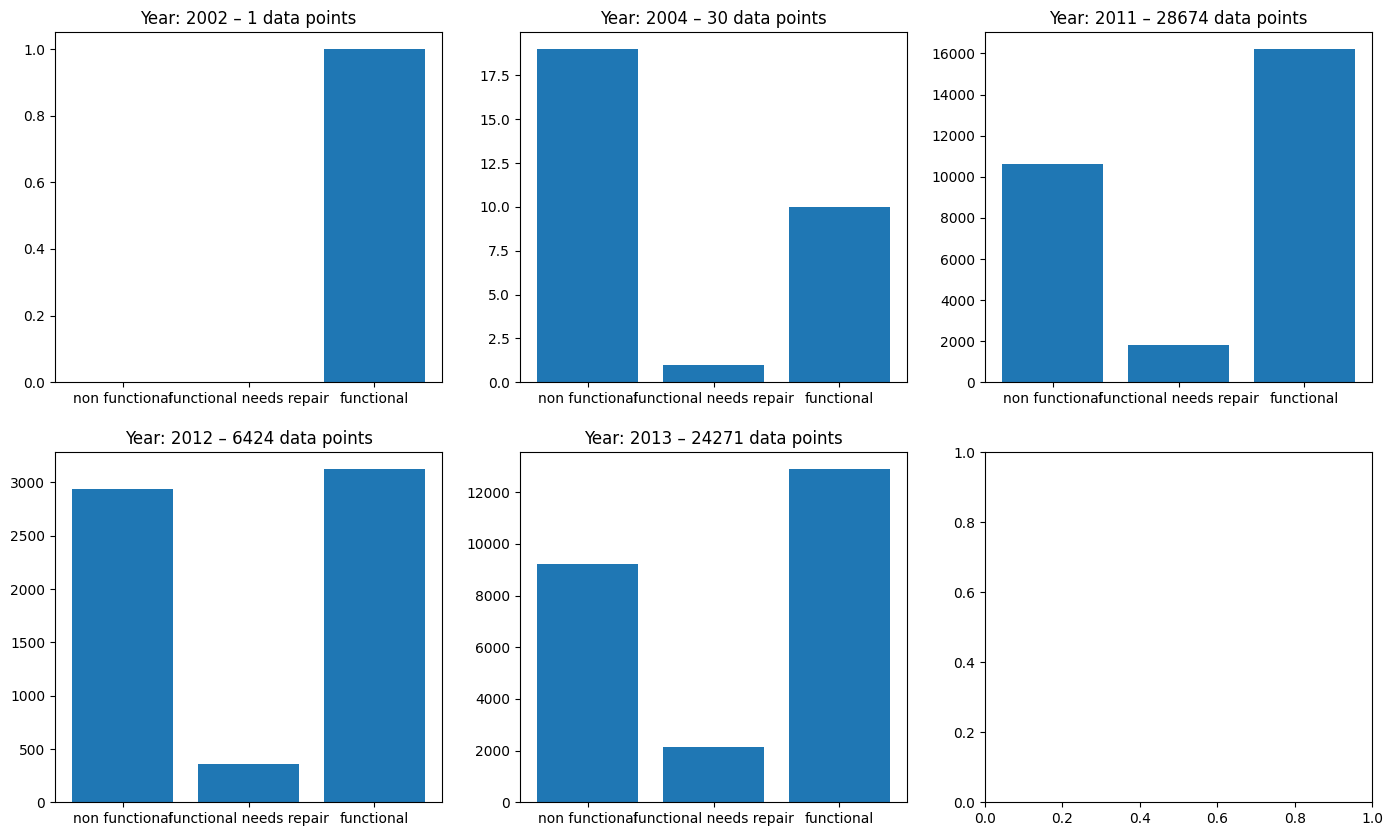

In [11]:
fig, axes = plt.subplots(2,3,figsize=(17,10))

for i in range(6):
    
    row = i//3
    col=i%3
    
    try:
        axes[row][col].bar(statuses, [lst[i] for lst in status_dict.values()])
        axes[row][col].set_title("Year: {} – {} data points". format(years[i], sum([lst[i] for lst in status_dict.values()])))
    except:
        continue

# Funder – Who Funded the Well

There's quite a few funders of – almost 1200 of them. Not surprisingly, the Government of Tanzania has the largest share of the waterpoints. Unknown funders have the second largest share amongst themselves, and Danida comes in second.

It would be hard to one-hot-encode this categorical variable, because it has so many values. This would create a whopping 1897 new columns.

Another issue is looking for duplicate values (such as 'Germany Republi' – does this mean there is another funder called 'Germany Republic' in the data? Do these refer to the same funder?)

We could solve all these issues by taking funders in the top 25, 50, or 100, and combing through them for duplicates. Once we do this, and collapse the duplicates, we then one-hot encode our streamlined column of funders. Although it will be a lot of new columns, at least it won't be 1897 of them.

The top 100 funders own ~80% of the waterpoints.
The top 50 own ~70%.
The top 25 own ~58%.

In [12]:
df.funder.nunique()

1897

In [122]:
funder_avg_dict = {}

for funder in df.funder.unique():
    funder_avg_dict[funder] = df[df.funder==funder].status_id.mean()
    
funder_avg_dict = dict(sorted(funder_avg_dict.items(), key=lambda x: x[1], reverse=True))

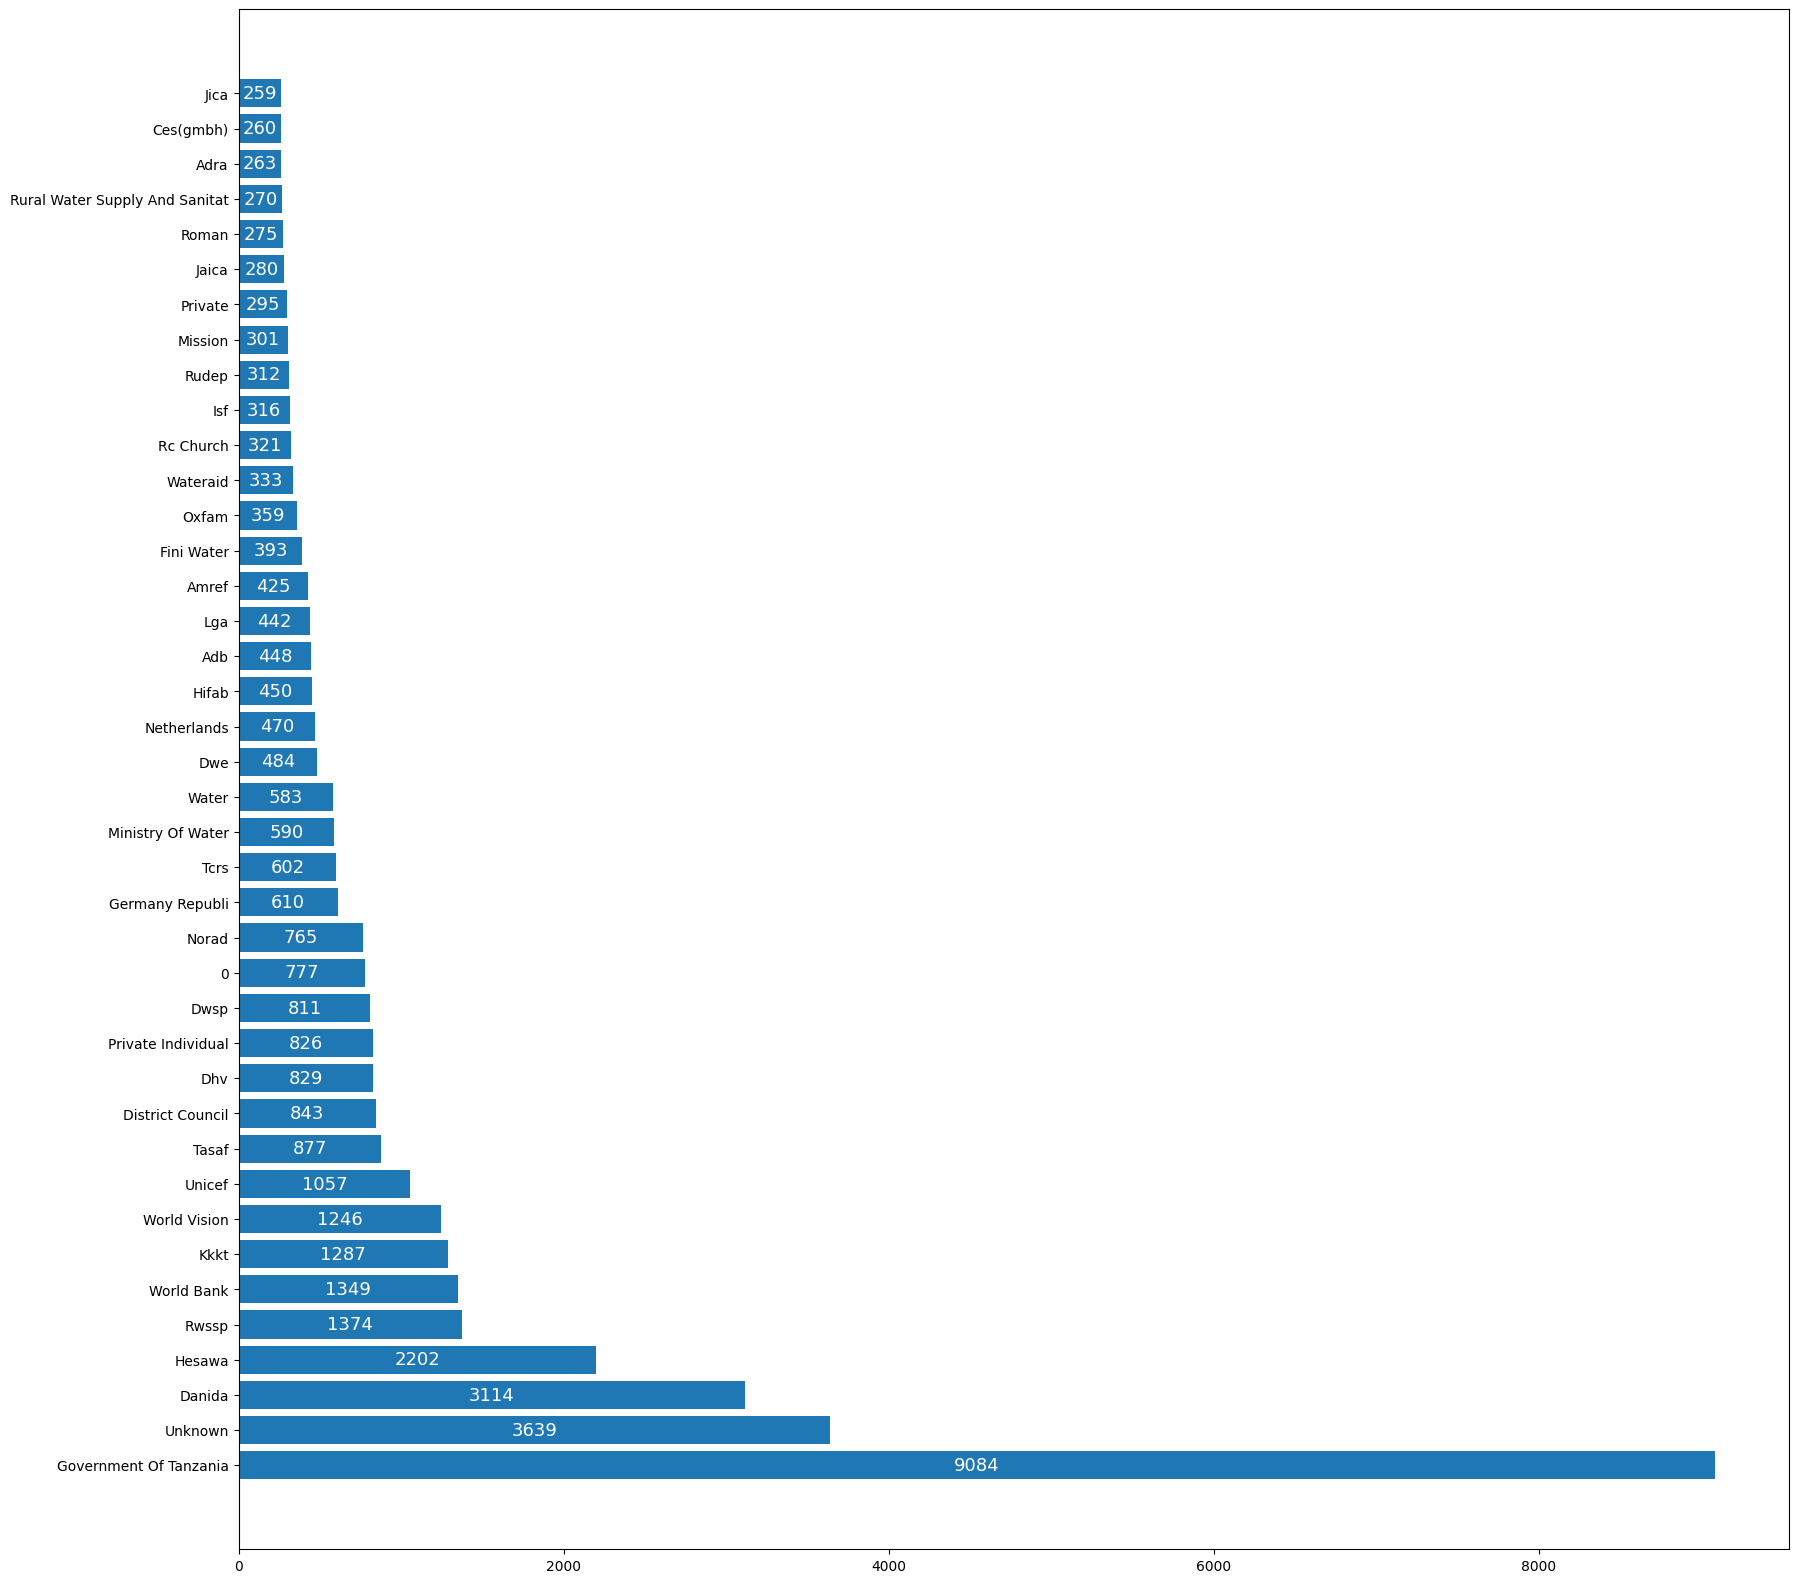

In [123]:
funder_dict = dict(df.funder.value_counts())

fig, ax = plt.subplots(figsize=(20,20))
barplot = ax.barh(list(funder_dict.keys())[:40], list(funder_dict.values())[:40])
ax.bar_label(barplot, labels=list(funder_dict.values())[:40], label_type='center', color='white', fontsize='13');

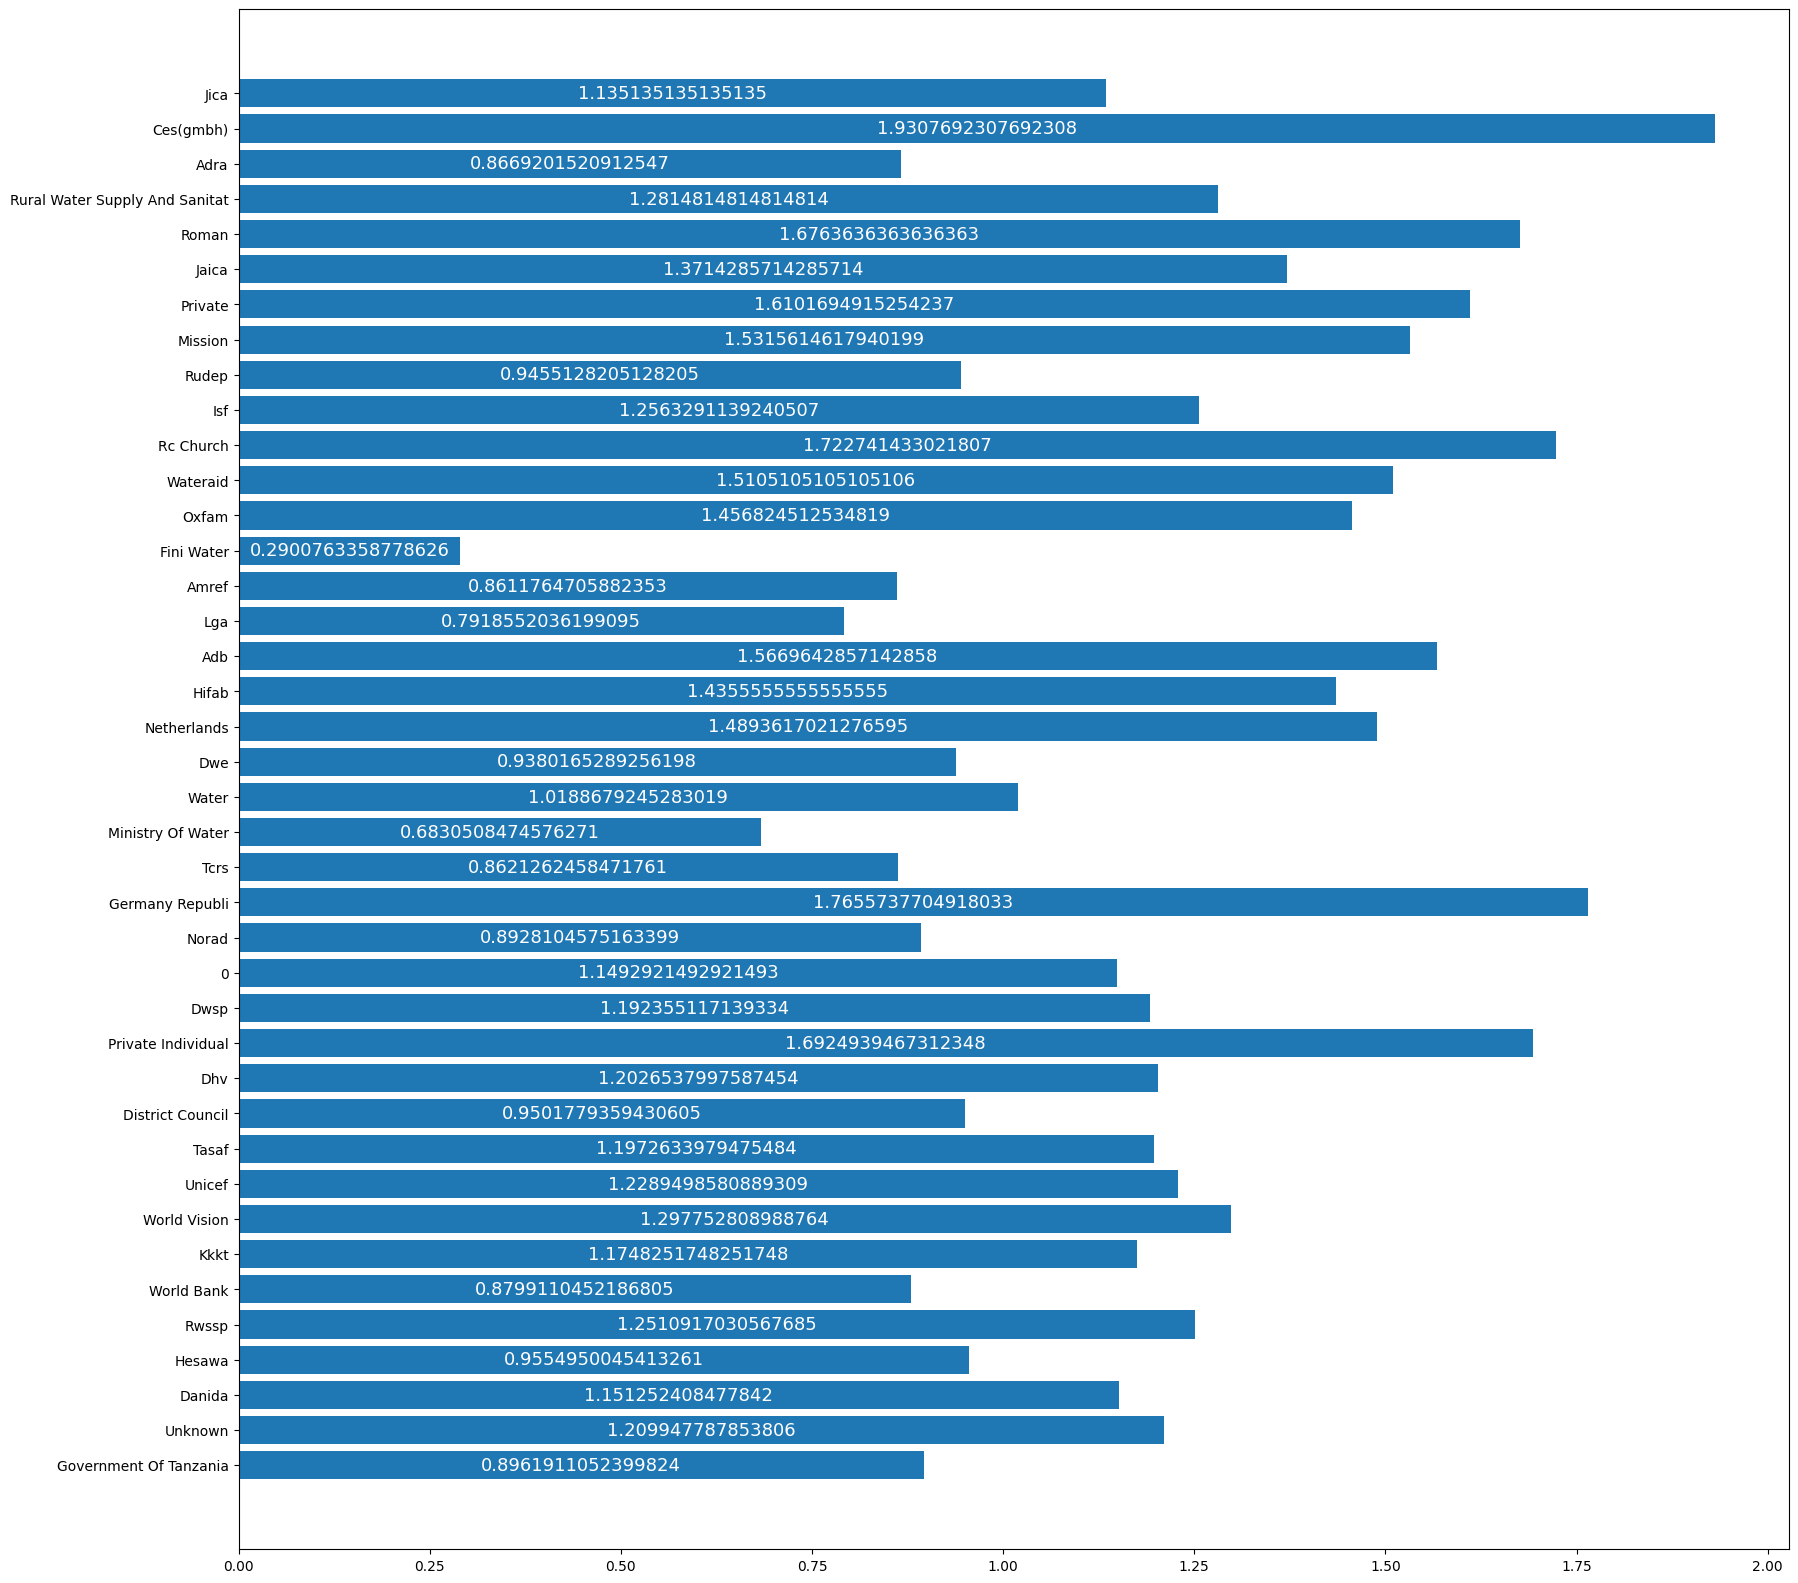

In [128]:
fig, ax = plt.subplots(figsize=(20,20))

lst = list(funder_dict.keys())[:40]
lst2 = [funder_avg_dict[x] for x in lst]

barplot = ax.barh(lst, lst2)
ax.bar_label(barplot, labels=lst2, label_type='center', color='white', fontsize='13');

In [130]:
df['funder_num'] = df.funder.map(lambda x: len(df[df.funder==x]))

In [134]:
df['funder_avg_status'] = df.funder.map(lambda x: df[df.funder==x].status_id.mean())

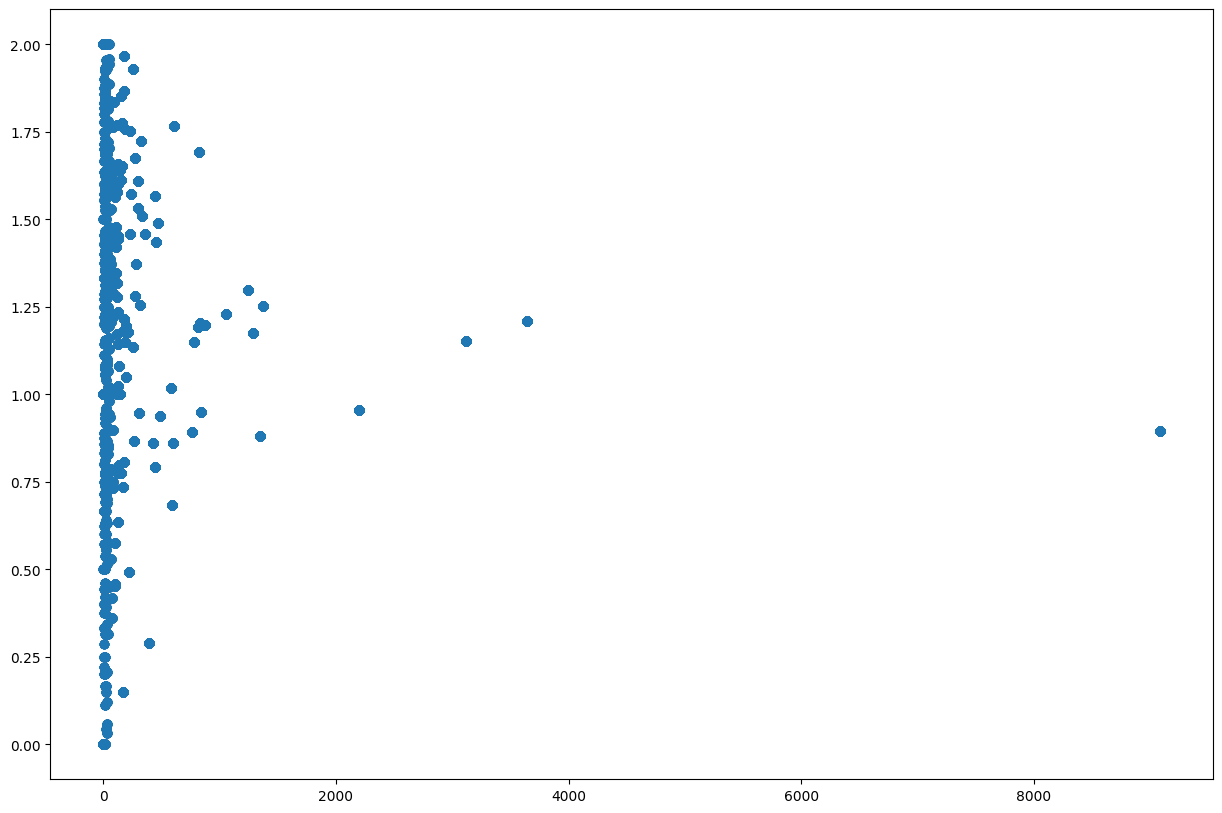

In [135]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(df.funder_num, df.funder_avg_status)

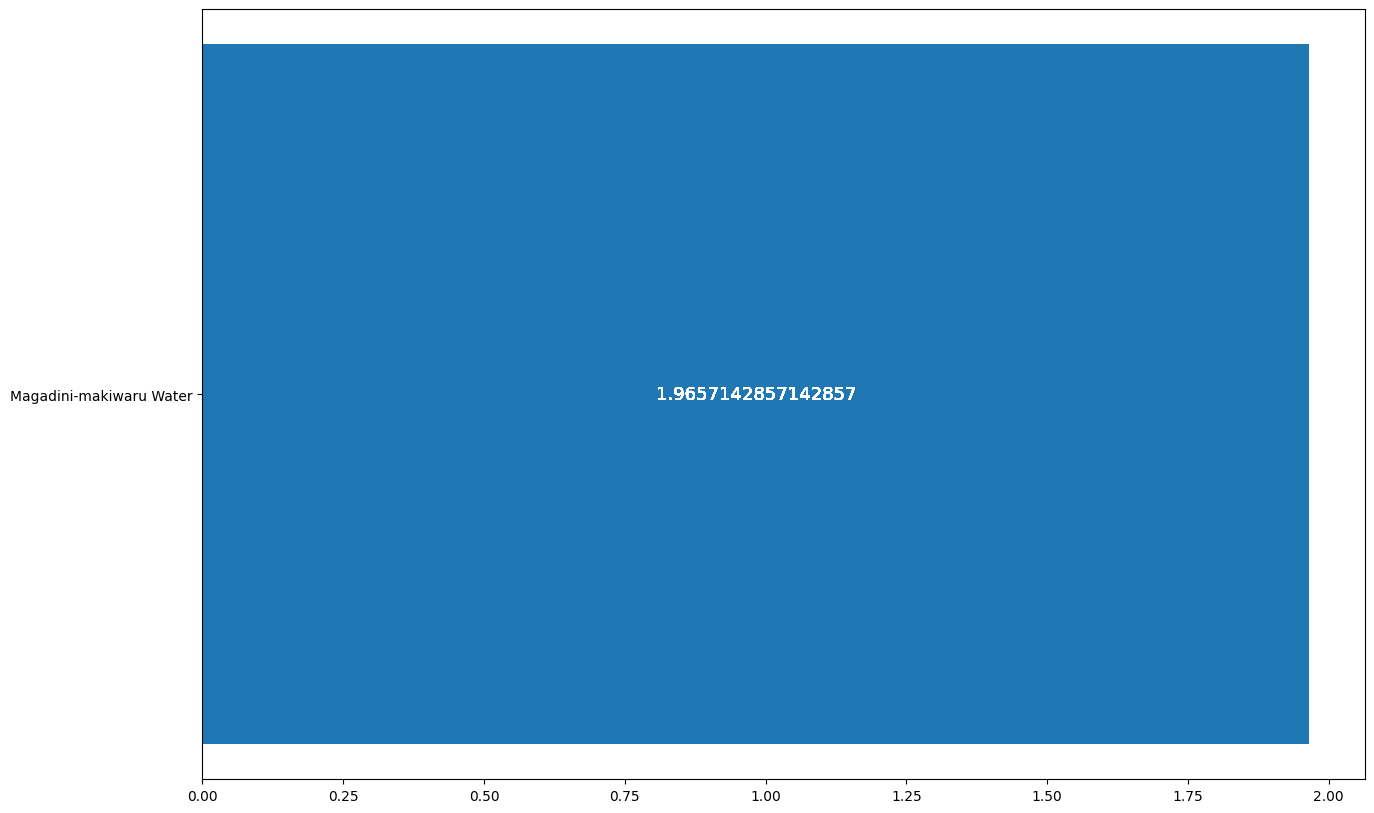

In [145]:
section = df.sort_values(by='funder_avg_status', ascending=False).query('funder_num>100')

fig, ax = plt.subplots(figsize=(15,10))
barplot = ax.barh(section.funder.iloc[:40], section.funder_avg_status.iloc[:40])
ax.bar_label(barplot, section.funder_avg_status.iloc[:40], label_type='center', color='white', fontsize='13');

In [14]:
sum(list(funder_dict.values())[:25])/len(df)

0.5851683501683501

# gps_height – Altitude of the Well

This is a pretty straightforward variable. It's how high the water well is.

There are quite a few values of '0' in this variable. Does this mean the altitude is unknown, or do all these wells truly have an altitude of 0? I don't know the answer to this.

It seems like there is a positive correlation between water well altitude and its level of functionality. Out of curiosity, I decided to eliminate the 0's from the dataset and see if there was any difference in the connection. This left 38,962 entries in the dataset (an elimination of 20,438 entries). It turns out that there was still a positive connection between the two variables.

In [15]:
df.gps_height.value_counts()

 0       20438
-15         60
-16         55
-13         55
 1290       52
         ...  
 2378        1
-54          1
 2057        1
 2332        1
 2366        1
Name: gps_height, Length: 2428, dtype: int64

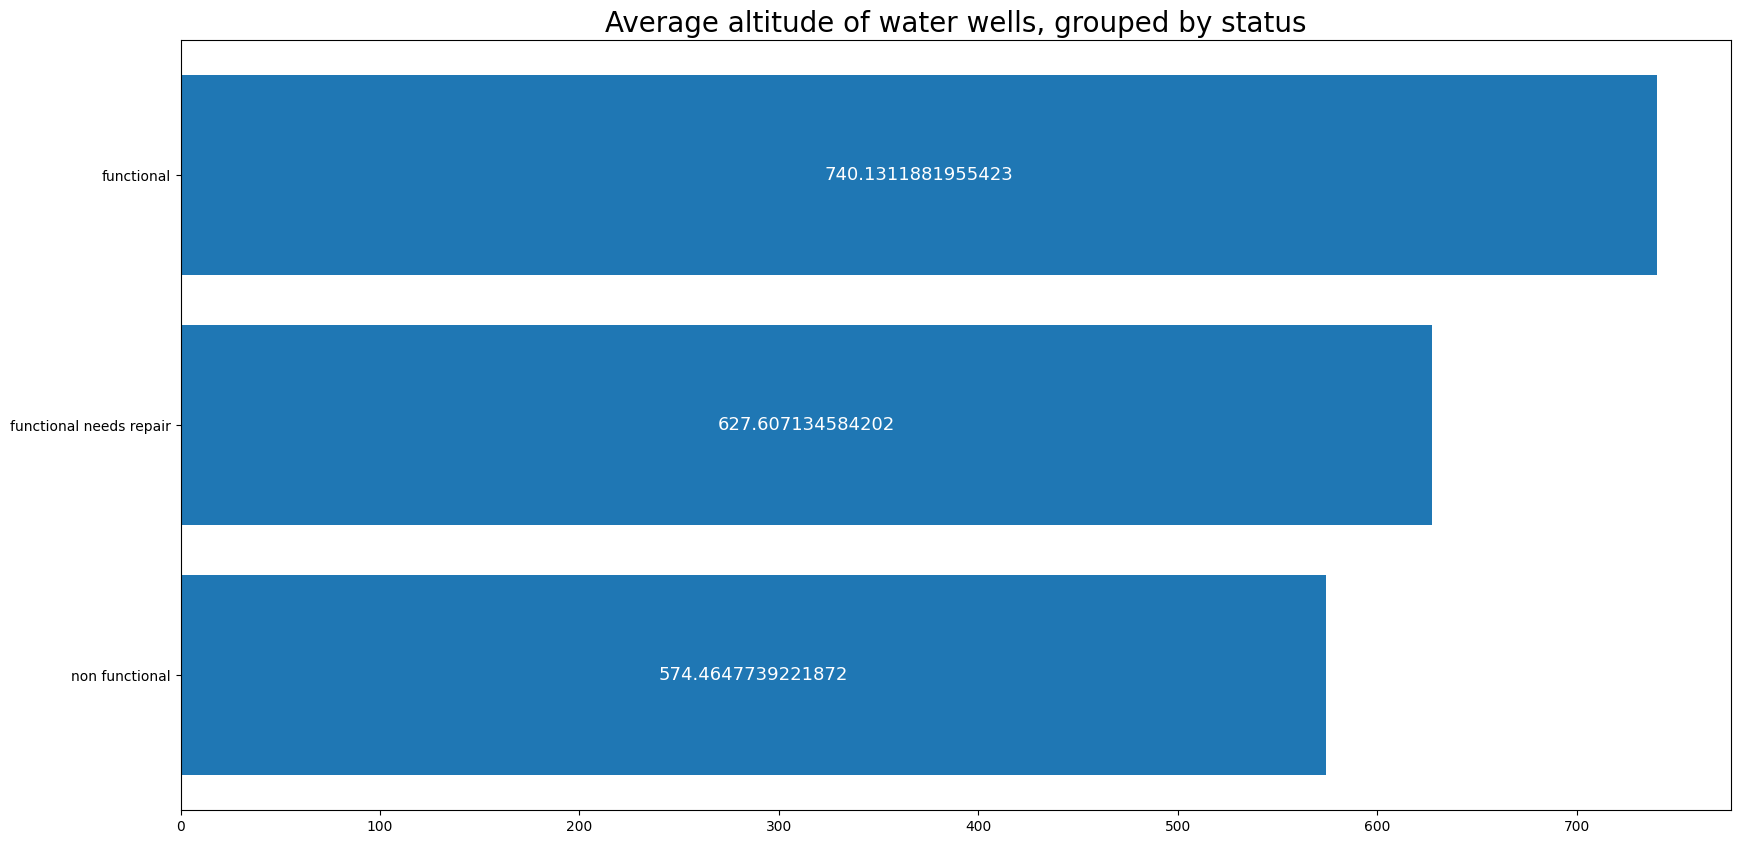

In [16]:
non_functional_average_gps_height = df[df.status_group == 'non functional'].gps_height.mean()
repair_average_gps_height = df[df.status_group == 'functional needs repair'].gps_height.mean()
functional_average_gps_height = df[df.status_group == 'functional'].gps_height.mean()

height_means = [non_functional_average_gps_height, repair_average_gps_height, functional_average_gps_height]

fig, ax = plt.subplots(figsize=(20,10))

barplot = ax.barh(statuses, height_means)

ax.bar_label(barplot, labels=height_means, label_type='center', color='white', fontsize='13');
ax.set_title("Average altitude of water wells, grouped by status", size=20);

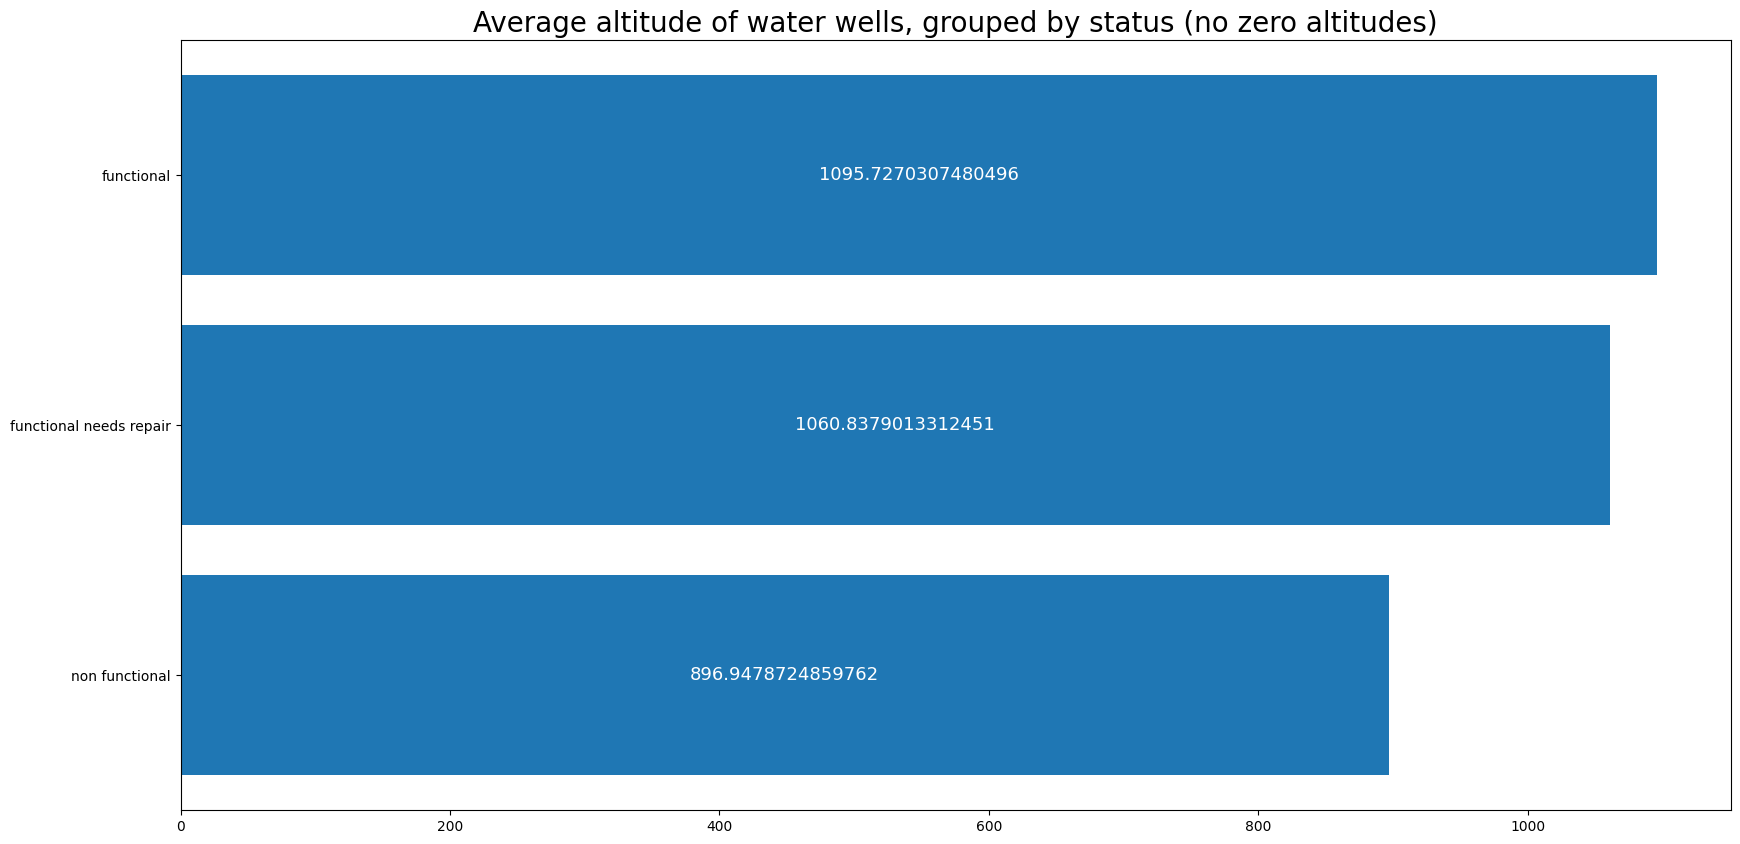

In [17]:
nonzeros = df.copy()
nonzeros = nonzeros[nonzeros.gps_height != 0]

non_functional_average_gps_height = nonzeros[nonzeros.status_group == 'non functional'].gps_height.mean()
repair_average_gps_height = nonzeros[nonzeros.status_group == 'functional needs repair'].gps_height.mean()
functional_average_gps_height = nonzeros[nonzeros.status_group == 'functional'].gps_height.mean()

height_means = [non_functional_average_gps_height, repair_average_gps_height, functional_average_gps_height]

fig, ax = plt.subplots(figsize=(20,10))

barplot = ax.barh(statuses, height_means)

ax.bar_label(barplot, labels=height_means, label_type='center', color='white', fontsize='13');
ax.set_title("Average altitude of water wells, grouped by status (no zero altitudes)", size=20);

# Installer – the Organization that installed the well

Says it all right there. I am worried that these labels are a bit of a mess. One of the highest ranking "installers" in this data is the "Government," which I assume to be the Government of Tanzania. Those should have the same labels in both columns, however, they are not.

Since it seems like there might be some overlap between the installer and funder columns, I decided to see if there was, and to what extent. Out of almost 60,000 water wells, around 9,300 are funded by their installer. Of those 9300, the proportions of statuses are about the same as those in the entire dataset.

In [18]:
df.installer.value_counts()

DWE           17402
Unknown        3658
Government     1825
RWE            1206
Commu          1060
              ...  
EWE               1
SCHOO             1
Got               1
Fabia             1
SELEPTA           1
Name: installer, Length: 2145, dtype: int64

In [19]:
print("There are {} waterwells that are funded by the same people that installed them.".format(len(df[df.installer == df.funder])))

There are 9278 waterwells that are funded by the same people that installed them.


In [20]:
df[df.installer == df.funder].status_group.value_counts() / len(df[df.installer == df.funder])

functional                 0.563484
non functional             0.361393
functional needs repair    0.075124
Name: status_group, dtype: float64

In [21]:
df.status_group.value_counts() / len(df)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

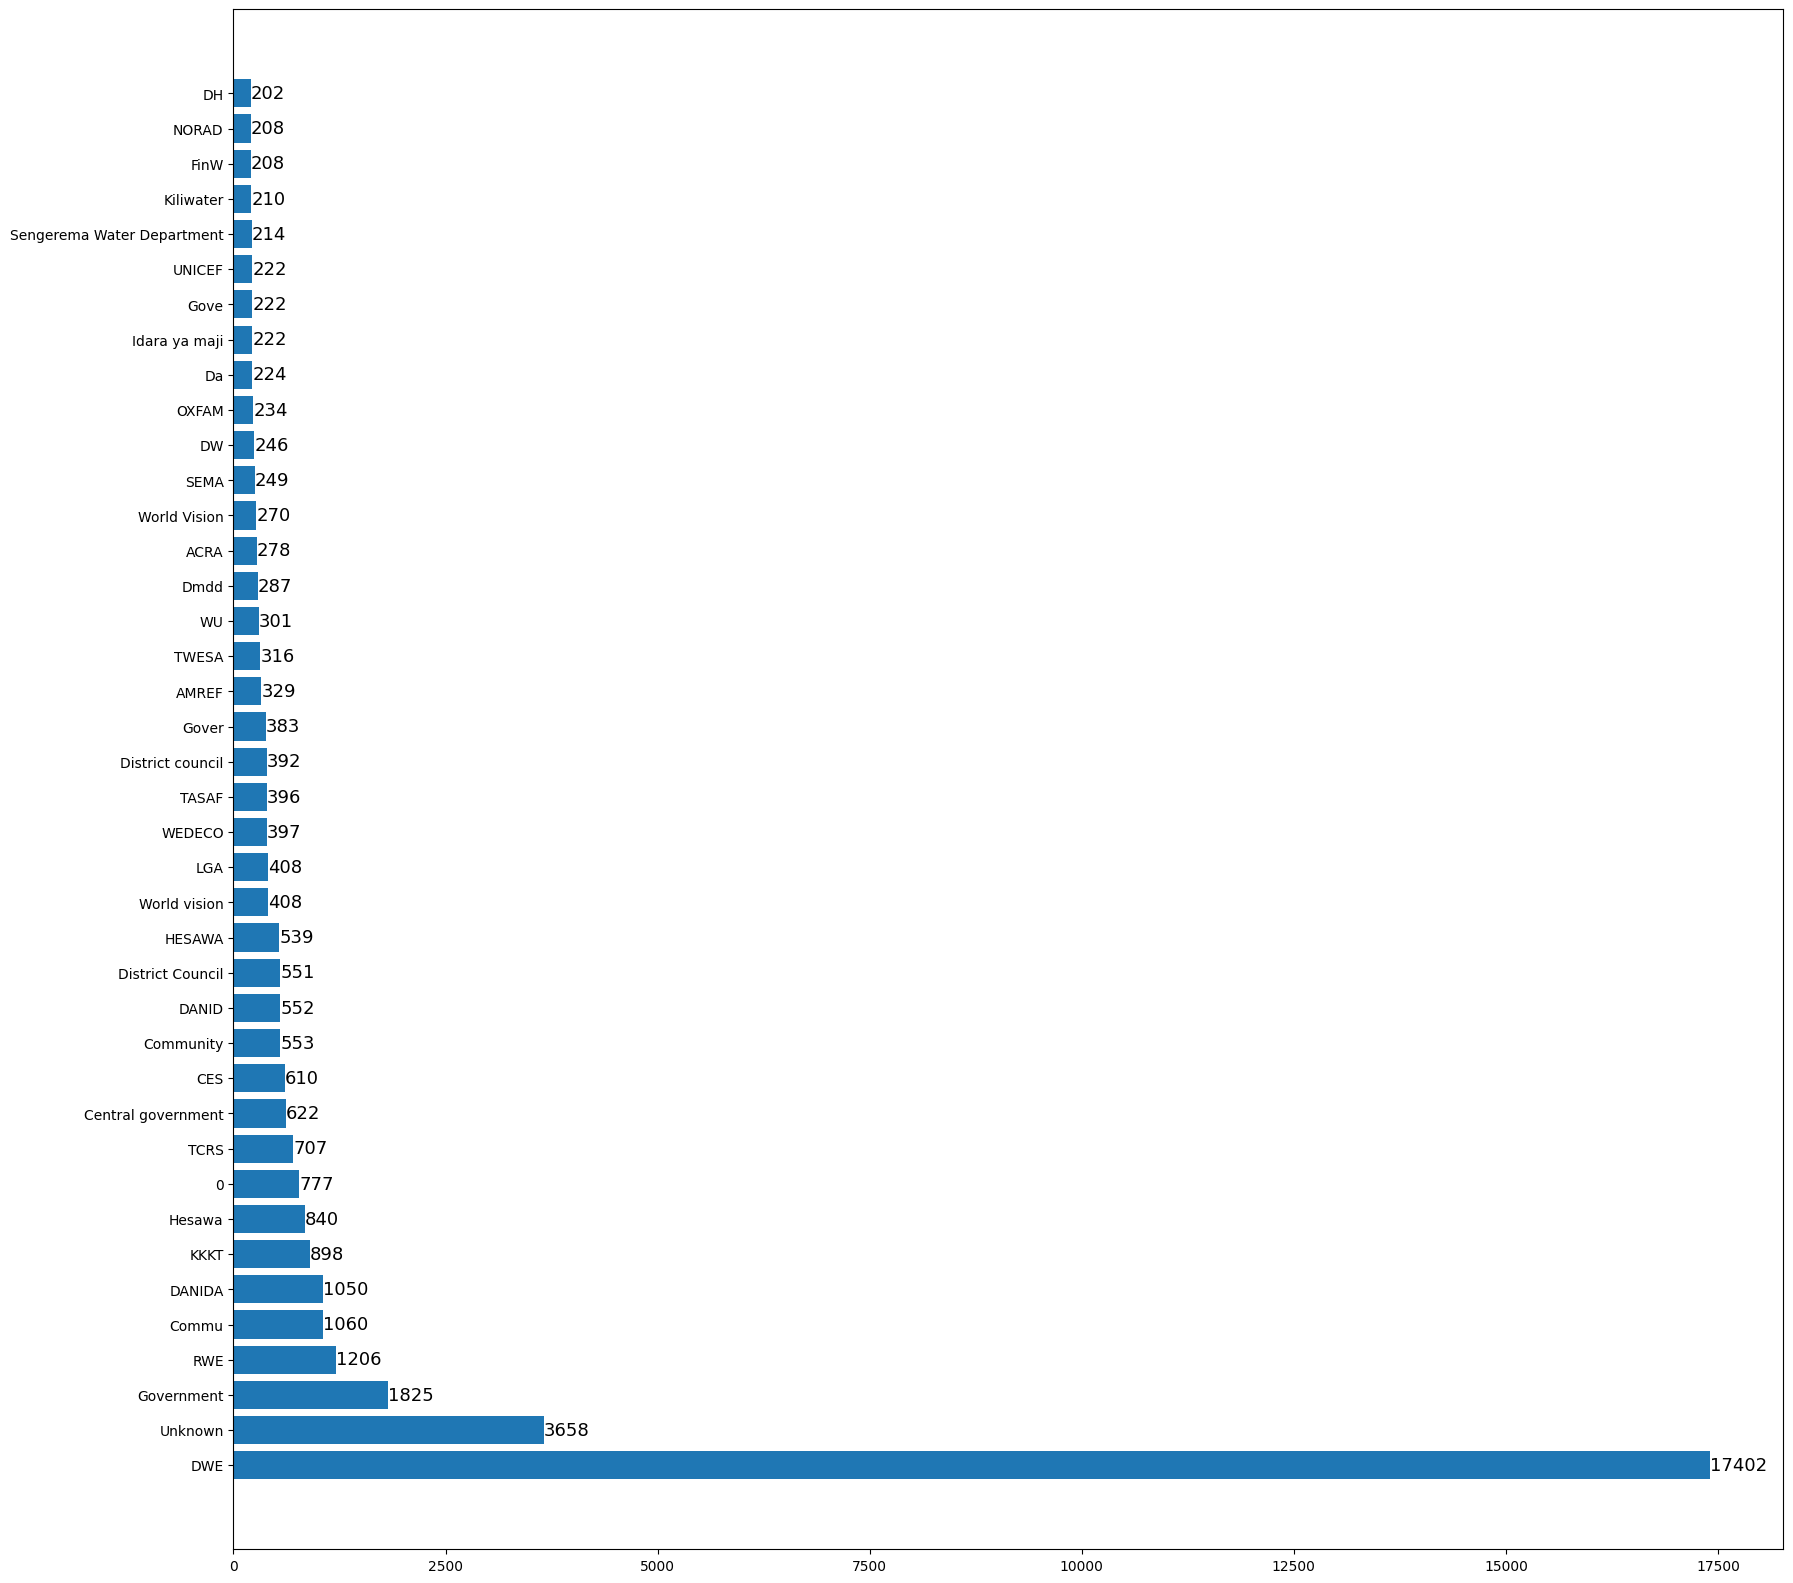

In [22]:
installer_dict = dict(df.installer.value_counts())

fig, ax = plt.subplots(figsize=(20,20))
barplot = ax.barh(list(installer_dict.keys())[:40], list(installer_dict.values())[:40])
ax.bar_label(barplot, labels=list(installer_dict.values())[:40], label_type='edge', color='black', fontsize='13');

In [23]:
df[df.installer == 'Government of Tanzania']

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,id,status_group


In [24]:
df[df.installer == 'Government of Tanzania']

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,id,status_group


In [25]:
df[df.installer == 'Government of Tanzania']

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,id,status_group


In [26]:
df[df.installer == 'Government of Tanzania']

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,id,status_group


# Latitude and Longitude

I group these variables together because they are inseparable. There are a lot of water wells with a longitude of 0, and a latitude close to 0, but not quite (for some reason it's recorded as a very small decimal).

Unfortunately I cannot eliminate these from the dataset, as they are present in both test and train data sets, to similar degrees. I cannot count them out of our training because then our model will not know how to treat these cases in the real world.

In [27]:
print('----LONGITUDES----')
print("There are {} water wells with a longitude recorded as 0.".format(len(df[df.longitude == 0])))
print("There are {} water wells in the test data set with a longitude recorded as 0.".format(len(X_test[X_test.longitude == 0])))

print('\n')

print('----LATITUDES----')
print("There are {} water wells with a latitude recorded as 0.".format(len(df[df.latitude > -0.5])))
print("There are {} water wells in the test data set with a latitude recorded as 0.".format(len(X_test[X_test.latitude > -0.5])))

----LONGITUDES----
There are 1812 water wells with a longitude recorded as 0.
There are 457 water wells in the test data set with a longitude recorded as 0.


----LATITUDES----
There are 1812 water wells with a latitude recorded as 0.
There are 457 water wells in the test data set with a latitude recorded as 0.


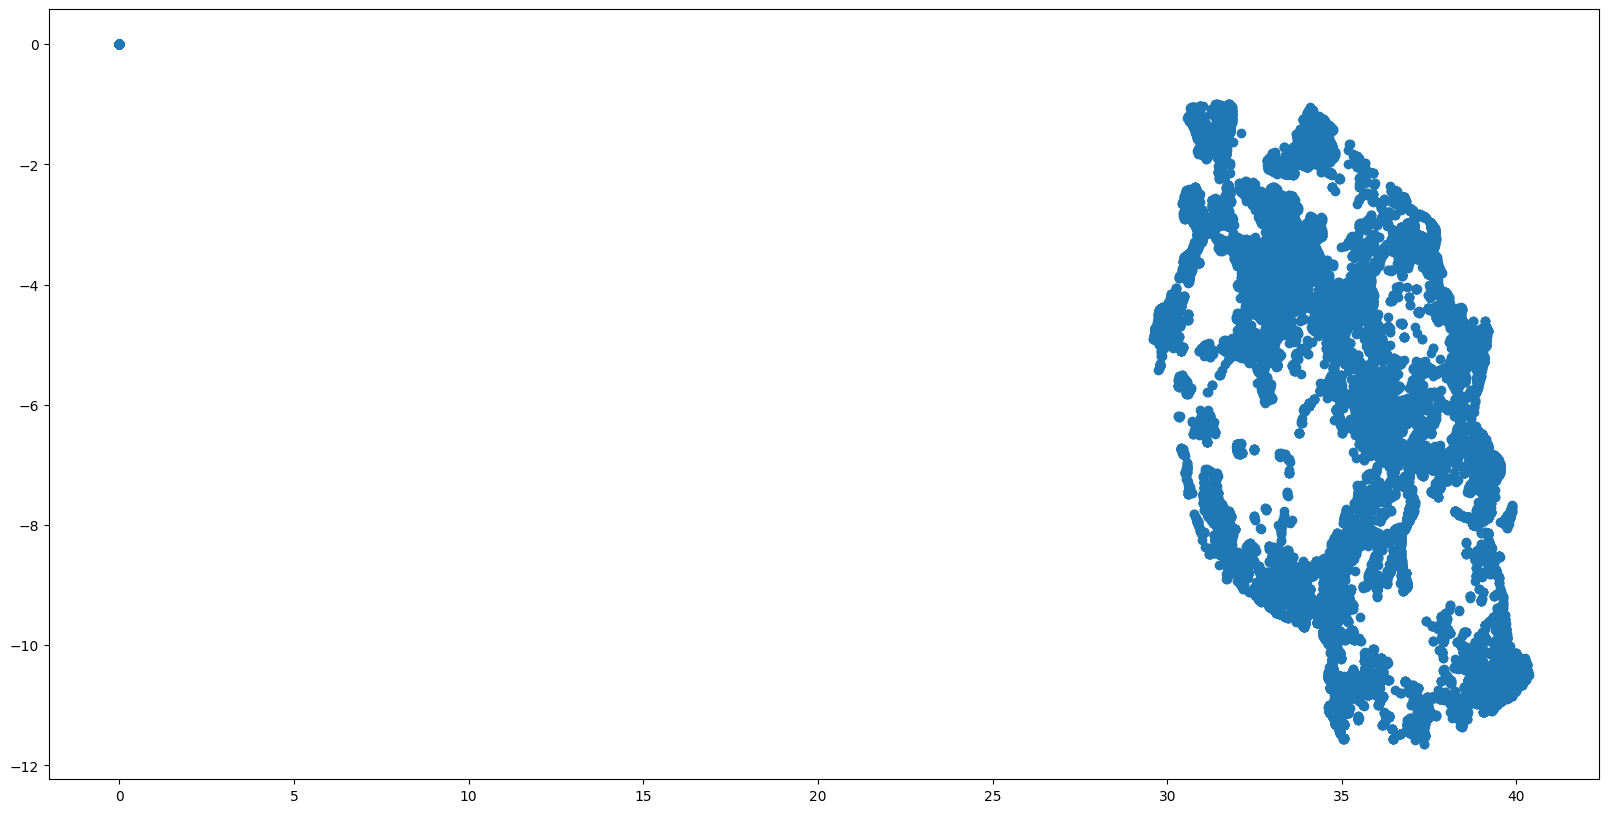

In [28]:
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(df.longitude, df.latitude)

# wpt_name – Name of the waterpoint if there is one

Although this seems like a useless variable, better left unused, I still have a question: how is it that different water wells have the same name? Doesn't that make 0 sense?

In [29]:
df.wpt_name.value_counts()

none                       3563
Shuleni                    1748
Zahanati                    830
Msikitini                   535
Kanisani                    323
                           ... 
Kwa Medadi                    1
Kwa Kubembeni                 1
Shule Ya Msingi Milanzi       1
Funua                         1
Kwa Mzee Lugawa               1
Name: wpt_name, Length: 37400, dtype: int64

# Subvillage – Geographic Location

This variable is described as being a "geographic location" – however, there are multiple variable with such a description. We will ignore this for now.

Unfortunately, there are over 19,000 unique water well names. Unless we can handle those with a frequency of 1, or 2, or 3, this column is quite useless. One-hot-encoding it would result in thousands upon thousands of new columns, which is not ideal for our model.

It seems like there is no relationship between the number of water pumps in a village and the expected frequency of status groups in that village.

In [30]:
df.subvillage.value_counts()

Madukani        508
Shuleni         506
Majengo         502
Kati            373
Unknown         371
               ... 
Kipompo           1
Chanyamilima      1
Ikalime           1
Kemagaka          1
Kikatanyemba      1
Name: subvillage, Length: 19288, dtype: int64

In [31]:
copy = df.copy()
copy['subvillage_count'] = copy.subvillage.map(copy.subvillage.value_counts())

In [32]:
copy.groupby(by=['status_group']).sum()

/var/folders/s6/jlb2zd1s5gq39tnl2x_y5z_r0000gn/T/ipykernel_64708/278736159.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  copy.groupby(by=['status_group']).sum()


,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,id,subvillage_count
status_group,,,,,,,,,,,,
functional,1194768620,14897149.25,23875892,1.104615e+06,-184035.053743,17388,439252,165639,6050282,43406669,1194768620,1041158
functional needs repair,160382005,1152948.00,2709380,1.348721e+05,-22286.857040,1328,66670,20545,755916,5044012,160382005,145074
non functional,849488202,2818335.60,13111584,7.847121e+05,-132616.429199,9448,402720,148223,3880455,28808076,849488202,836890


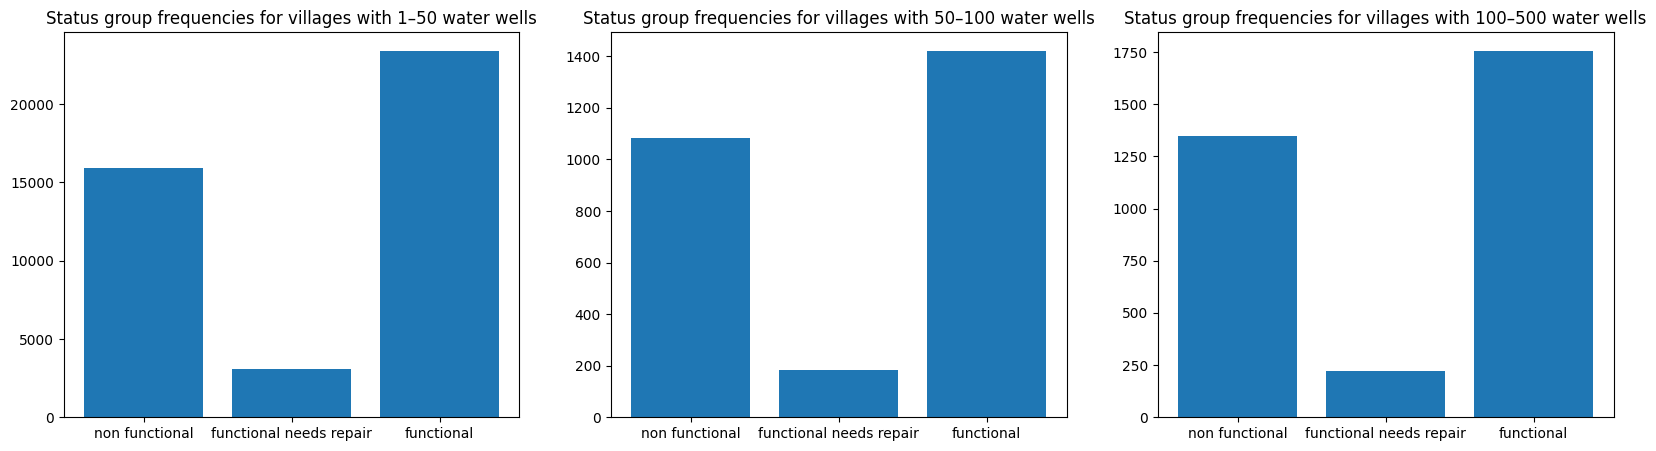

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))

tops = [1, 50, 100, 500]

for i in [0,1,2]:
    subdf = copy[(copy.subvillage_count > tops[i]) & (copy.subvillage_count < tops[i+1])]
    
    non_functional = len(subdf[subdf.status_group == 'non functional'])
    repair = len(subdf[subdf.status_group == 'functional needs repair'])
    functional = len(subdf[subdf.status_group == 'functional'])
    
    subvillage_status = [non_functional, repair, functional]
    
    axes[i].bar(statuses, subvillage_status)
    
    axes[i].set_title("Status group frequencies for villages with {}–{} water wells".format(tops[i], tops[i+1]))

# Region – Geographic Location

Although region is another geographic location variable, there is very little overlap between this and the "subvillage" variable.

This is a much tidier geographic location column; it would be possible to one-hot encode this. There are only 21 unique regions, making it gloriously clean and usable compared to previous columns.

In [34]:
print(f"There are {len(df[df.region == df.subvillage])} entries where the subvillage is the same as the region.")
print(f"These regions are: {list(dict(df[df.region == df.subvillage].subvillage.value_counts()).keys())}")
print('-----------')
print(f"There are {df.region.nunique()} unique regions in this dataset.")

There are 37 entries where the subvillage is the same as the region.
These regions are: ['Ruvuma', 'Kigoma', 'Mbeya', 'Mwanza', 'Kilimanjaro', 'Singida', 'Shinyanga', 'Morogoro', 'Mtwara', 'Pwani']
-----------
There are 21 unique regions in this dataset.


In [35]:
df.region.value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

# region_code – Geographic location (coded)

This variable is supposed to be correspondent to the region variable that we looked at above. The value counts should return the same ordered list of numbers in both variables. However, it does not. In fact, it's not even close, which means that someone did something incorrectly.

Further investigation will reveal how, where, and why these two variables differ (they should be identical, with each region corresponding to a specific number).

It raises the question of whether we can reliably use either of these two variables at all. Are they accurately recorded? Can we use them without worrying about the accuracy of our model?

Furthermore, this is a categorical variable encoded as a numeric one – we don't want our model assuming a numeric relationship between data points when there is none. The difference between 1 and 2 is not the same as that between 2 and 3 – in fact, it doesn't even make sense to say "the difference between" those two numbers.

In [36]:
df.region_code.value_counts()

11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64

# district_code – Geographic location (coded)

Again, this is a tidy variable that could be one-hot-encoded.

Also cannot use this variable alone due to its numeric encoding (no numeric relationship between data points).

In [37]:
df.district_code.value_counts()

1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62      109
60       63
0        23
80       12
67        6
Name: district_code, dtype: int64

# lga – Geographic location

There are quite a few "geographic location" variables. This is one of the less desirable ones, since it has to be one-hot-encoded, and it has 125 values. One good thing about it: 99% of its values occur >10 times, which means there is no abundance of one-time unique values.

In [38]:
df.lga.value_counts()

Njombe          2503
Arusha Rural    1252
Moshi Rural     1251
Bariadi         1177
Rungwe          1106
                ... 
Moshi Urban       79
Kigoma Urban      71
Arusha Urban      63
Lindi Urban       21
Nyamagana          1
Name: lga, Length: 125, dtype: int64

# Ward – Geographic location

Wow...

In [39]:
df.ward.value_counts()

Igosi              307
Imalinyi           252
Siha Kati          232
Mdandu             231
Nduruma            217
                  ... 
Uchindile            1
Thawi                1
Uwanja wa Ndege      1
Izia                 1
Kinungu              1
Name: ward, Length: 2092, dtype: int64

# Population – population around the well

This is a meaningful variable.

It seems like all the low values in the population change its distribution for the different statuses. Eliminate all 0s from the popuation column, and you end up with a different distribution per status. Eliminate all values less than 10, and you end up with an even more different distribution.

The most common population value by far is 0.

In [40]:
print(f"There are {len(df[df.population==0])} water wells with a population of 0 around them.")
print(f"There are {len(df[df.population>100])} water wells with a population greater than 100 around them.")
print(f"There are {len(df[df.population==1000])} water wells with a population greater than 1000 around them.")
print(f"There are {len(df[df.population==10000])} water wells with a population greater than 10000 around them.")

There are 21381 water wells with a population of 0 around them.
There are 22102 water wells with a population greater than 100 around them.
There are 278 water wells with a population greater than 1000 around them.
There are 3 water wells with a population greater than 10000 around them.


In [41]:
df.describe().population

count    59400.000000
mean       179.909983
std        471.482176
min          0.000000
25%          0.000000
50%         25.000000
75%        215.000000
max      30500.000000
Name: population, dtype: float64

In [42]:
df[df.status_group == 'non functional'].describe().population

count    22824.000000
mean       170.016430
std        413.094978
min          0.000000
25%          0.000000
50%          1.000000
75%        230.000000
max       9865.000000
Name: population, dtype: float64

In [43]:
df[df.status_group == 'functional needs repair'].describe().population

count     4317.000000
mean       175.102154
std        433.033756
min          0.000000
25%          0.000000
50%         25.000000
75%        245.000000
max      15300.000000
Name: population, dtype: float64

In [44]:
df[df.status_group == 'functional'].describe().population

count    32259.000000
mean       187.553303
std        513.198991
min          0.000000
25%          0.000000
50%         40.000000
75%        200.000000
max      30500.000000
Name: population, dtype: float64

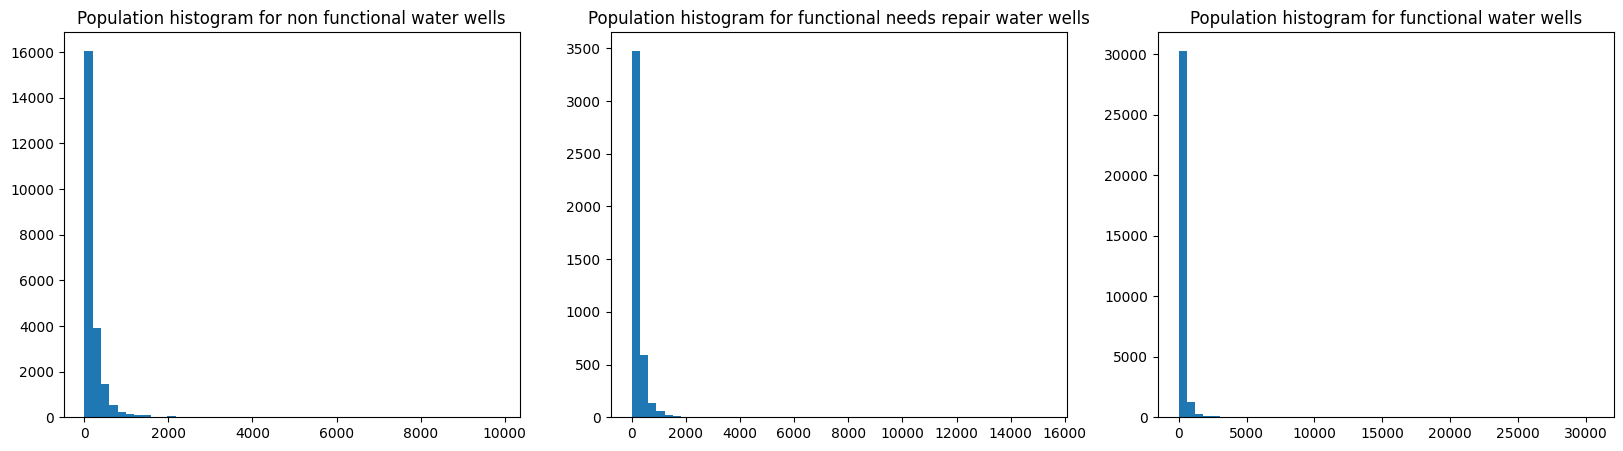

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))

for i in [0,1,2]:
    axes[i].hist(df[df.status_group == statuses[i]].population, bins=50)
    axes[i].set_title('Population histogram for {} water wells'.format(statuses[i]))

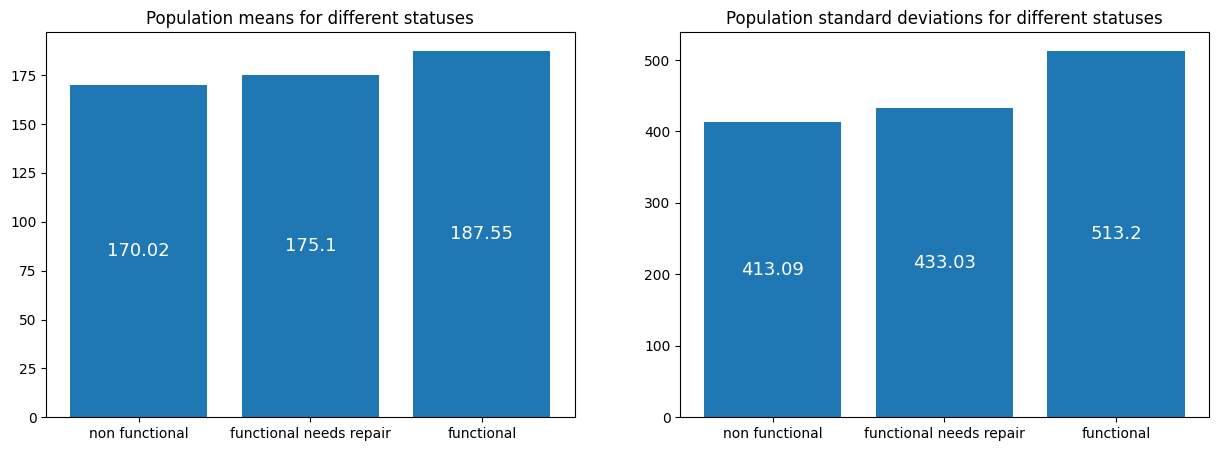

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

means = [df[df.status_group == statuses[i]].population.mean() for i in [0,1,2]]
stds = [df[df.status_group == statuses[i]].population.std() for i in [0,1,2]]

means = [round(i,2) for i in means]
stds = [round(i,2) for i in stds]
titles = ['means', 'standard deviations']
data = [means, stds]


for i in [0,1]:
    barplot = axes[i].bar(statuses, data[i])
    axes[i].bar_label(barplot, labels=data[i], label_type='center', color='white', fontsize='13');
    axes[i].set_title(f"Population {titles[i]} for different statuses")

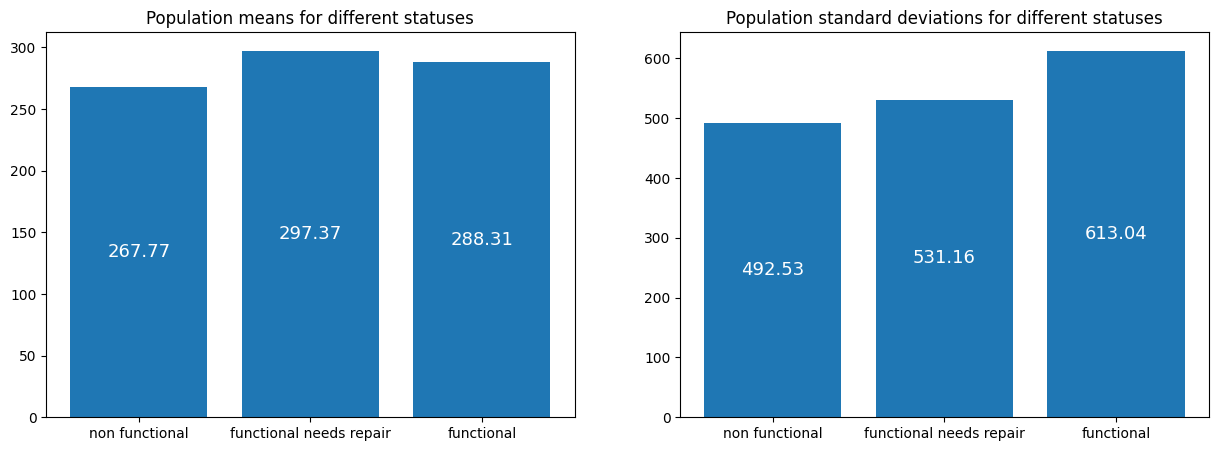

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

copy = df.copy()
copy = copy[copy.population > 0]

means = [copy[copy.status_group == statuses[i]].population.mean() for i in [0,1,2]]
stds = [copy[copy.status_group == statuses[i]].population.std() for i in [0,1,2]]\

means = [round(i,2) for i in means]
stds = [round(i,2) for i in stds]
titles = ['means', 'standard deviations']
data = [means, stds]


for i in [0,1]:
    barplot = axes[i].bar(statuses, data[i])
    axes[i].bar_label(barplot, labels=data[i], label_type='center', color='white', fontsize='13');
    axes[i].set_title(f"Population {titles[i]} for different statuses")

# public_meeting – True/False

There is no meaningful description of this variable in the information I was provided. I might have to go onto Kaggle to see if they have more info.

It seems like the distribution of public_meeting is almost identical for all water wells. However, it is an easy variable to use in our model given its boolean nature.

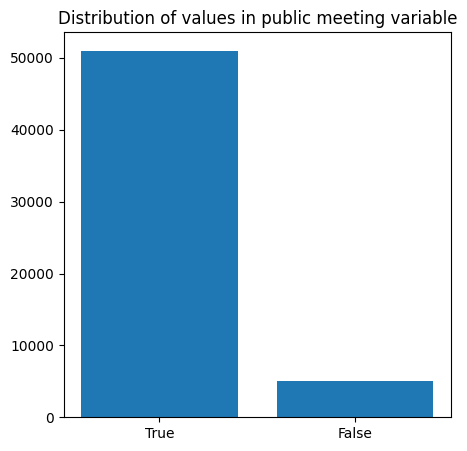

In [48]:
fig, ax = plt.subplots(figsize=(5,5))
ax.bar(['True', 'False'], [len(df[df.public_meeting == i]) for i in [True, False]])
ax.set_title('Distribution of values in public meeting variable');

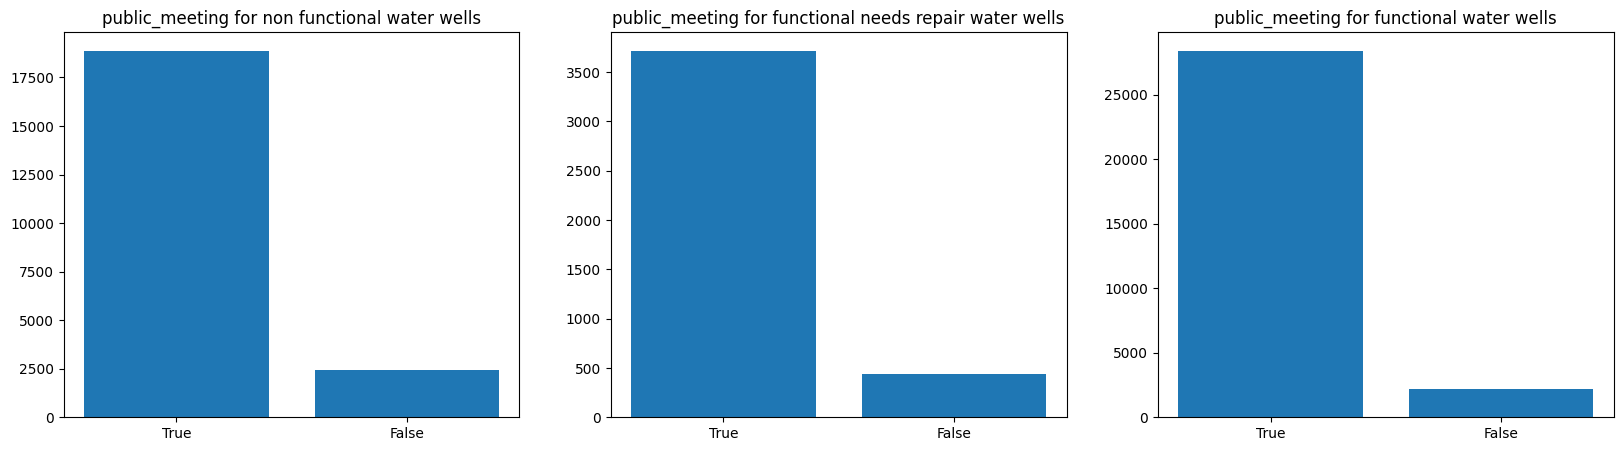

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))

for x in [0,1,2]:
    copy = df.copy()
    copy = copy[copy.status_group == statuses[x]]
    axes[x].bar(['True', 'False'], [len(copy[copy.public_meeting == i]) for i in [True, False]])
    axes[x].set_title('public_meeting for {} water wells'.format(statuses[x]));

# recorded_by – Group entering this row of data

Useless variable, only has one value: the group that created this dataset ('GeoData Consultants Ltd').

In [50]:
df.recorded_by.value_counts()

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

# scheme_management – Who operates the waterpoint

This variable seems like a good candidate for inclusion. There are only 12 unique waterpoint operators, making it easy for one-hot-encoding.

Furthermore, it's possible that a waterpoint with no operator is more likely to be dysfunctional or needing repair. Perhaps there are operators that are poorly or highly skilled, making their water pumps more/less likely to be functional.

Certain operators seem to stand out. No operator does not lead to the dysfunctional balance we thought it would. SWC seems to be the worst. Certain operators, such as the Water Board, seem to excel at keeping their pumps functional. The Water Authority seems to have the most water pumps in need of repair.

In [51]:
print(f"There are only {df.scheme_management.nunique()} unique waterpoint operators.")

There are only 12 unique waterpoint operators.


In [52]:
df.scheme_management.value_counts()

VWC                 36793
WUG                  5206
None                 3878
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
Name: scheme_management, dtype: int64

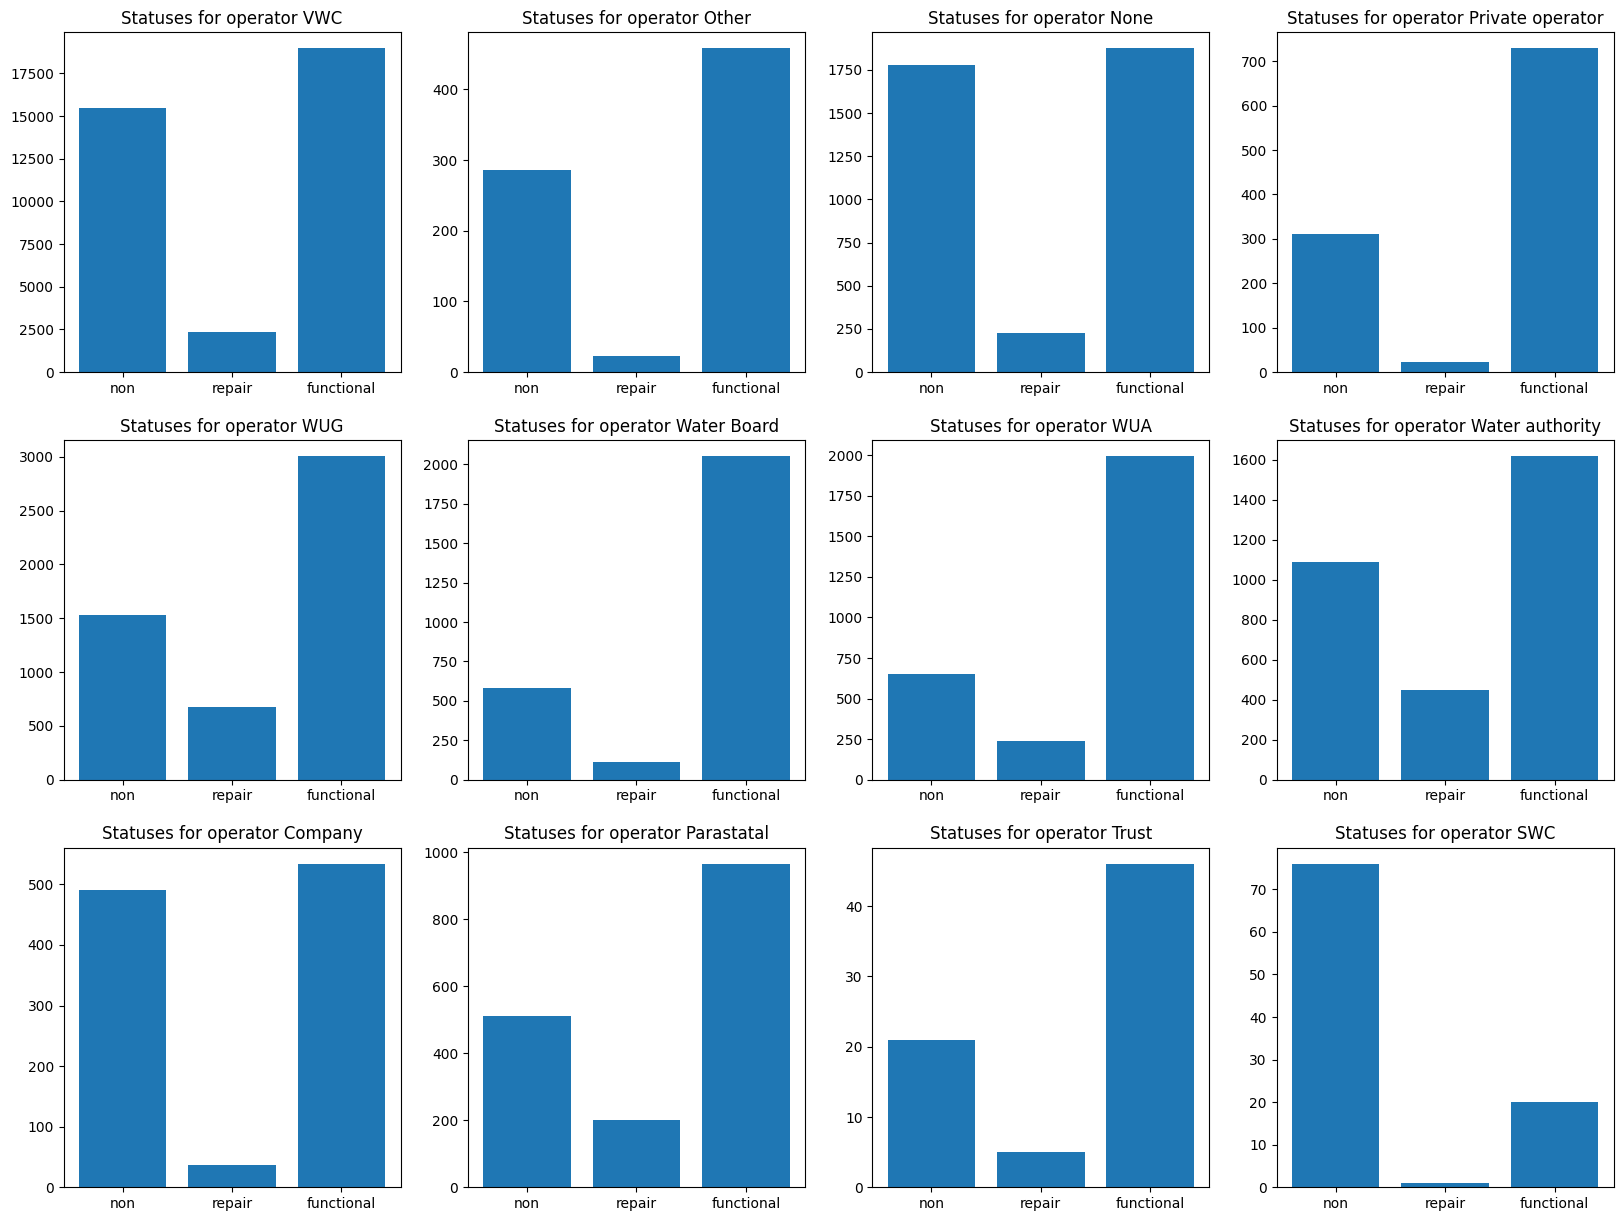

In [53]:
operators = df.scheme_management.unique()

fig, axes = plt.subplots(3,4, figsize=(20,15))

for i in range(12):
    
    row = i//4
    col=i%4
    
    copy = df.copy()
    copy = copy[copy.scheme_management == operators[i]]
    
    axes[row][col].bar(['non', 'repair', 'functional'], [len(copy[copy.status_group == i]) for i in statuses])
    axes[row][col].set_title("Statuses for operator {}".format(operators[i]))

# scheme_name – Who operates the waterpoint

I thought the previous variable did this. Out of the two variables that claim to record "who operates the waterpoint", the previous one (scheme_management) does so in a much cleaner fashion. I would prefer to use that one. This one has over 2,500 unique values, which screams no for so many reasons.

In [54]:
df.scheme_name.value_counts()

Unknown                    28166
K                            682
None                         644
Borehole                     546
Chalinze wate                405
                           ...  
Visiga water supplly           1
Emanyata pipelines             1
Magundi water supply           1
Imalampaka water supply        1
Mtawanya                       1
Name: scheme_name, Length: 2697, dtype: int64

# permit - If the waterpoint is permitted

Unfortunately there are a lot of Unknown values in here. It seems like slightly more unpermitted water pumps are either dysfunctional or need repair. Water pumps of unknown permit seem to be more unpredictable.

In [55]:
df.permit.value_counts()

True       38852
False      17492
Unknown     3056
Name: permit, dtype: int64

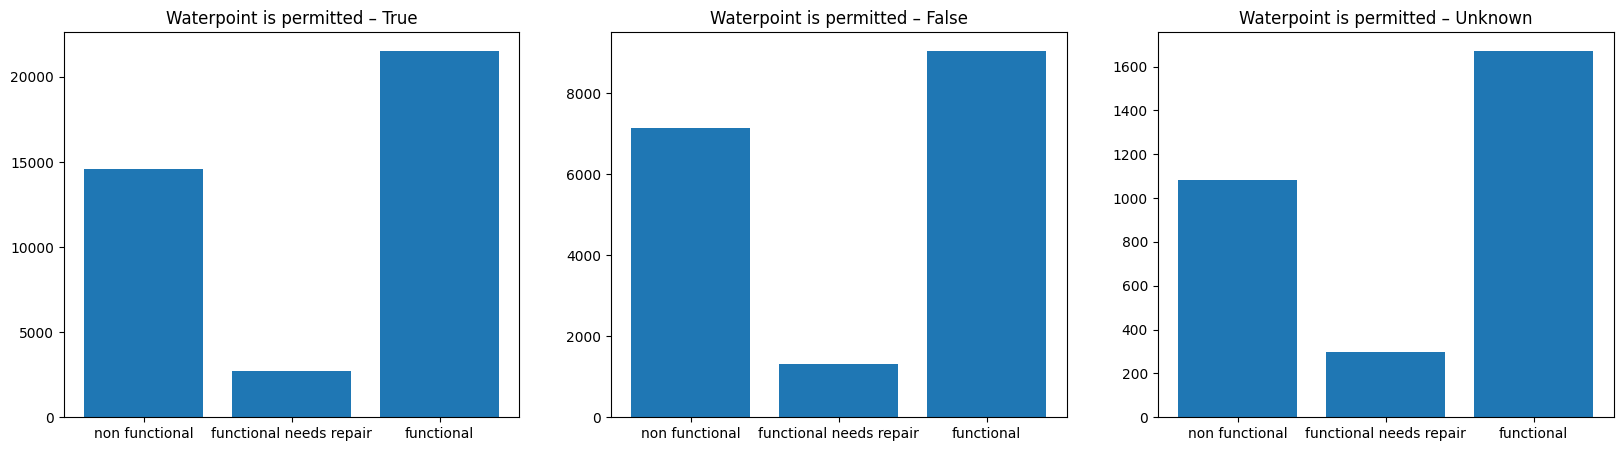

In [56]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))

values = [True, False, 'Unknown']

for i in [0,1,2]:
    copy = df.copy()
    copy = copy[copy.permit == values[i]]
    
    axes[i].bar(statuses, [len(copy[copy.status_group == x]) for x in statuses])
    axes[i].set_title('Waterpoint is permitted – {}'.format(values[i]))

In [57]:
true = df[df.permit == True].status_group.value_counts()['non functional']/len(df[df.permit == True])
false = df[df.permit == False].status_group.value_counts()['non functional']/len(df[df.permit == False])
unknown = df[df.permit == 'Unknown'].status_group.value_counts()['non functional']/len(df[df.permit == 'Unknown'])

print(f"{format(true, '.0%')} of permitted water pumps are non functional.")
print(f"{format(false, '.0%')} of unpermitted water pumps are non functional.")
print(f"{format(unknown, '.0%')} of permit-unknown water pumps are non functional.")

38% of permitted water pumps are non functional.
41% of unpermitted water pumps are non functional.
35% of permit-unknown water pumps are non functional.


In [58]:
true = df[df.permit == True].status_group.value_counts()['functional']/len(df[df.permit == True])
false = df[df.permit == False].status_group.value_counts()['functional']/len(df[df.permit == False])
unknown = df[df.permit == 'Unknown'].status_group.value_counts()['functional']/len(df[df.permit == 'Unknown'])

print(f"{format(true, '.0%')} of permitted water pumps are functional.")
print(f"{format(false, '.0%')} of unpermitted water pumps are functional.")
print(f"{format(unknown, '.0%')} of permit-unknown water pumps are functional.")

55% of permitted water pumps are functional.
52% of unpermitted water pumps are functional.
55% of permit-unknown water pumps are functional.


In [59]:
true = df[df.permit == True].status_group.value_counts()['functional needs repair']/len(df[df.permit == True])
false = df[df.permit == False].status_group.value_counts()['functional needs repair']/len(df[df.permit == False])
unknown = df[df.permit == 'Unknown'].status_group.value_counts()['functional needs repair']/len(df[df.permit == 'Unknown'])

print(f"{format(true, '.0%')} of permitted water pumps are functional but need repair.")
print(f"{format(false, '.0%')} of unpermitted water pumps are functional but need repair.")
print(f"{format(unknown, '.0%')} of permit-unknown water pumps are functional but need repair.")

7% of permitted water pumps are functional but need repair.
8% of unpermitted water pumps are functional but need repair.
10% of permit-unknown water pumps are functional but need repair.


# construction_year – Year the waterpoint was constructed

I don't see any reason to think this variable is useful, unless there is a specific year with the vast majority of pumps in one status category or another, or if there is a linear relationship between year constructed and amount of pumps either dysfunctional or needing repair. This makes sense, because the older a pump is, the more wear and tear it will experience.

These pumps range from being constructed in 1966 to 2010. Many of these pumps have unknown construction dates.

You can see from the distributions that non functional pumps are more likely to come from earlier years than later years. Likewise, functional pumps are more likely to be recently made than not. Pumps that need repair are also more likely to be old; they seem to be in between non functional and functional pumps, which is what you'd expect.

In [60]:
df.construction_year.value_counts()

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

<BarContainer object of 54 artists>

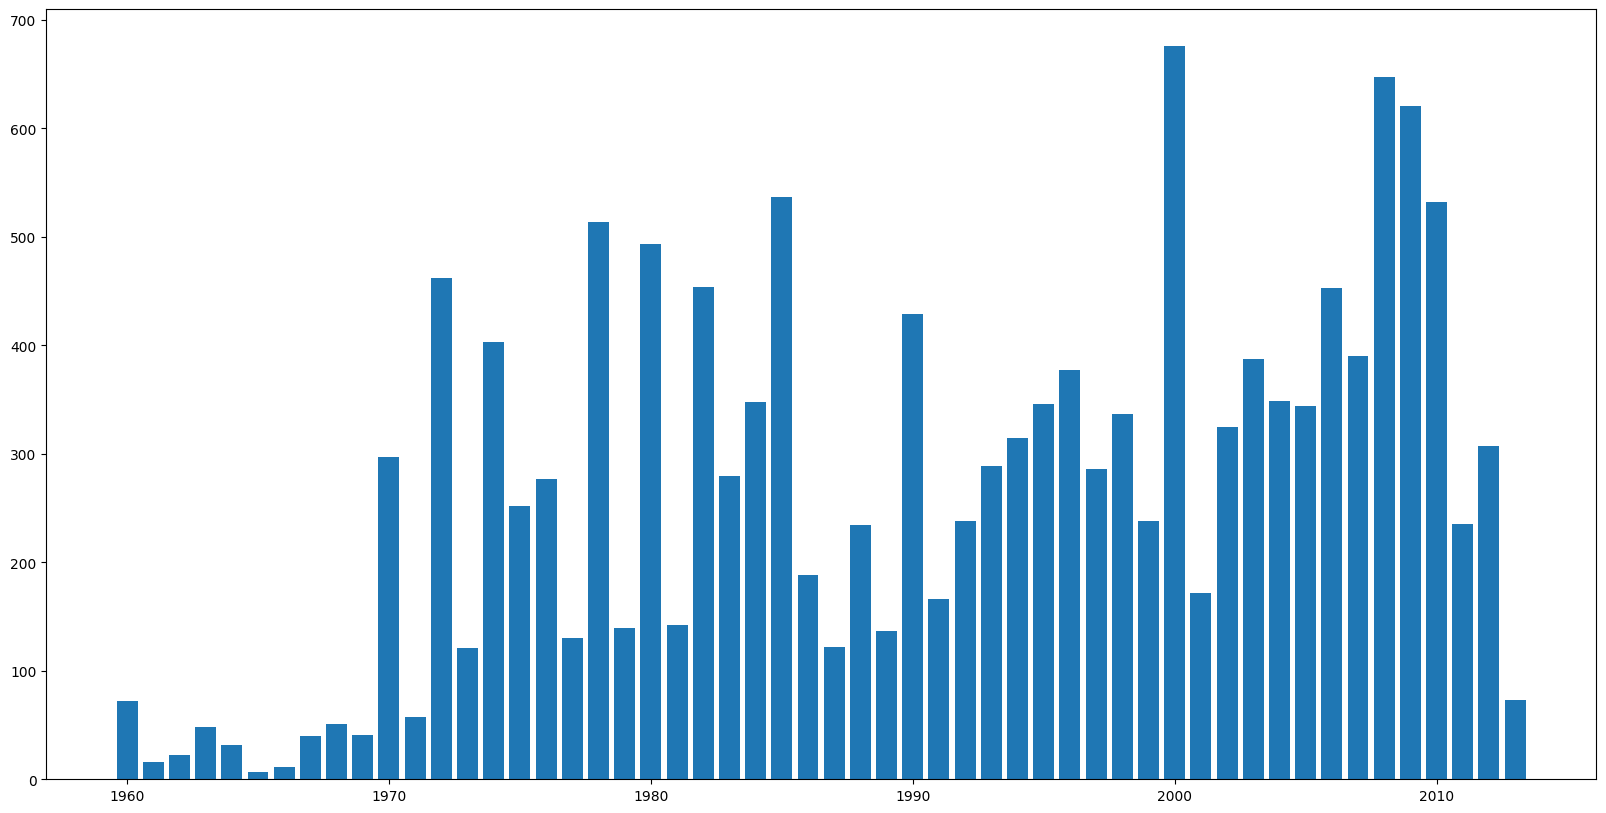

In [61]:
fig, ax = plt.subplots(figsize=(20,10))
copy = df.copy()
copy = copy[(copy.status_group == 'non functional') & (copy.construction_year != 0)]
year_value_counts = dict(copy.construction_year.value_counts())
ax.bar(year_value_counts.keys(), year_value_counts.values())

<BarContainer object of 53 artists>

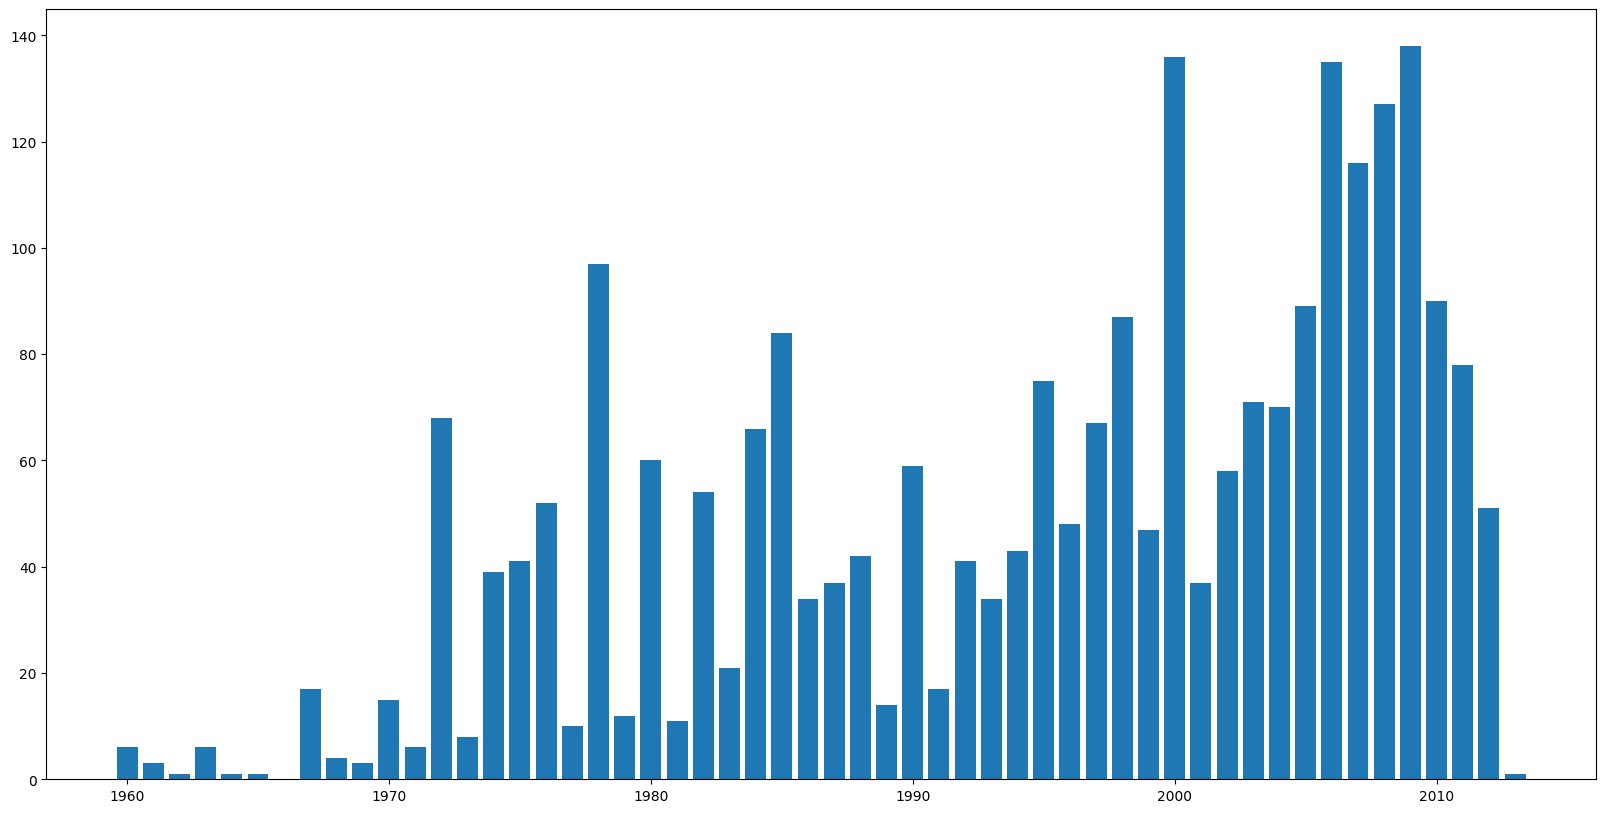

In [62]:
fig, ax = plt.subplots(figsize=(20,10))
copy = df.copy()
copy = copy[(copy.status_group == 'functional needs repair') & (copy.construction_year != 0)]
year_value_counts = dict(copy.construction_year.value_counts())
ax.bar(year_value_counts.keys(), year_value_counts.values())

<BarContainer object of 54 artists>

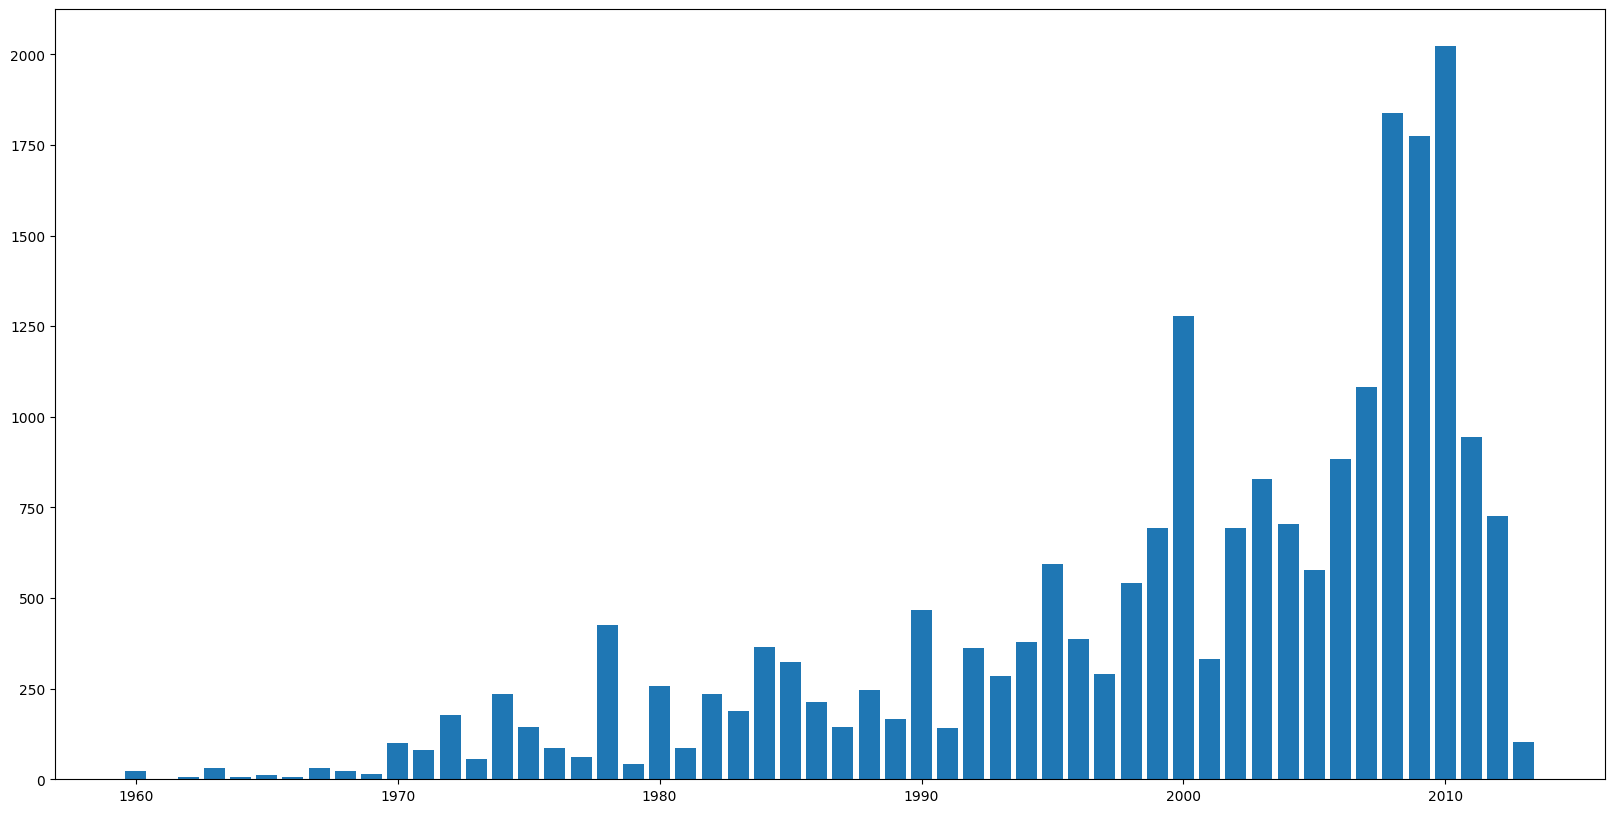

In [63]:
fig, ax = plt.subplots(figsize=(20,10))
copy = df.copy()
copy = copy[(copy.status_group == 'functional') & (copy.construction_year != 0)]
year_value_counts = dict(copy.construction_year.value_counts())
ax.bar(year_value_counts.keys(), year_value_counts.values())

# extraction_type – the kind of extraction the waterpoint uses

There seem to be several categories that should be lumped in with "other", such as "other-play pump", "other-mkulima/shinyanga", etc.

In [64]:
df.extraction_type.value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [65]:
df.extraction_type.replace({'other - rope pump': 'other', 'other - swn 81': 'other', 'other - play pump': 'other', 'other - mkulima/shinyanga': 'other'}, inplace=True)

In [66]:
df.extraction_type.nunique()

14

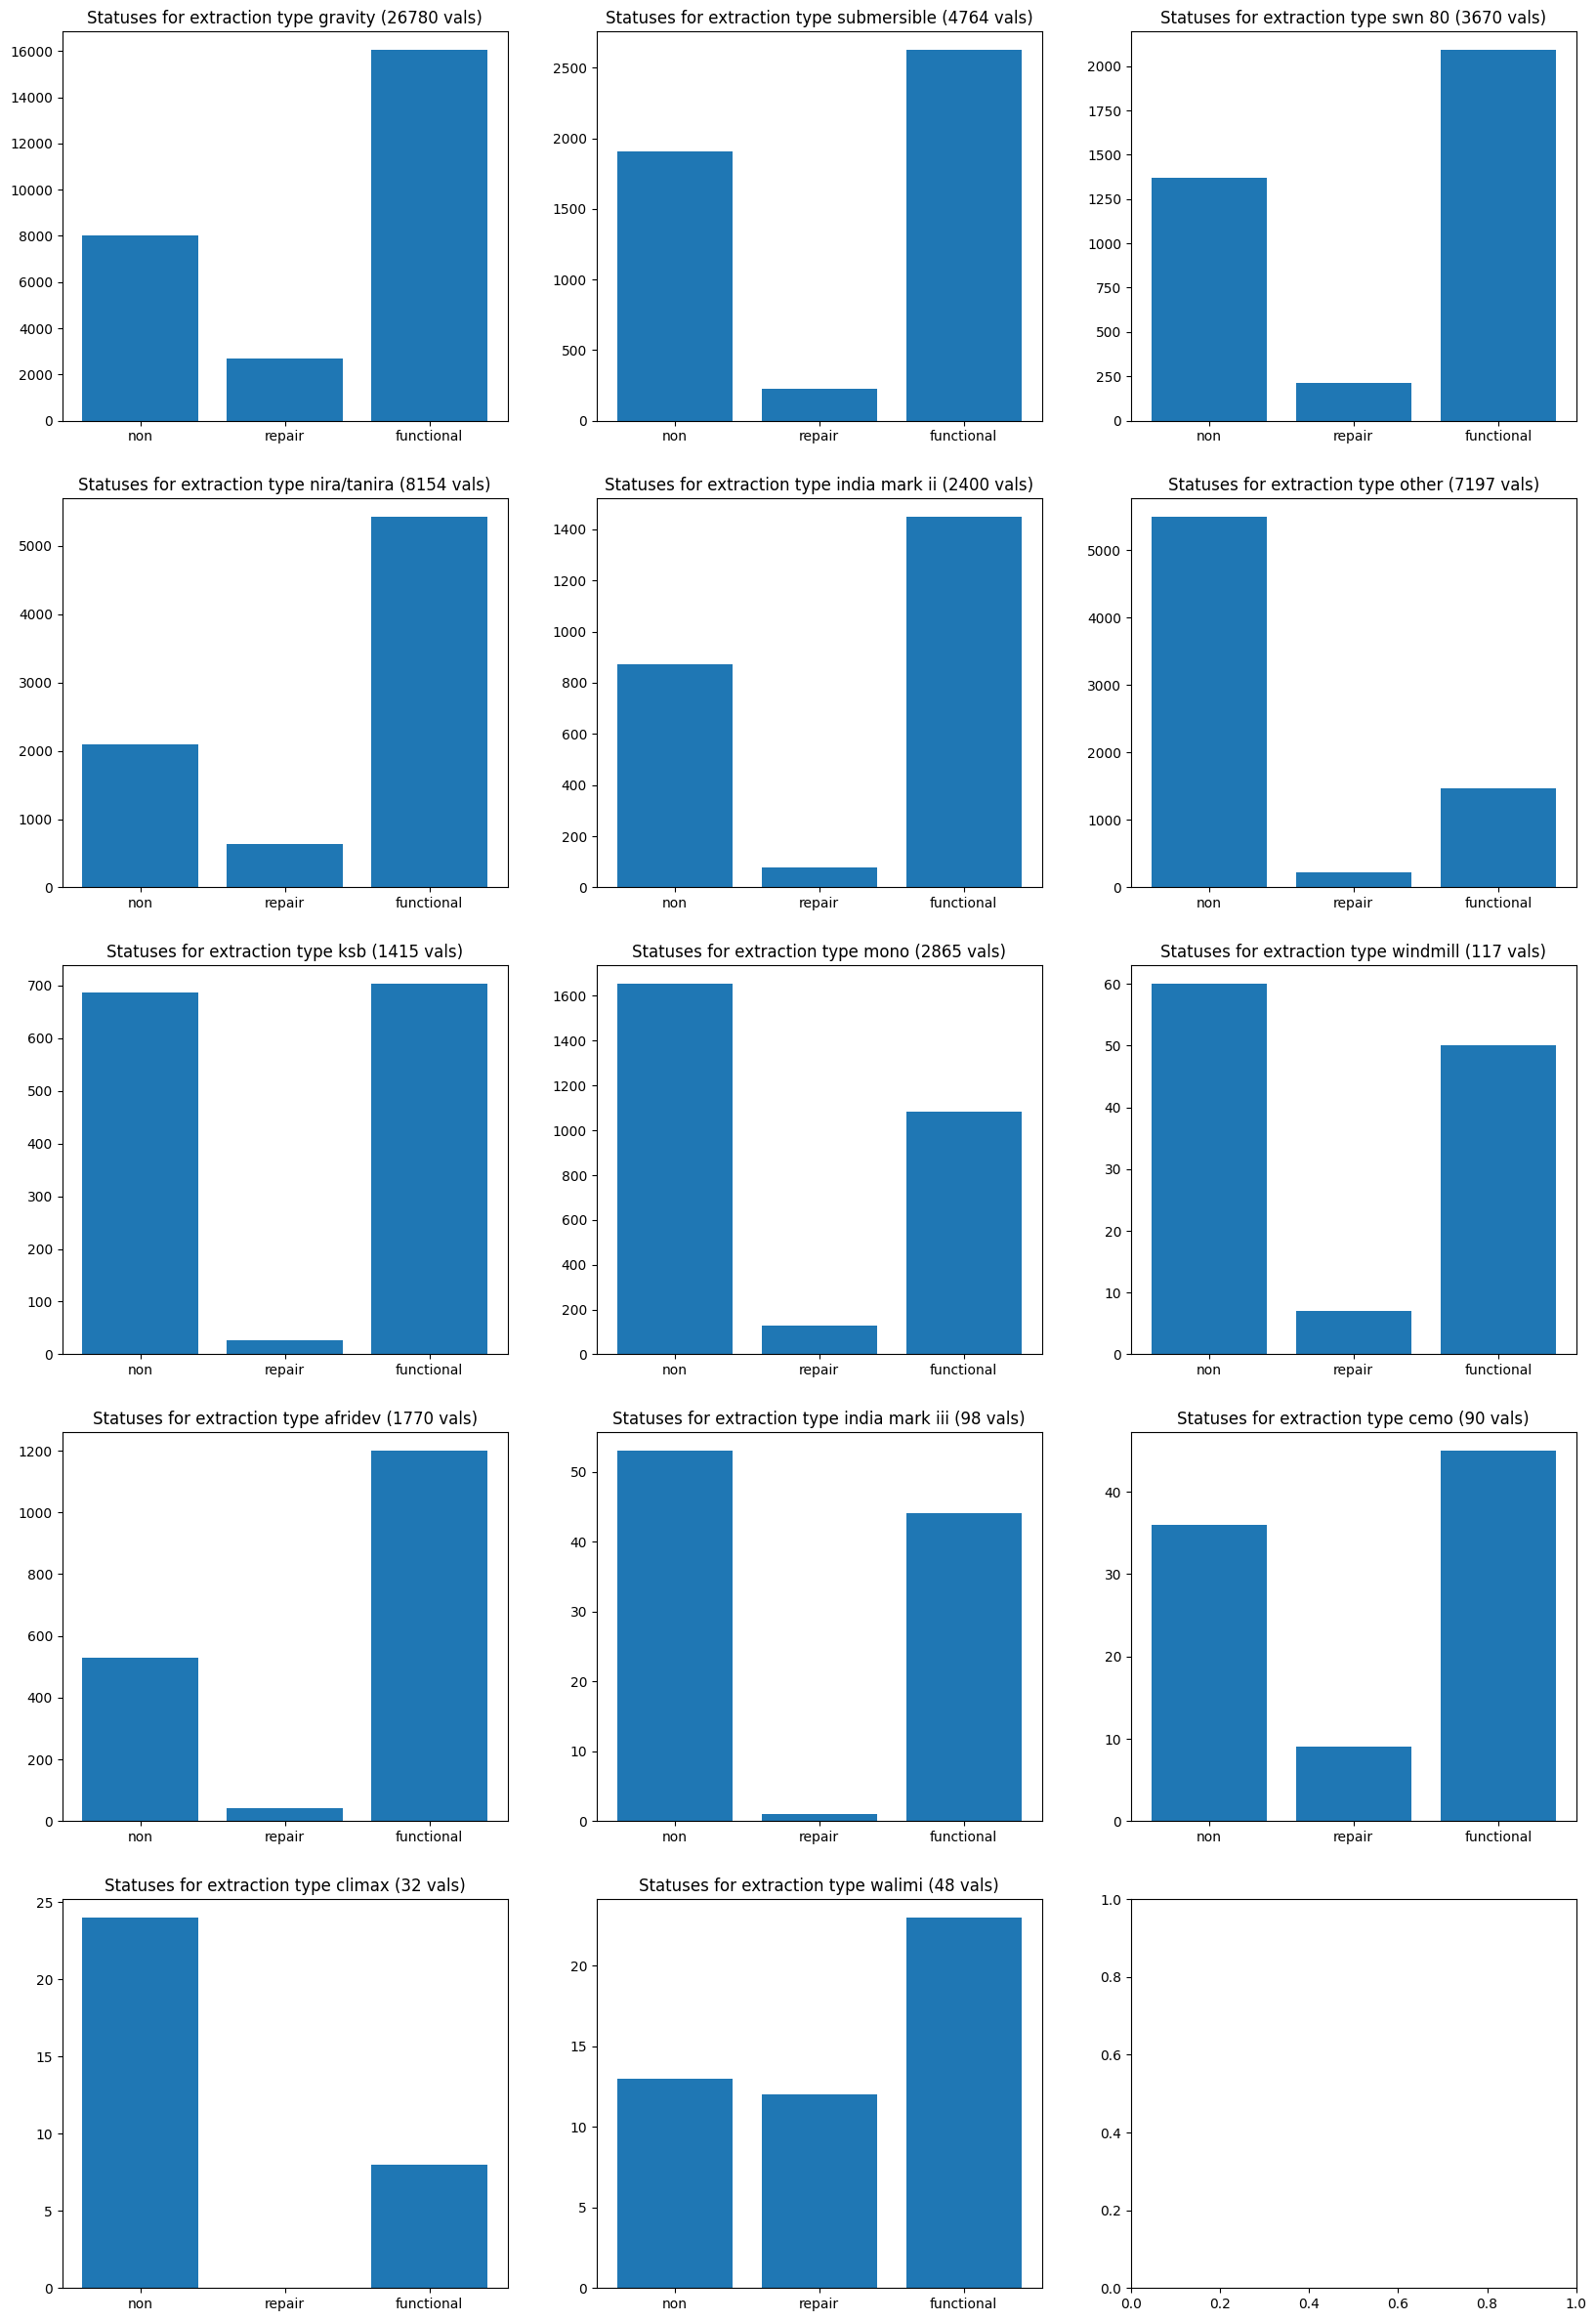

In [67]:
types = df.extraction_type.unique()

fig, axes = plt.subplots(5,3, figsize=(20,30))

for i in range(14):
    
    row = i//3
    col=i%3
    
    copy = df.copy()
    copy = copy[copy.extraction_type == types[i]]
    
    axes[row][col].bar(['non', 'repair', 'functional'], [len(copy[copy.status_group == i]) for i in statuses])
    axes[row][col].set_title("Statuses for extraction type {} ({} vals)".format(types[i], len(copy)))

# extraction_type_group – The kind of extraction the waterpoint uses

Again, with the redundant variable names. There are 13 unique values as opposed to our collapsed 14.

In [68]:
df.extraction_type_group.value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2
3 0
3 1
3 2
4 0


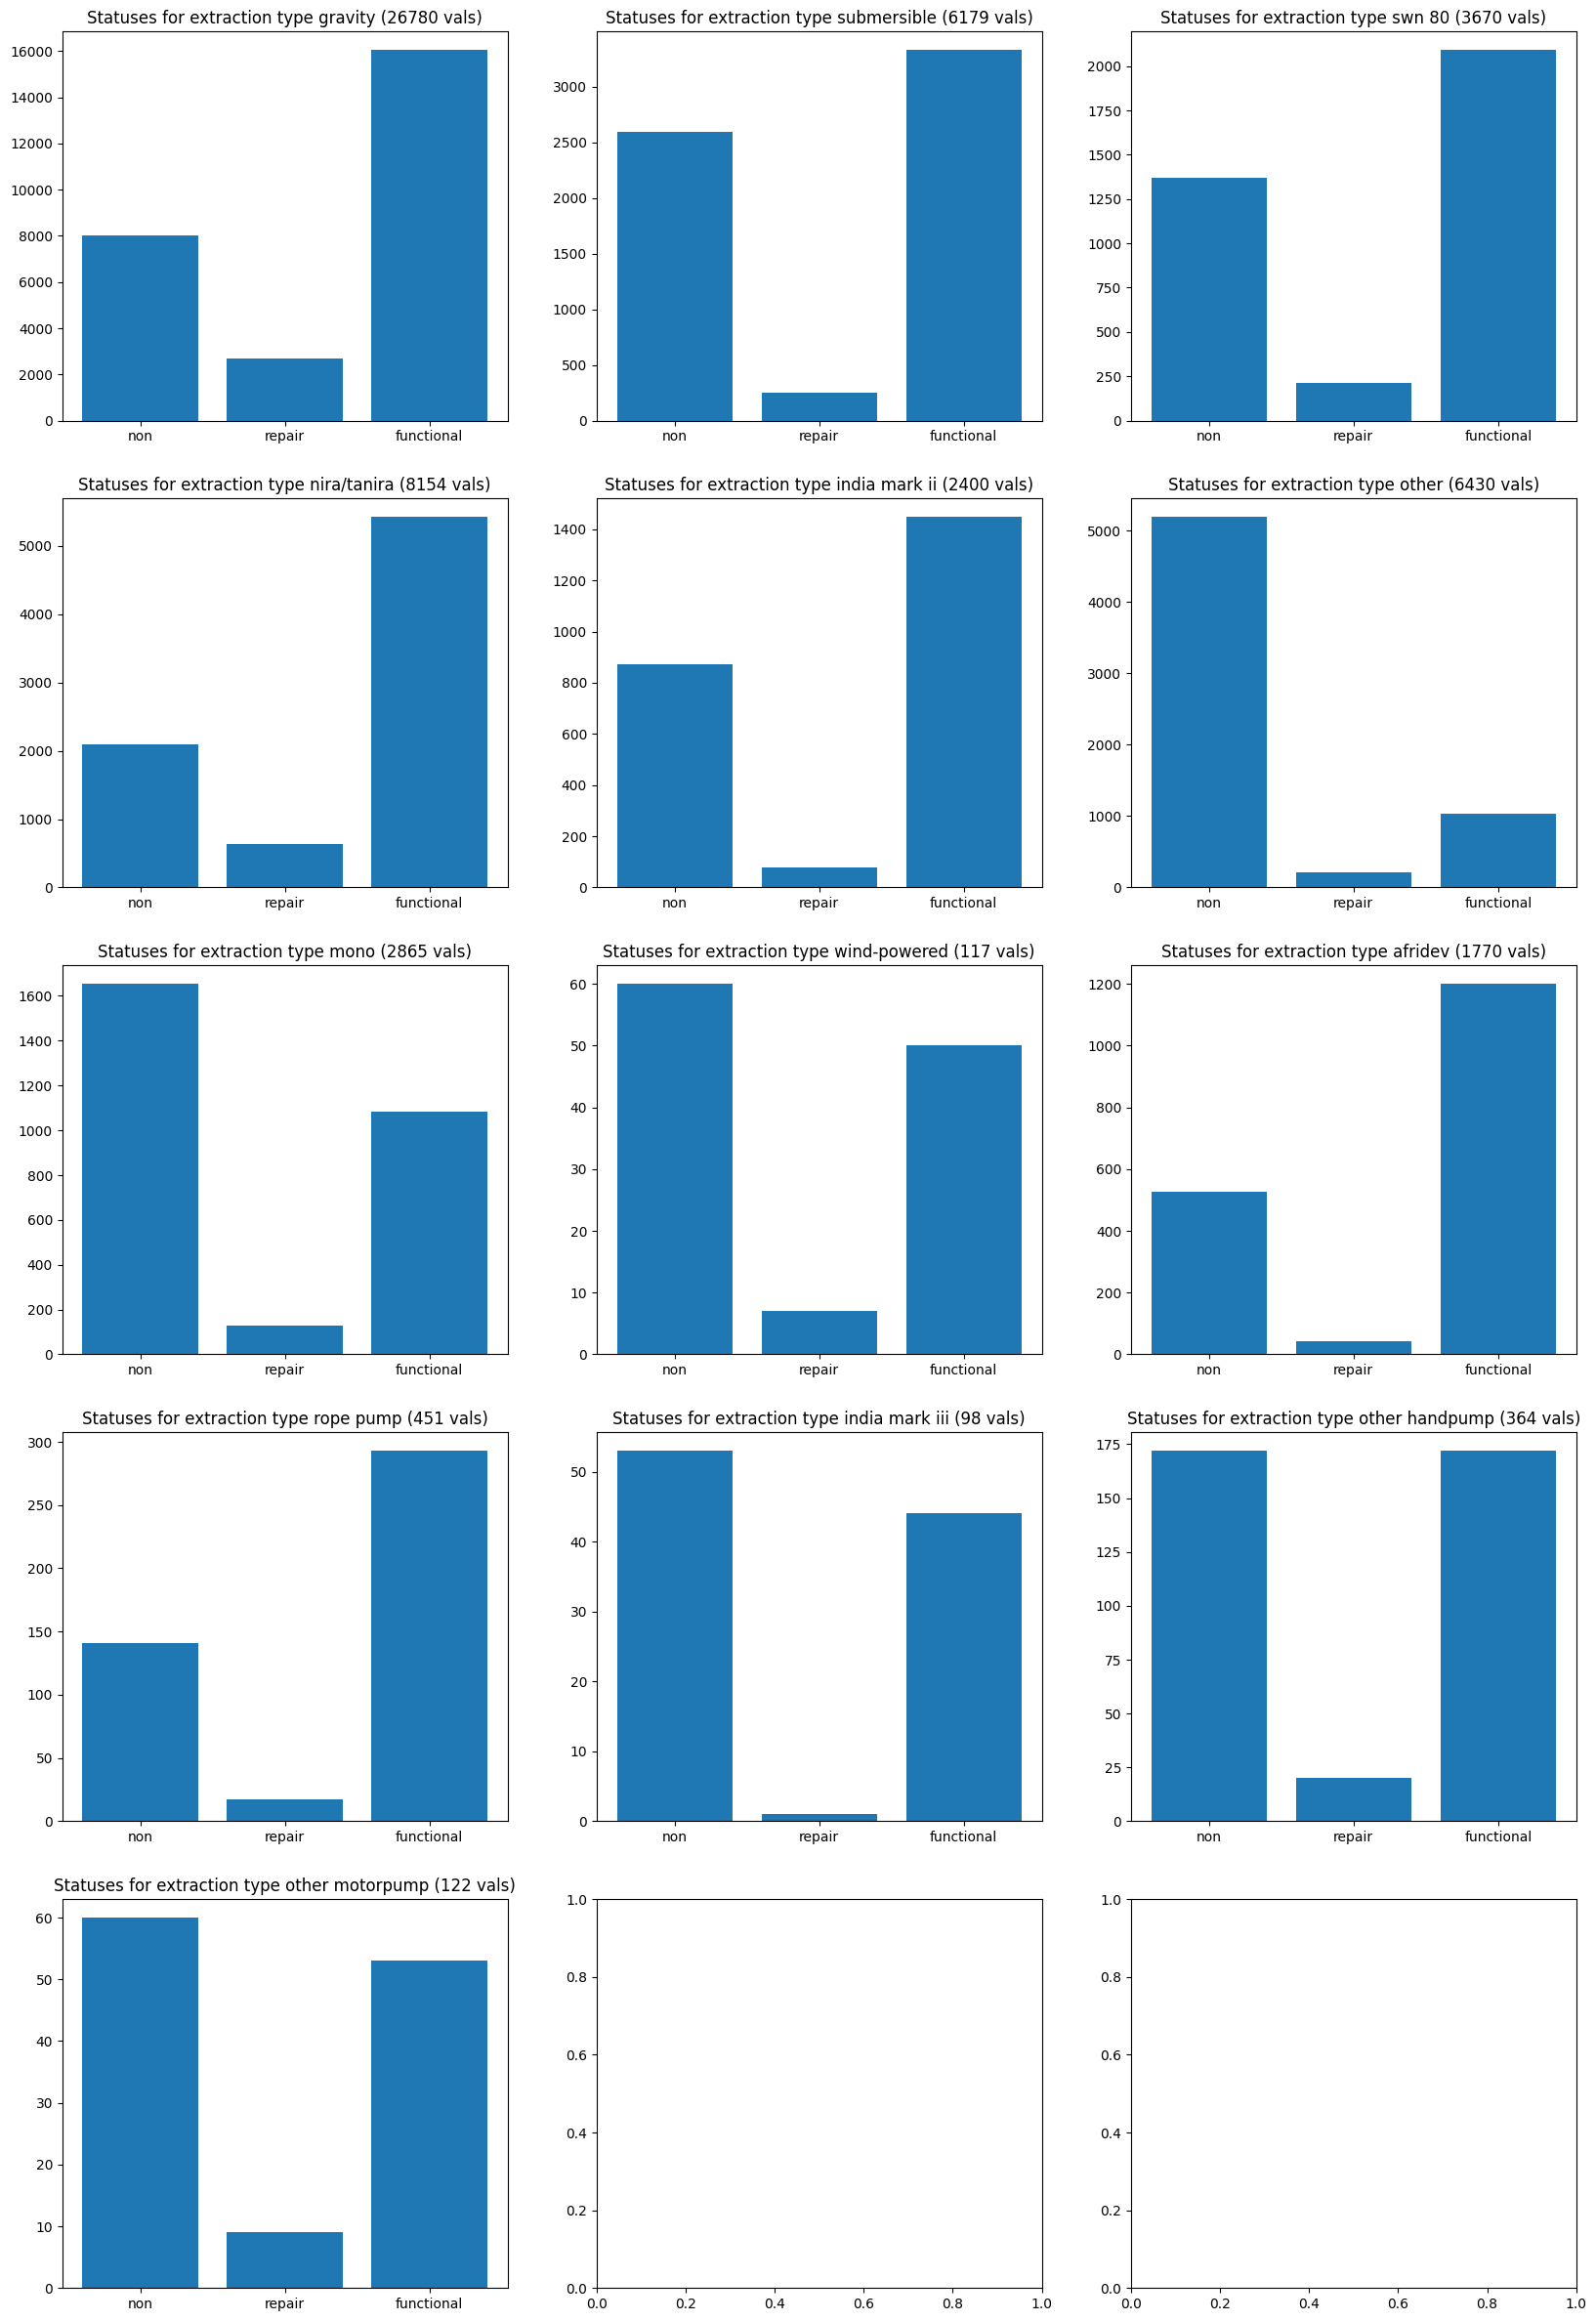

In [69]:
types = df.extraction_type_group.unique()

fig, axes = plt.subplots(5,3, figsize=(20,30))

for i in range(13):
    
    row = i//3
    col=i%3
    
    copy = df.copy()
    copy = copy[copy.extraction_type_group == types[i]]
    
    print(row,col)
    
    axes[row][col].bar(['non', 'repair', 'functional'], [len(copy[copy.status_group == i]) for i in statuses])
    axes[row][col].set_title("Statuses for extraction type {} ({} vals)".format(types[i], len(copy)))

# extraction_type_class – The kind of extraction the waterpoint uses

Only 7 unique values this time.

In [70]:
df.extraction_type_class.value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

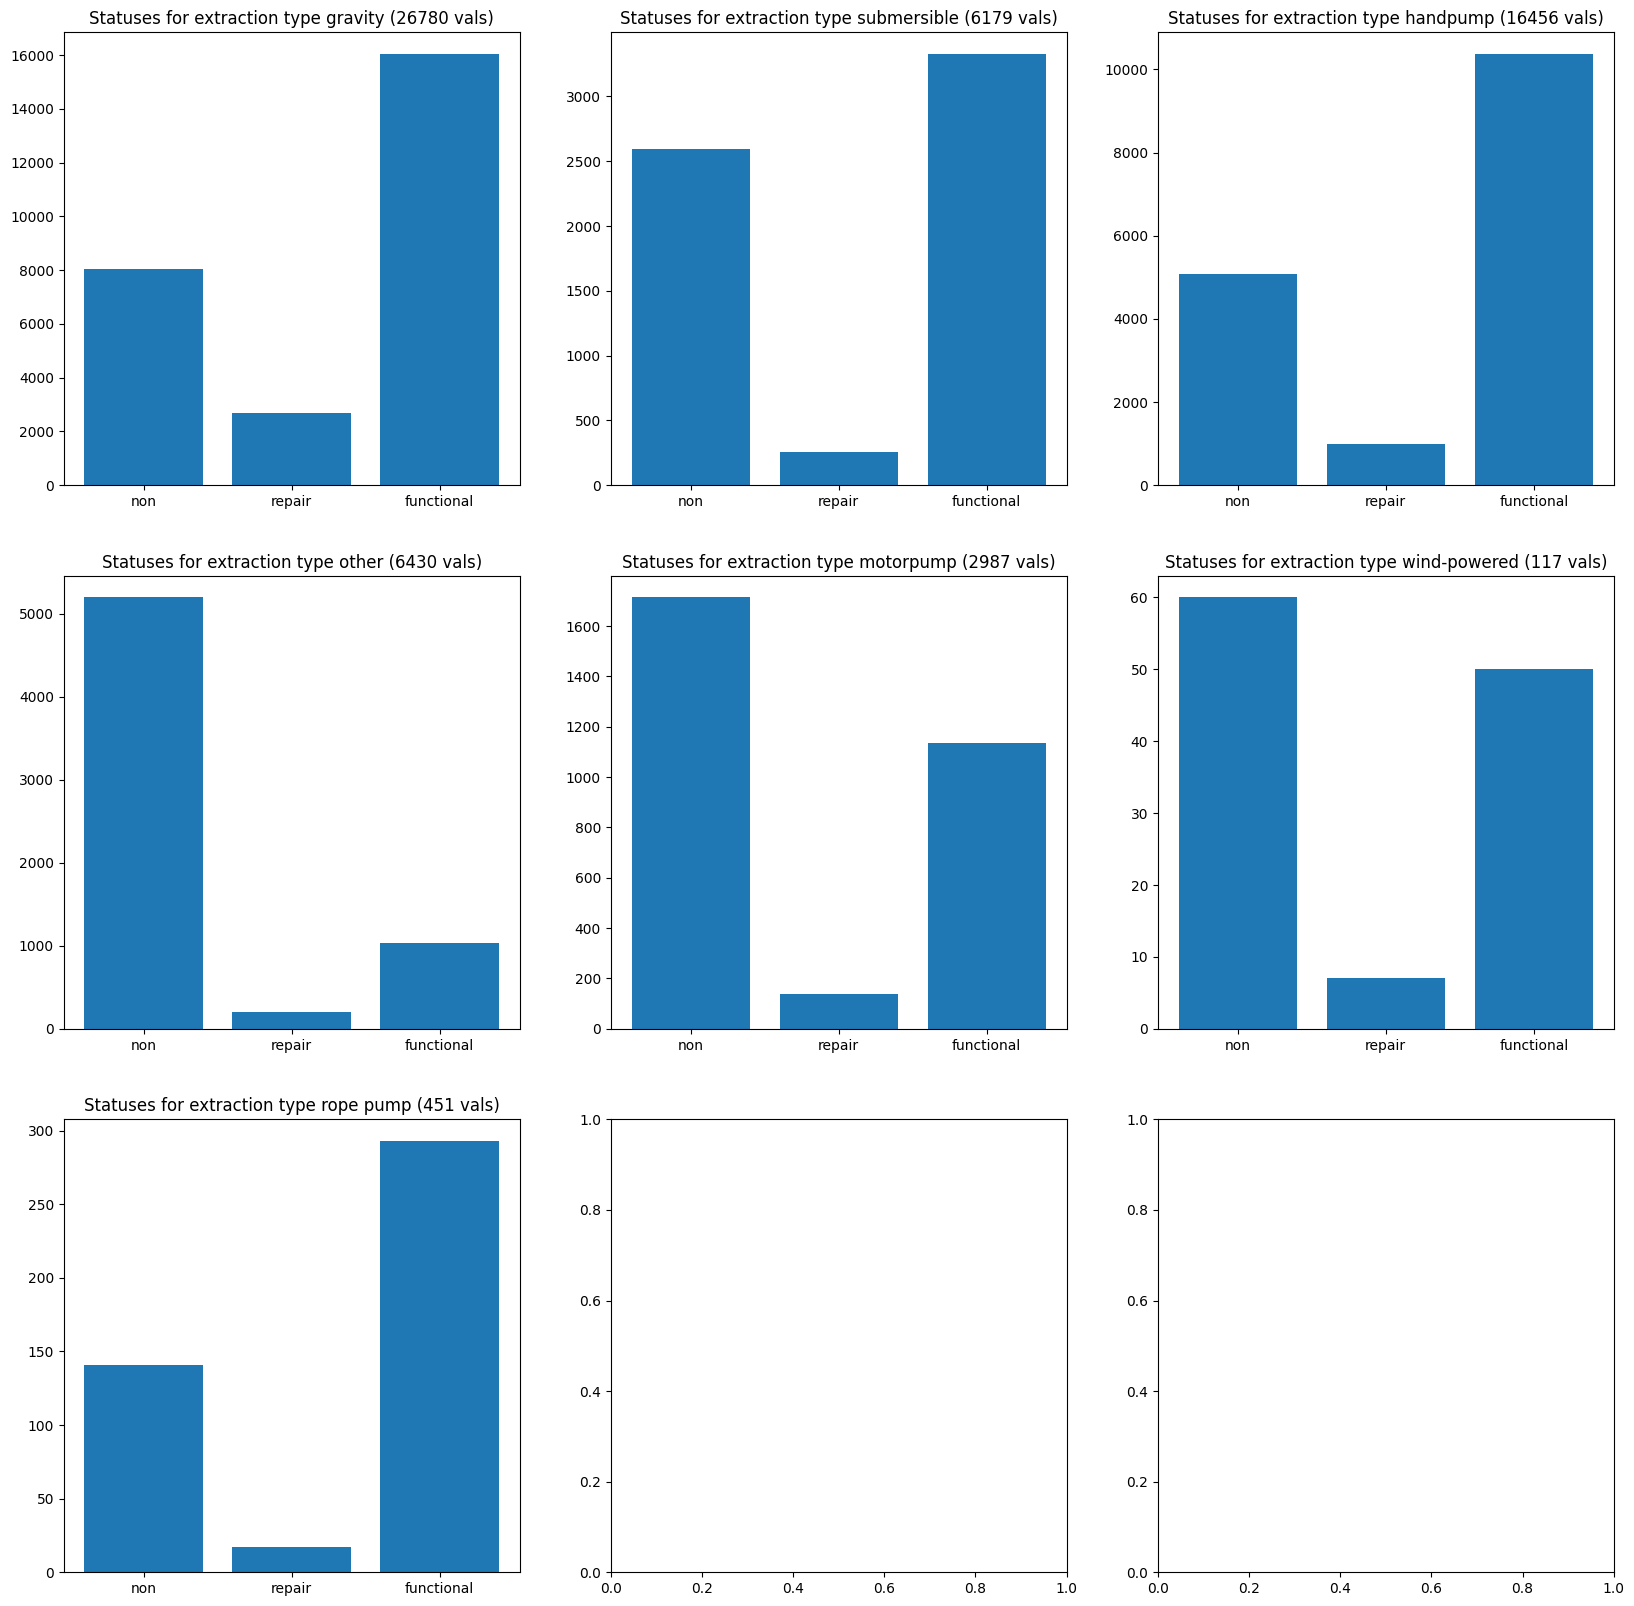

In [71]:
types = df.extraction_type_class.unique()

fig, axes = plt.subplots(3,3, figsize=(20,20))

for i in range(7):
    
    row = i//3
    col=i%3
    
    copy = df.copy()
    copy = copy[copy.extraction_type_class == types[i]]
    
    axes[row][col].bar(['non', 'repair', 'functional'], [len(copy[copy.status_group == i]) for i in statuses])
    axes[row][col].set_title("Statuses for extraction type {} ({} vals)".format(types[i], len(copy)))

# management – How the waterpoint is managed

Is this closely related to "scheme-management" and the other "who operates the waterpoint" variables?

Might want to collapse the other and other-school categories. On second thought, don't.

In [72]:
df.management.value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

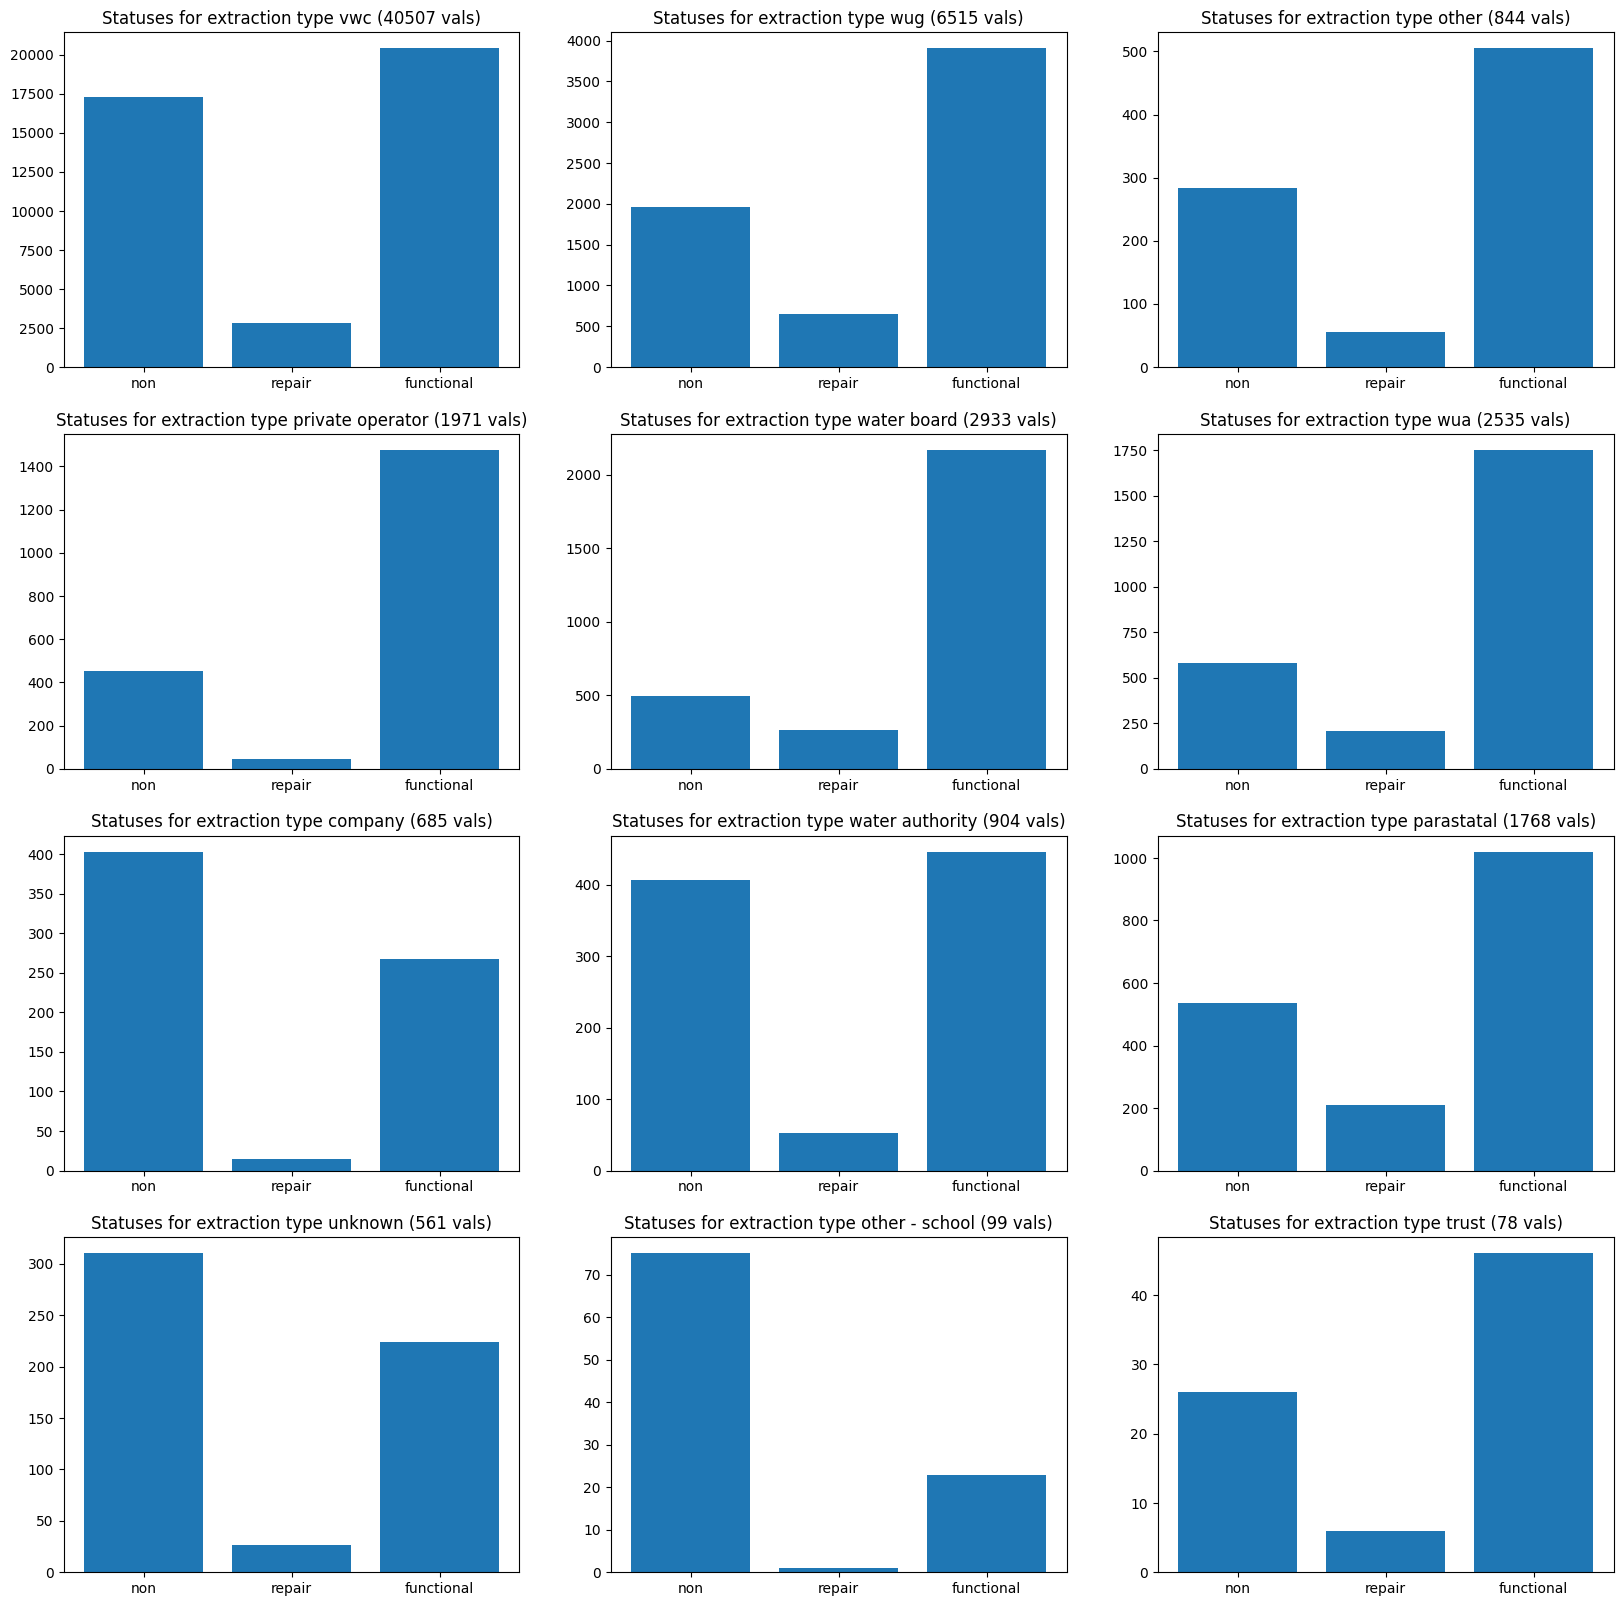

In [73]:
managers = df.management.unique()

fig, axes = plt.subplots(4,3, figsize=(20,20))

for i in range(12):
    
    row = i//3
    col=i%3
    
    copy = df.copy()
    copy = copy[copy.management == managers[i]]
    
    axes[row][col].bar(['non', 'repair', 'functional'], [len(copy[copy.status_group == i]) for i in statuses])
    axes[row][col].set_title("Statuses for extraction type {} ({} vals)".format(managers[i], len(copy)))

# management_group – How the waterpoint is managed

For reference, 'parastatal' means 'having some political authority and/or serving the state indirectly.'

In [74]:
df.management_group.value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

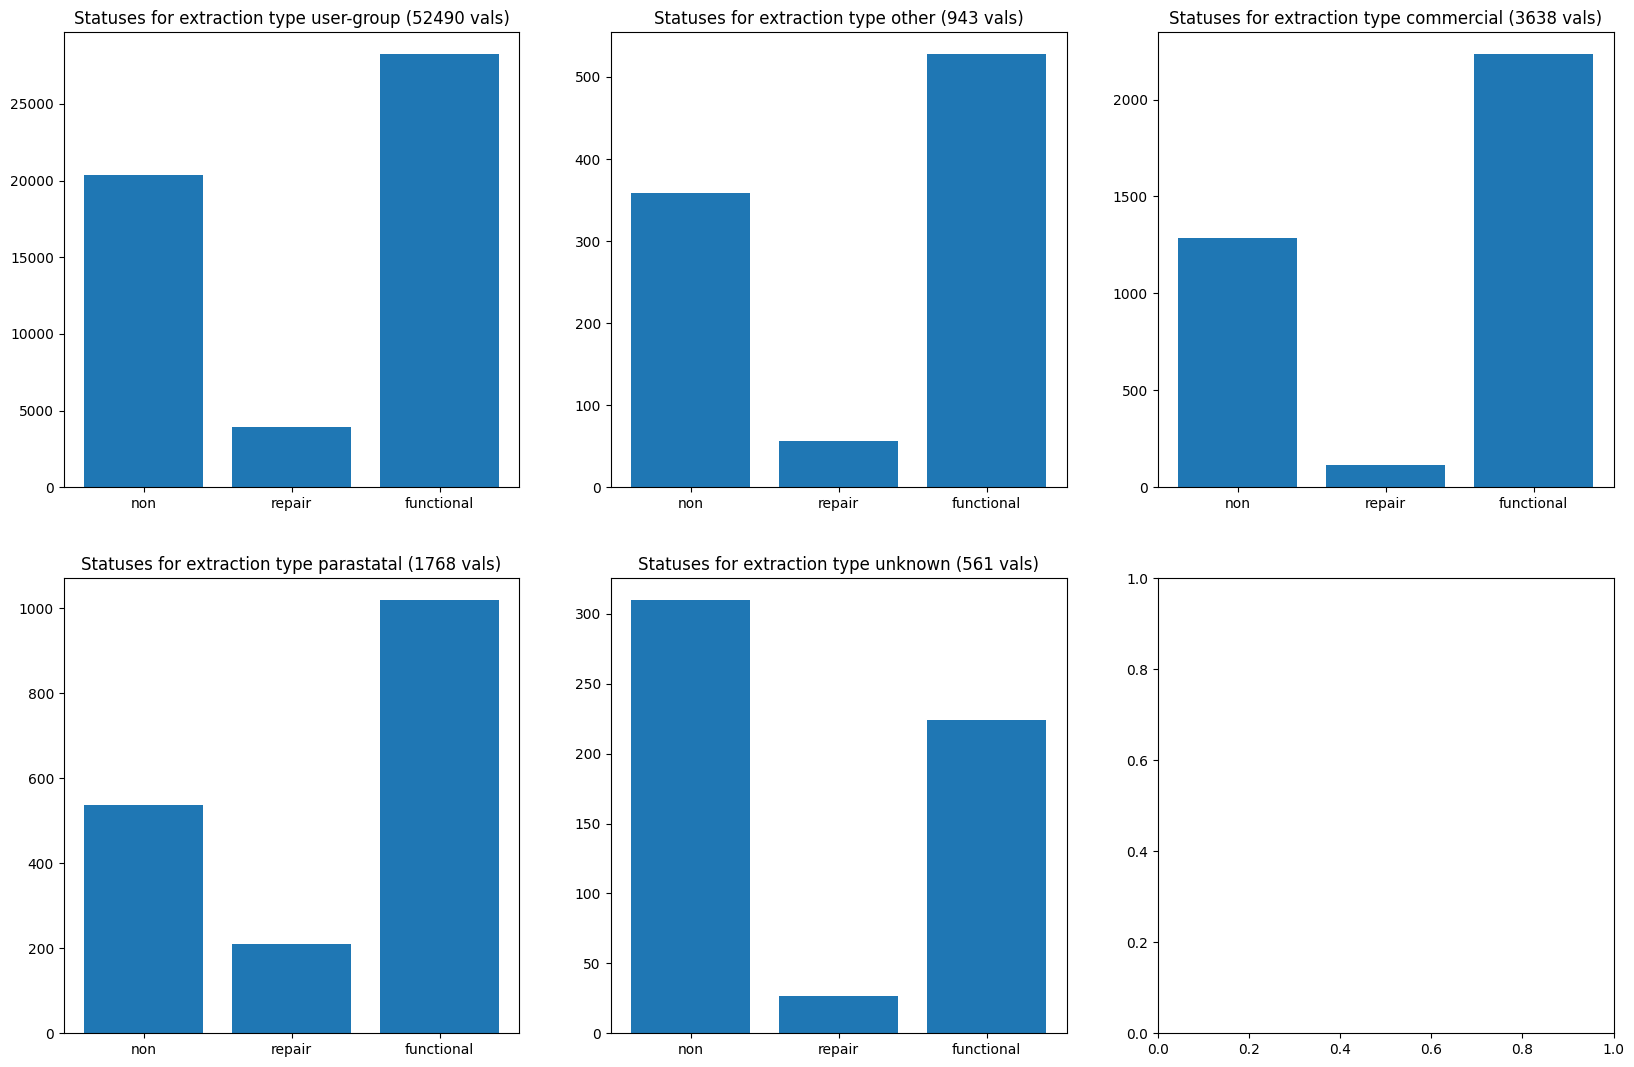

In [75]:
managers = df.management_group.unique()

fig, axes = plt.subplots(2,3, figsize=(20,13))

for i in range(5):
    
    row = i//3
    col=i%3
    
    copy = df.copy()
    copy = copy[copy.management_group == managers[i]]
    
    axes[row][col].bar(['non', 'repair', 'functional'], [len(copy[copy.status_group == i]) for i in statuses])
    axes[row][col].set_title("Statuses for extraction type {} ({} vals)".format(managers[i], len(copy)))

# payment – What the water costs

In [76]:
df.payment.value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

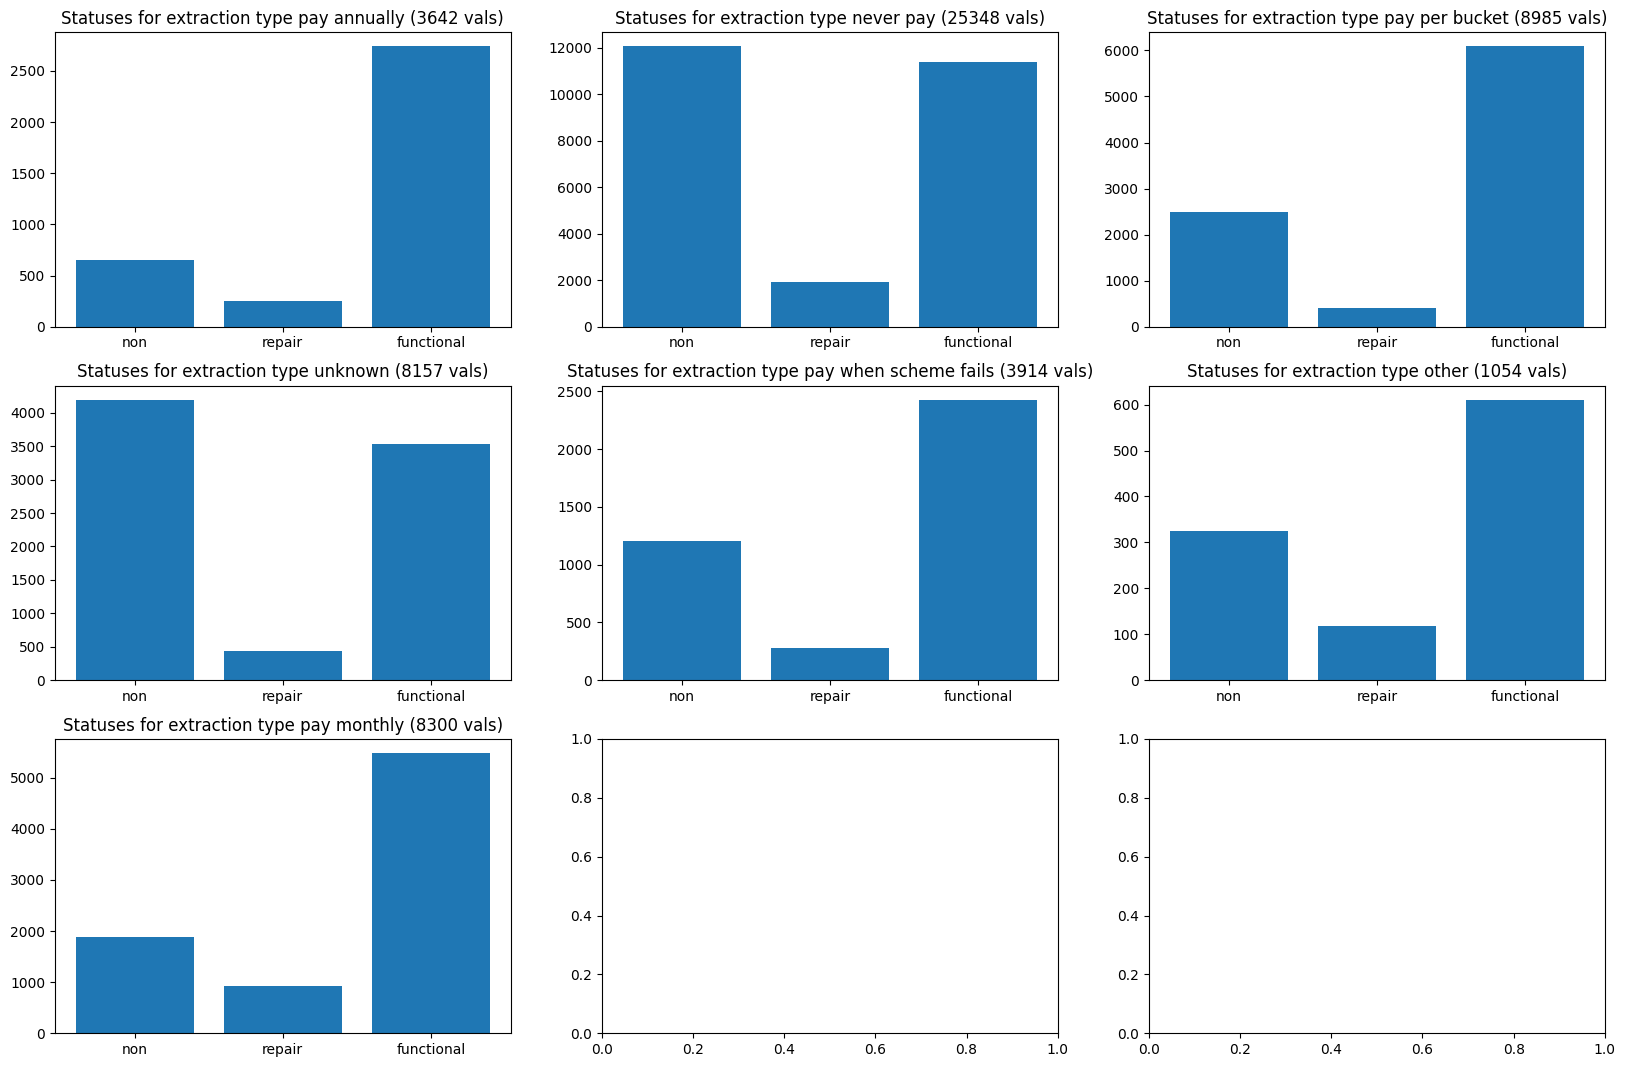

In [77]:
payments = df.payment.unique()

fig, axes = plt.subplots(3,3, figsize=(20,13))

for i in range(7):
    
    row = i//3
    col=i%3
    
    copy = df.copy()
    copy = copy[copy.payment == payments[i]]
    
    axes[row][col].bar(['non', 'repair', 'functional'], [len(copy[copy.status_group == i]) for i in statuses])
    axes[row][col].set_title("Statuses for extraction type {} ({} vals)".format(payments[i], len(copy)))

# payment_type – What the water costs

IGNORE!!!!!

In [78]:
df.payment_type.value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

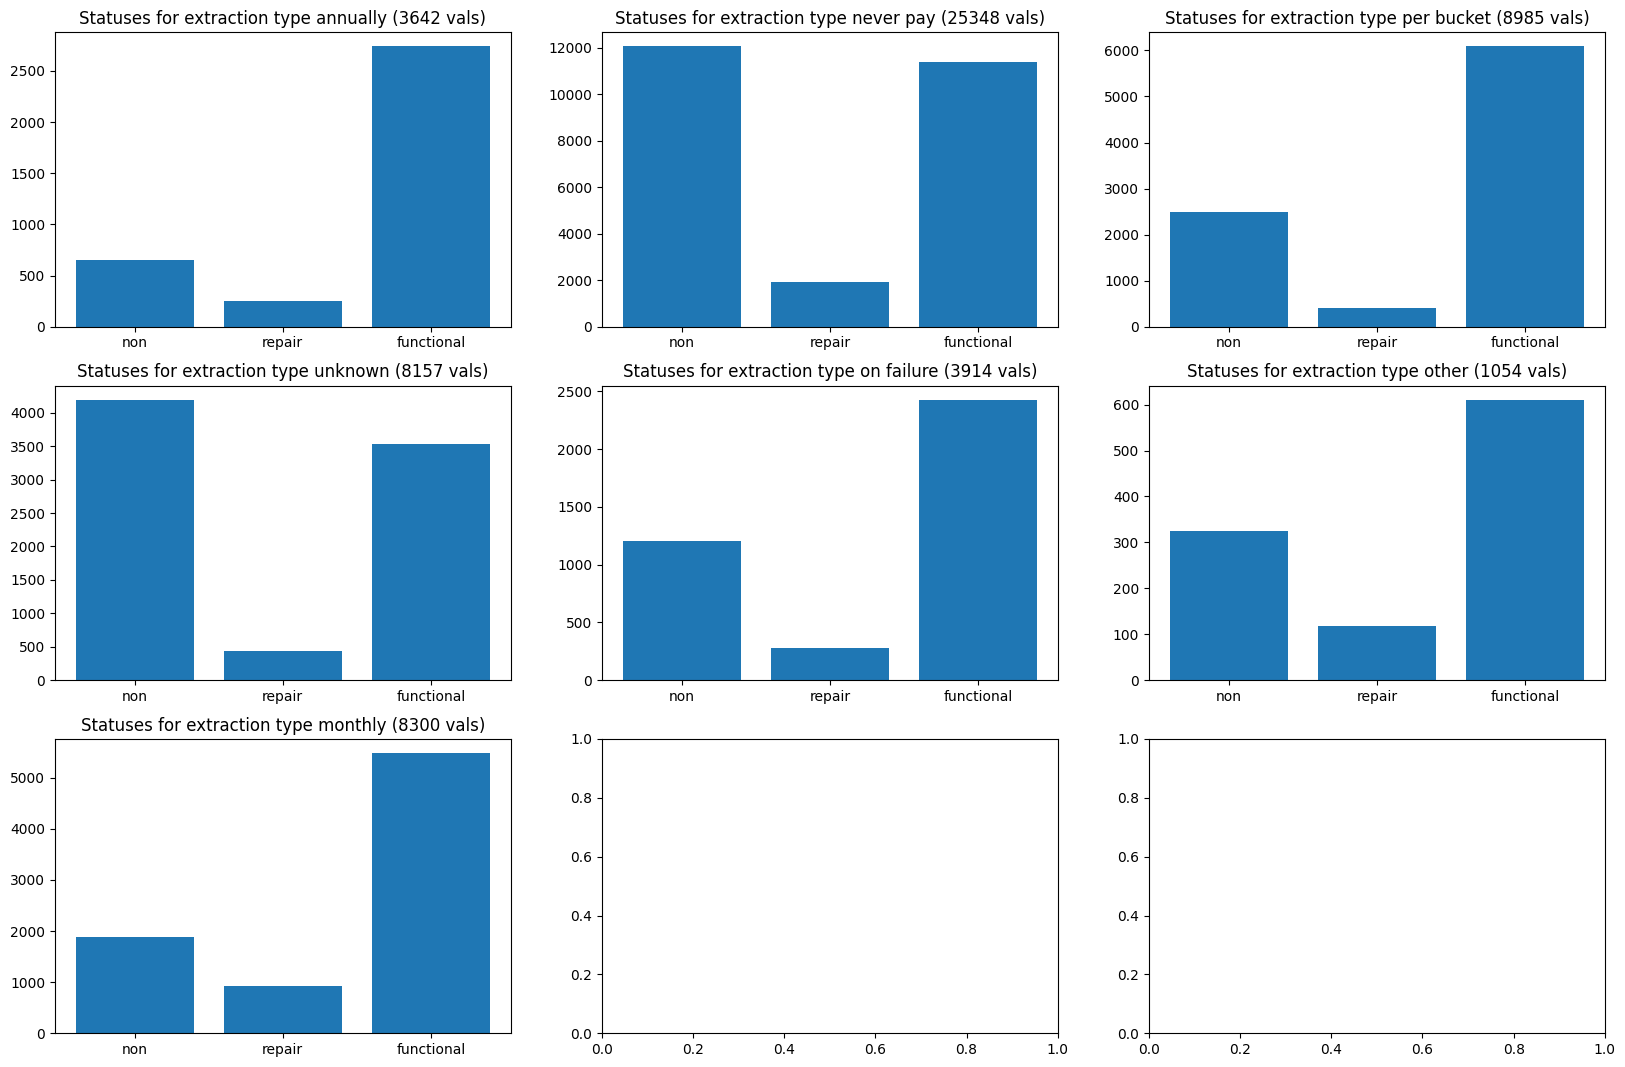

In [79]:
payments = df.payment_type.unique()

fig, axes = plt.subplots(3,3, figsize=(20,13))

for i in range(7):
    
    row = i//3
    col=i%3
    
    copy = df.copy()
    copy = copy[copy.payment_type == payments[i]]
    
    axes[row][col].bar(['non', 'repair', 'functional'], [len(copy[copy.status_group == i]) for i in statuses])
    axes[row][col].set_title("Statuses for extraction type {} ({} vals)".format(payments[i], len(copy)))

# water_quality – The quality of the water

In [80]:
df.water_quality.value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

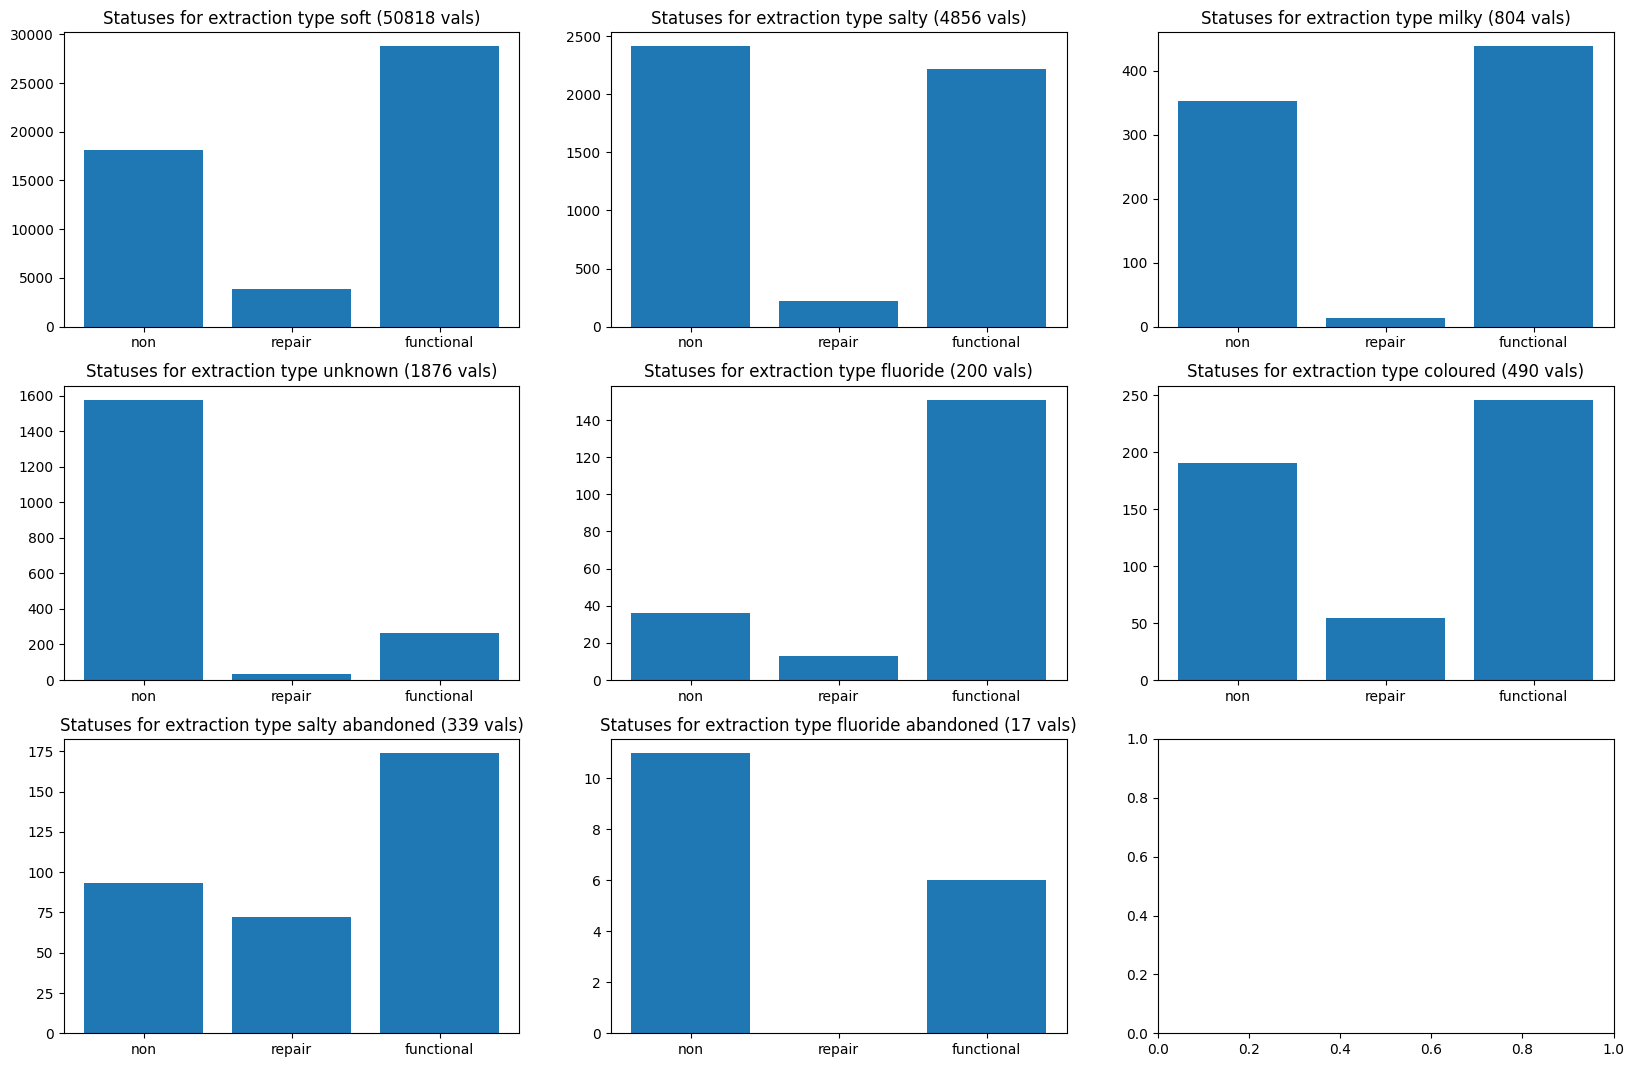

In [81]:
qualities = df.water_quality.unique()

fig, axes = plt.subplots(3,3, figsize=(20,13))

for i in range(8):
    
    row = i//3
    col=i%3
    
    copy = df.copy()
    copy = copy[copy.water_quality == qualities[i]]
    
    axes[row][col].bar(['non', 'repair', 'functional'], [len(copy[copy.status_group == i]) for i in statuses])
    axes[row][col].set_title("Statuses for extraction type {} ({} vals)".format(qualities[i], len(copy)))

# quality_group – The quality of the water

In [82]:
df.quality_group.value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

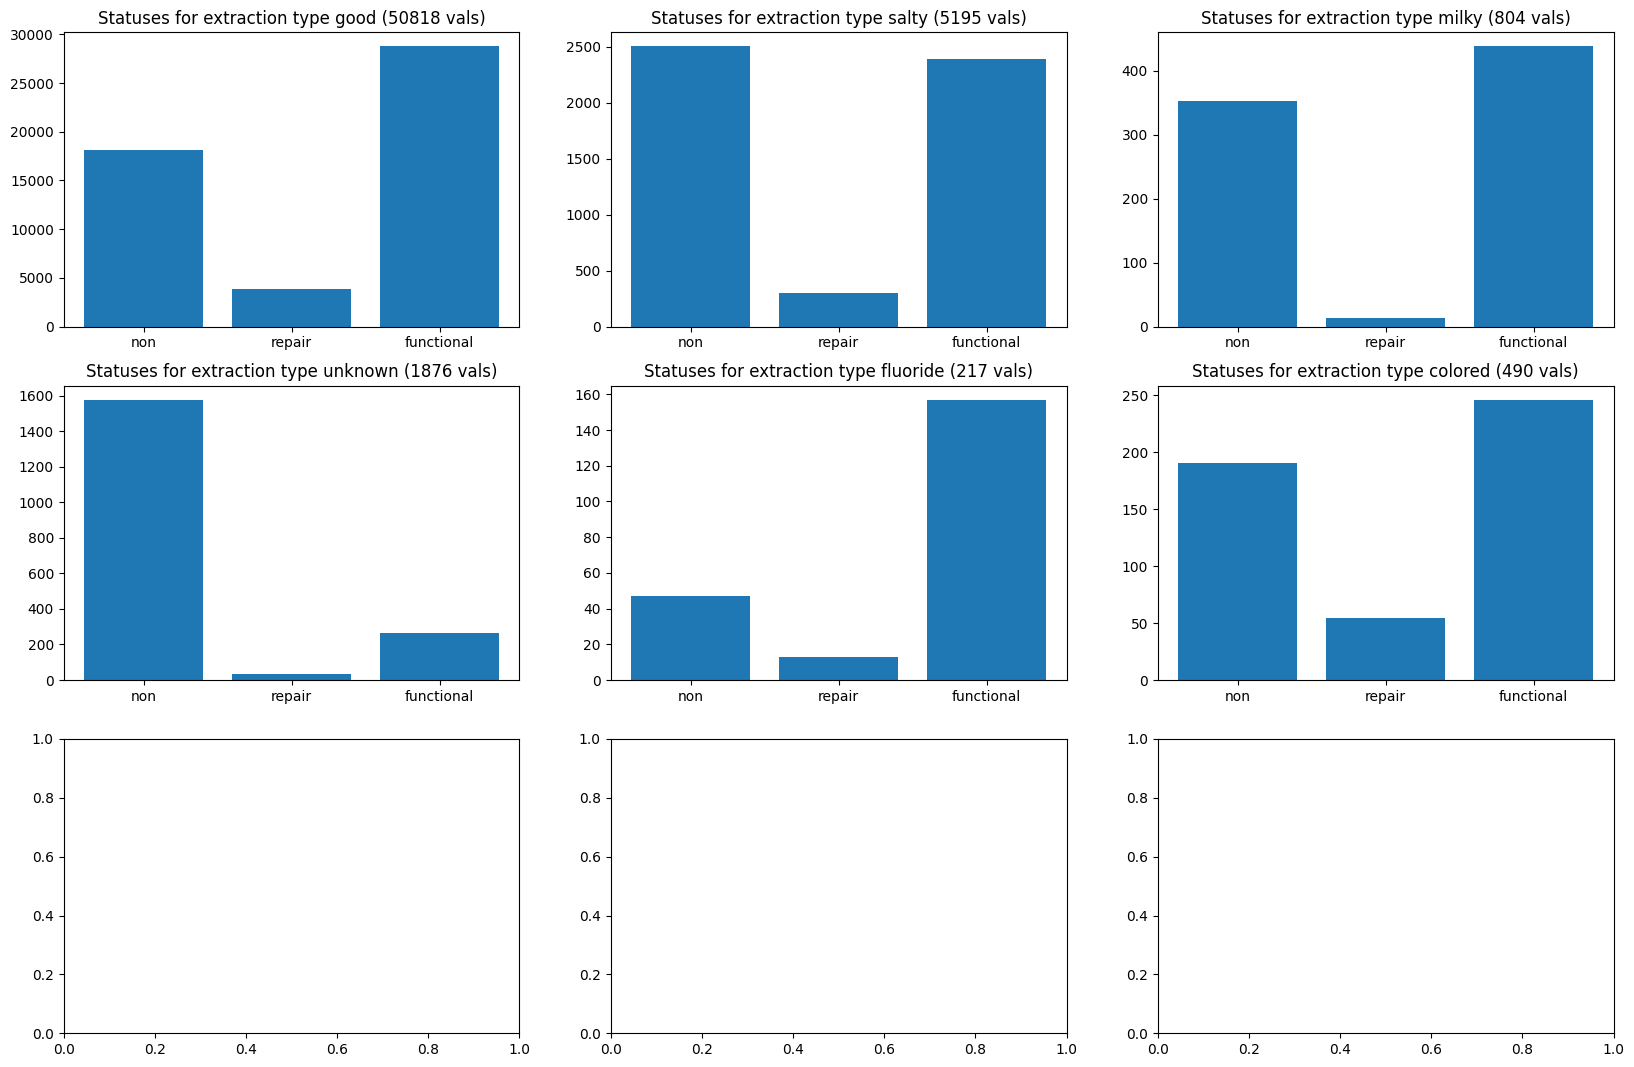

In [83]:
qualities = df.quality_group.unique()

fig, axes = plt.subplots(3,3, figsize=(20,13))

for i in range(6):
    
    row = i//3
    col=i%3
    
    copy = df.copy()
    copy = copy[copy.quality_group == qualities[i]]
    
    axes[row][col].bar(['non', 'repair', 'functional'], [len(copy[copy.status_group == i]) for i in statuses])
    axes[row][col].set_title("Statuses for extraction type {} ({} vals)".format(qualities[i], len(copy)))

# quantity – The quantity of the water

In [84]:
df.quantity.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

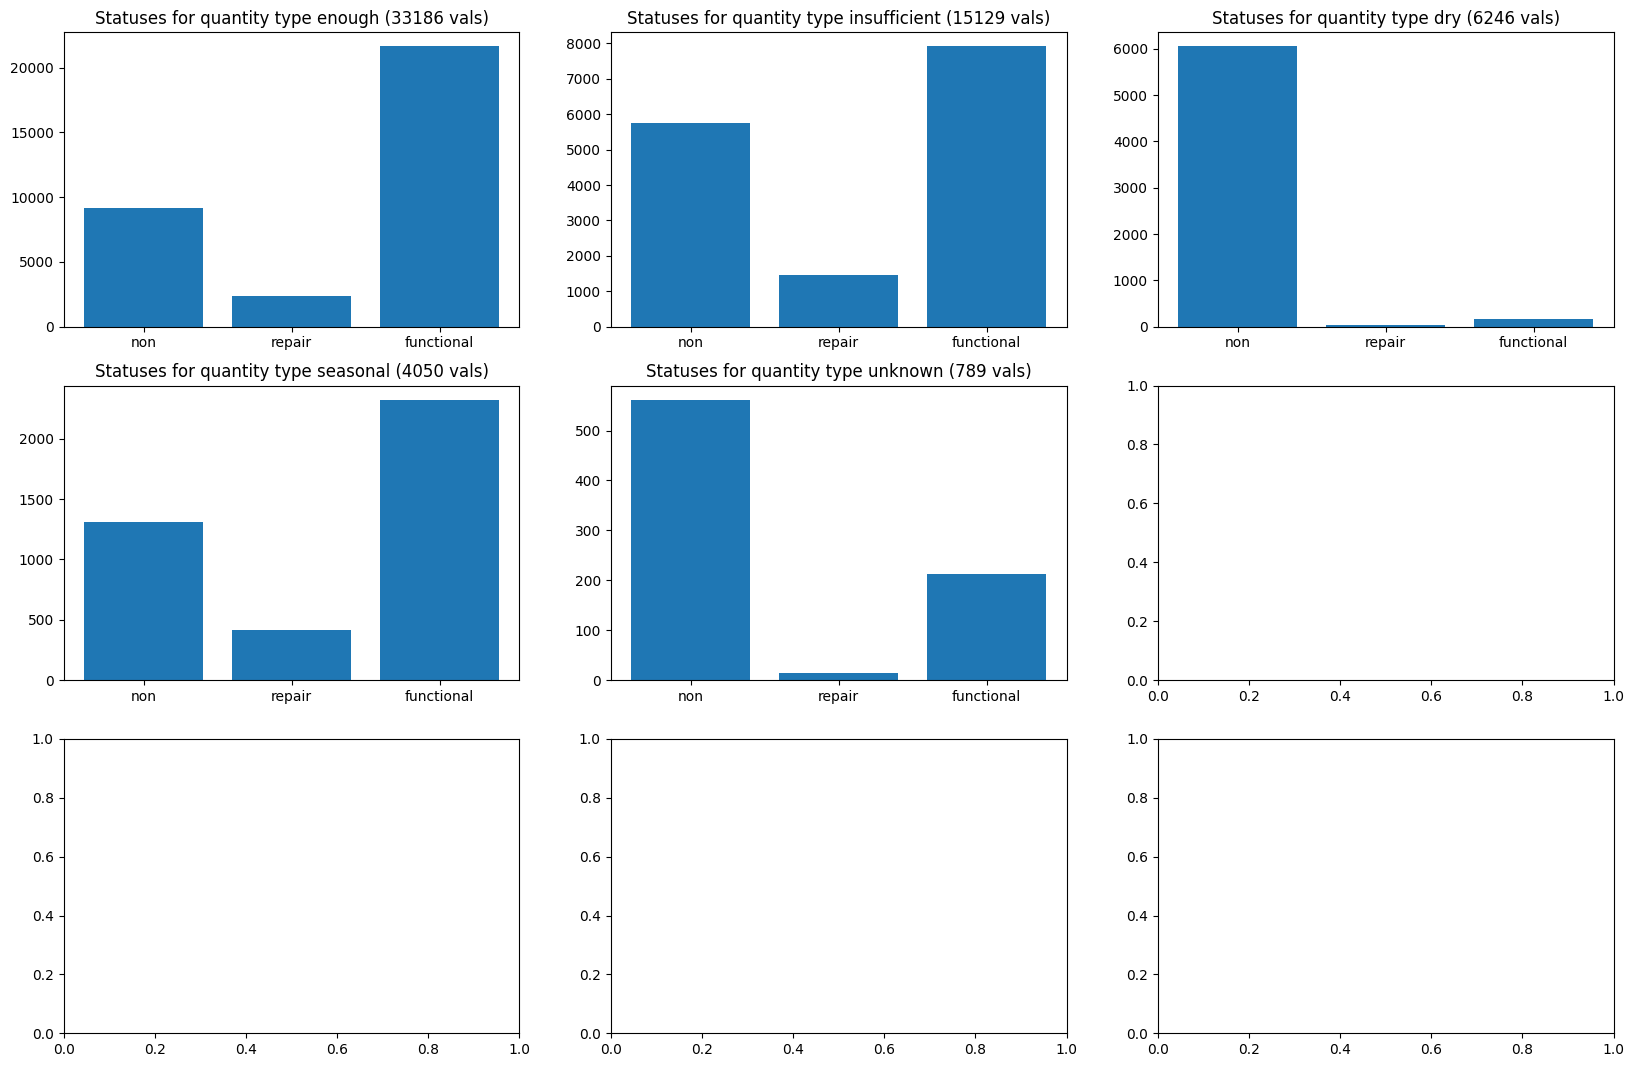

In [85]:
quantities = df.quantity.unique()

fig, axes = plt.subplots(3,3, figsize=(20,13))

for i in range(5):
    
    row = i//3
    col=i%3
    
    copy = df.copy()
    copy = copy[copy.quantity == quantities[i]]
    
    axes[row][col].bar(['non', 'repair', 'functional'], [len(copy[copy.status_group == i]) for i in statuses])
    axes[row][col].set_title("Statuses for quantity type {} ({} vals)".format(quantities[i], len(copy)))

# quantity_group – The quantity of the water

This is a duplicate of the quantity variable.

In [86]:
df.quantity_group.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

# source – the source of the water

In [87]:
df.source.value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

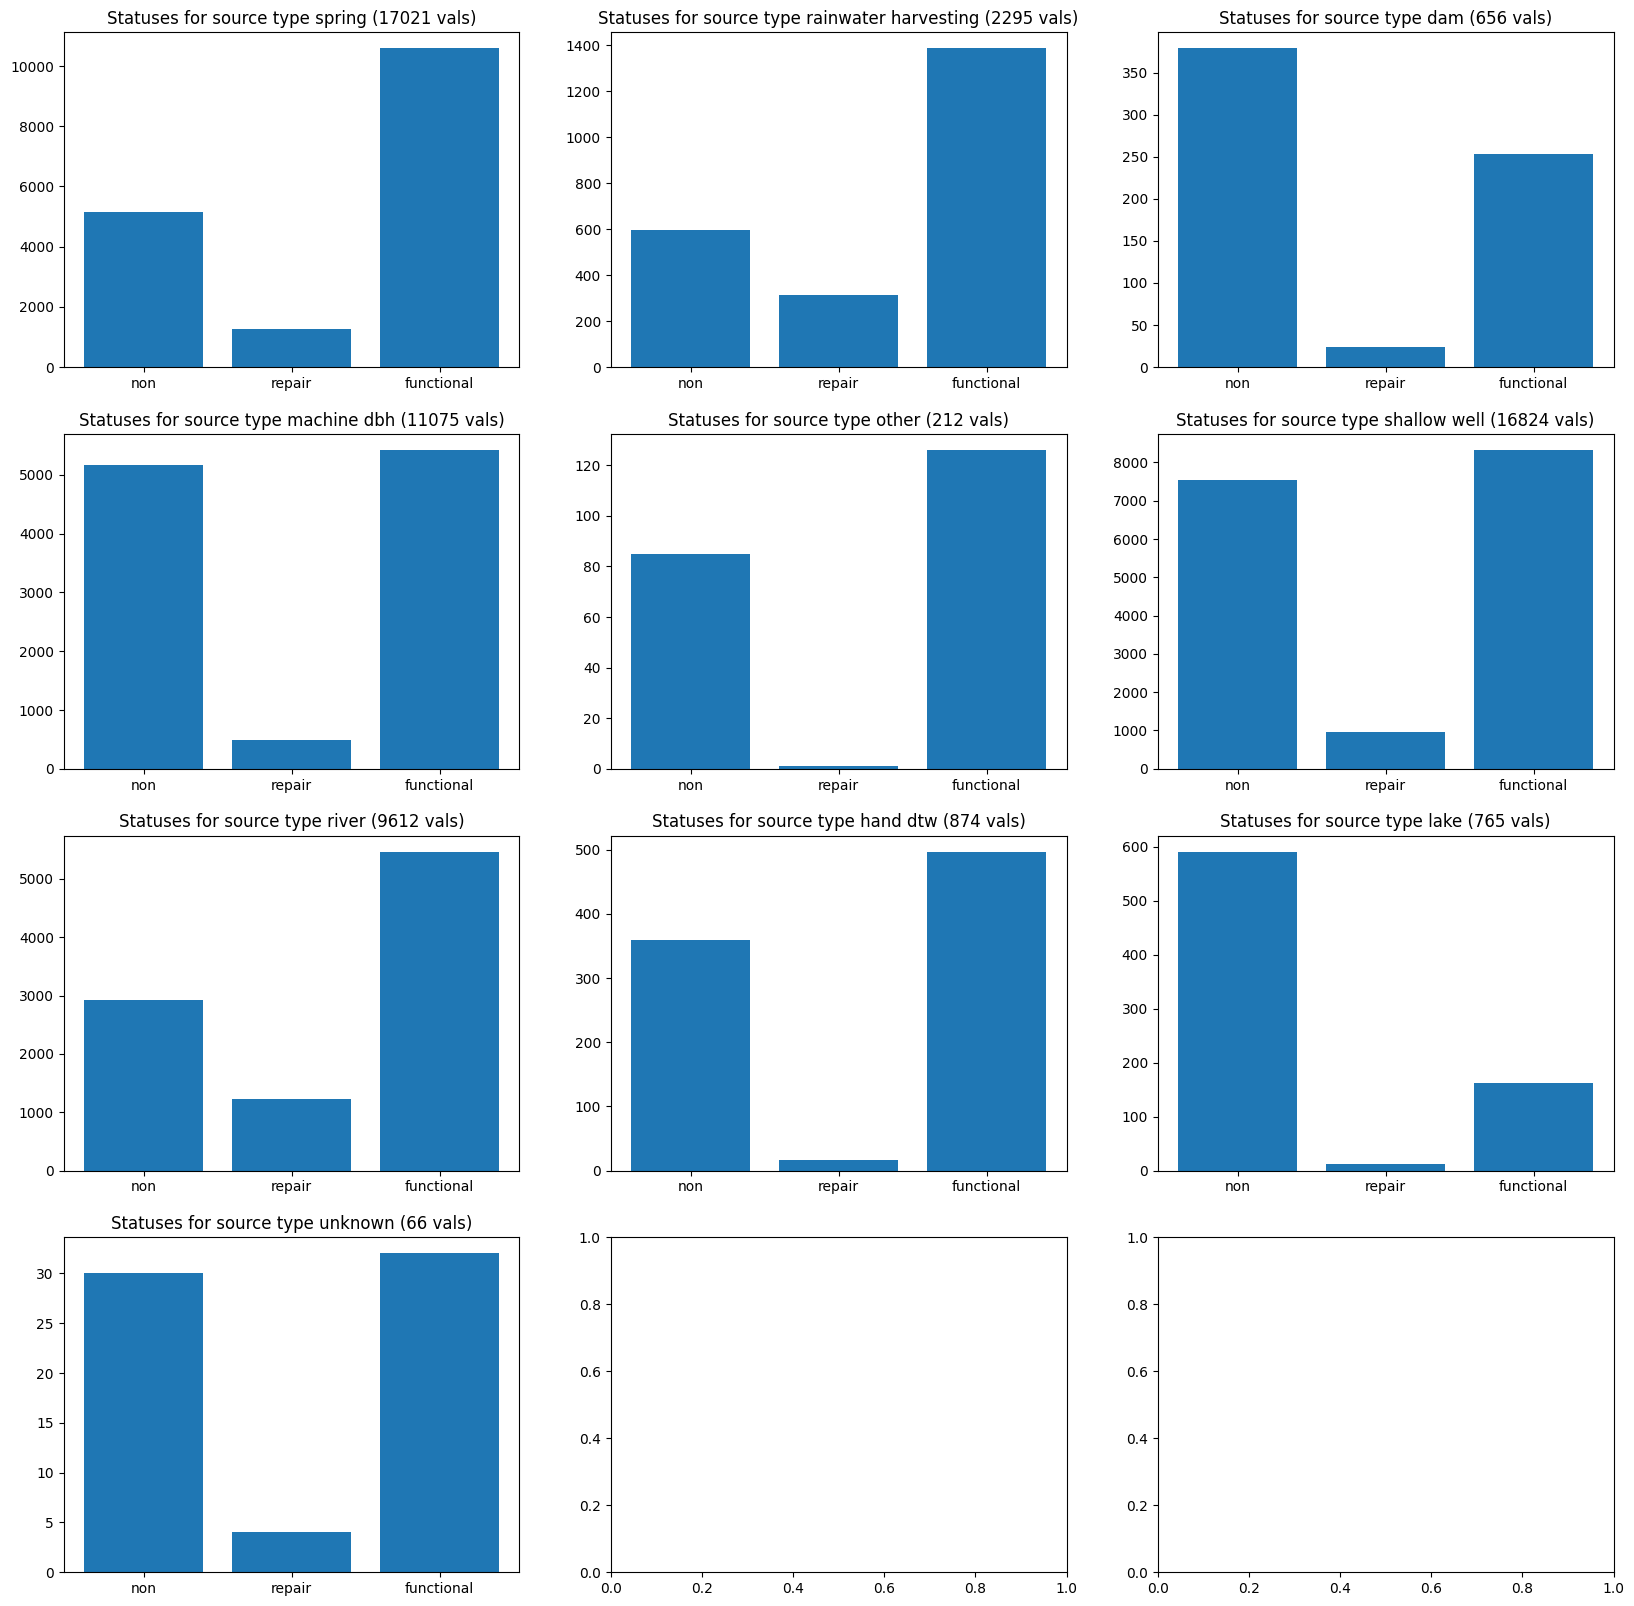

In [88]:
sources = df.source.unique()

fig, axes = plt.subplots(4,3, figsize=(20,20))

for i in range(10):
    
    row = i//3
    col=i%3
    
    copy = df.copy()
    copy = copy[copy.source == sources[i]]
    
    axes[row][col].bar(['non', 'repair', 'functional'], [len(copy[copy.status_group == i]) for i in statuses])
    axes[row][col].set_title("Statuses for source type {} ({} vals)".format(sources[i], len(copy)))

# source_type – the source of the water

Closely related to the source variable, with similar values, but no value with under 100 data points to its credit.

In [89]:
df.source_type.value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

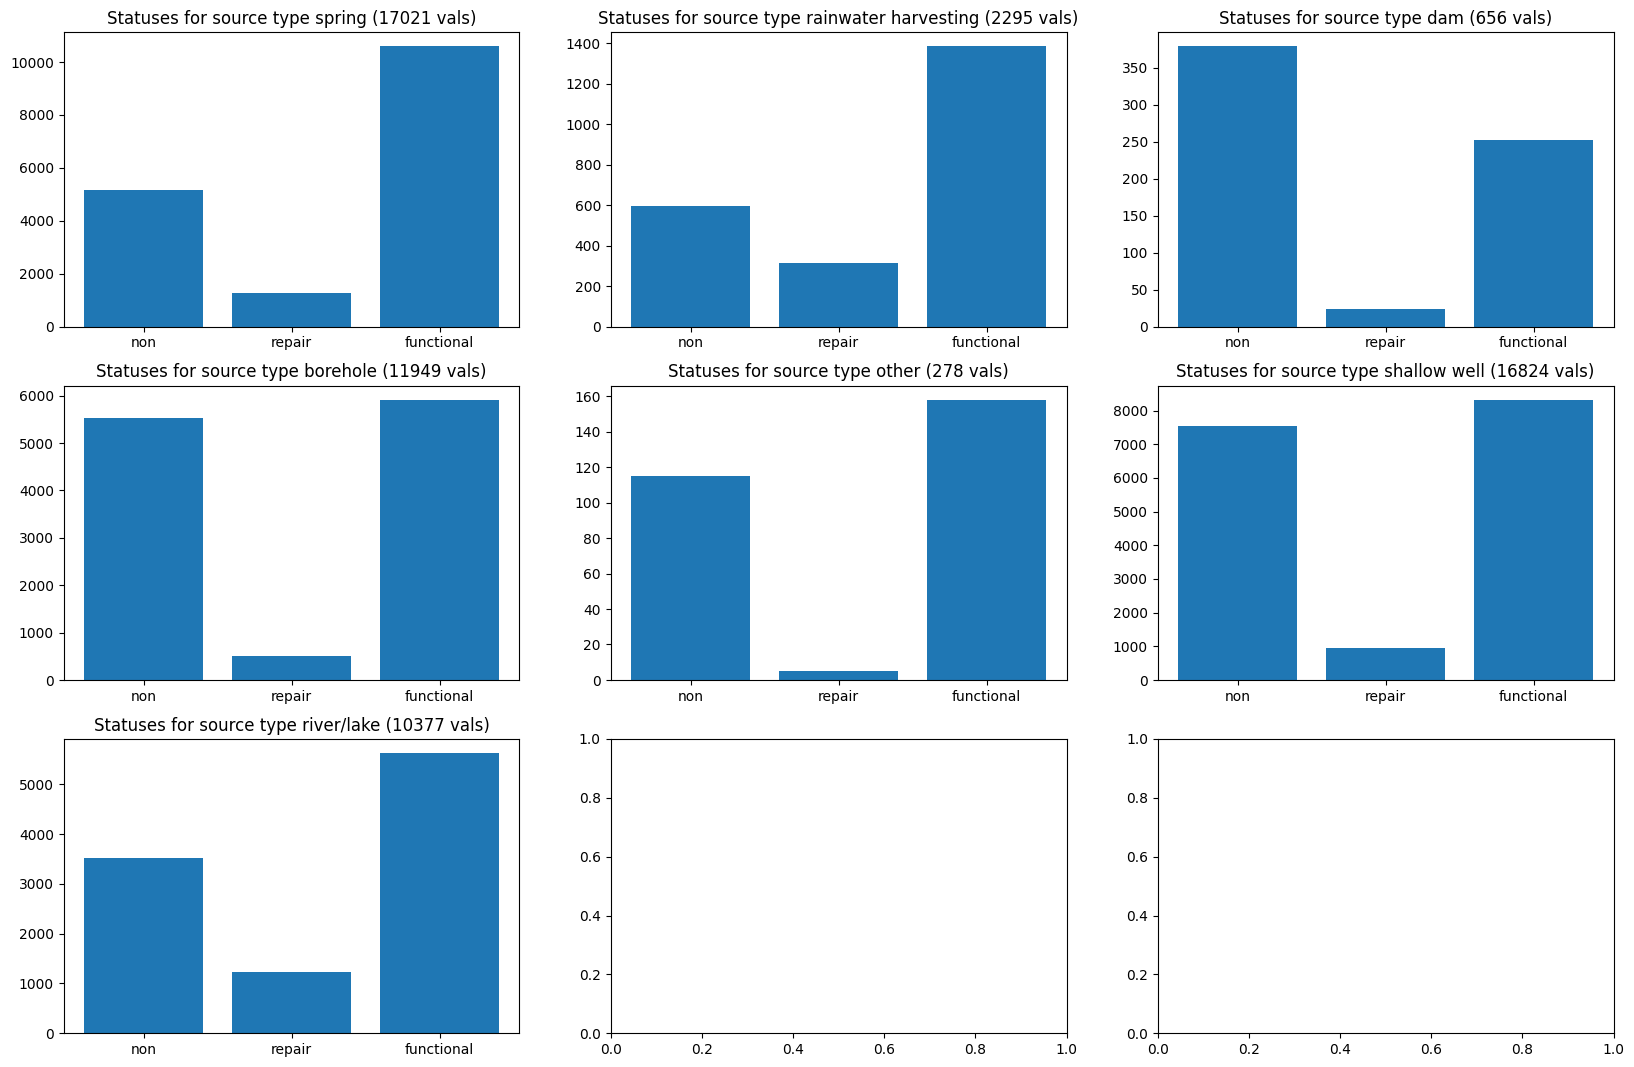

In [90]:
sources = df.source_type.unique()

fig, axes = plt.subplots(3,3, figsize=(20,13))

for i in range(7):
    
    row = i//3
    col=i%3
    
    copy = df.copy()
    copy = copy[copy.source_type == sources[i]]
    
    axes[row][col].bar(['non', 'repair', 'functional'], [len(copy[copy.status_group == i]) for i in statuses])
    axes[row][col].set_title("Statuses for source type {} ({} vals)".format(sources[i], len(copy)))

# source_class – The source of the water

In [91]:
df.source_class.value_counts()

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

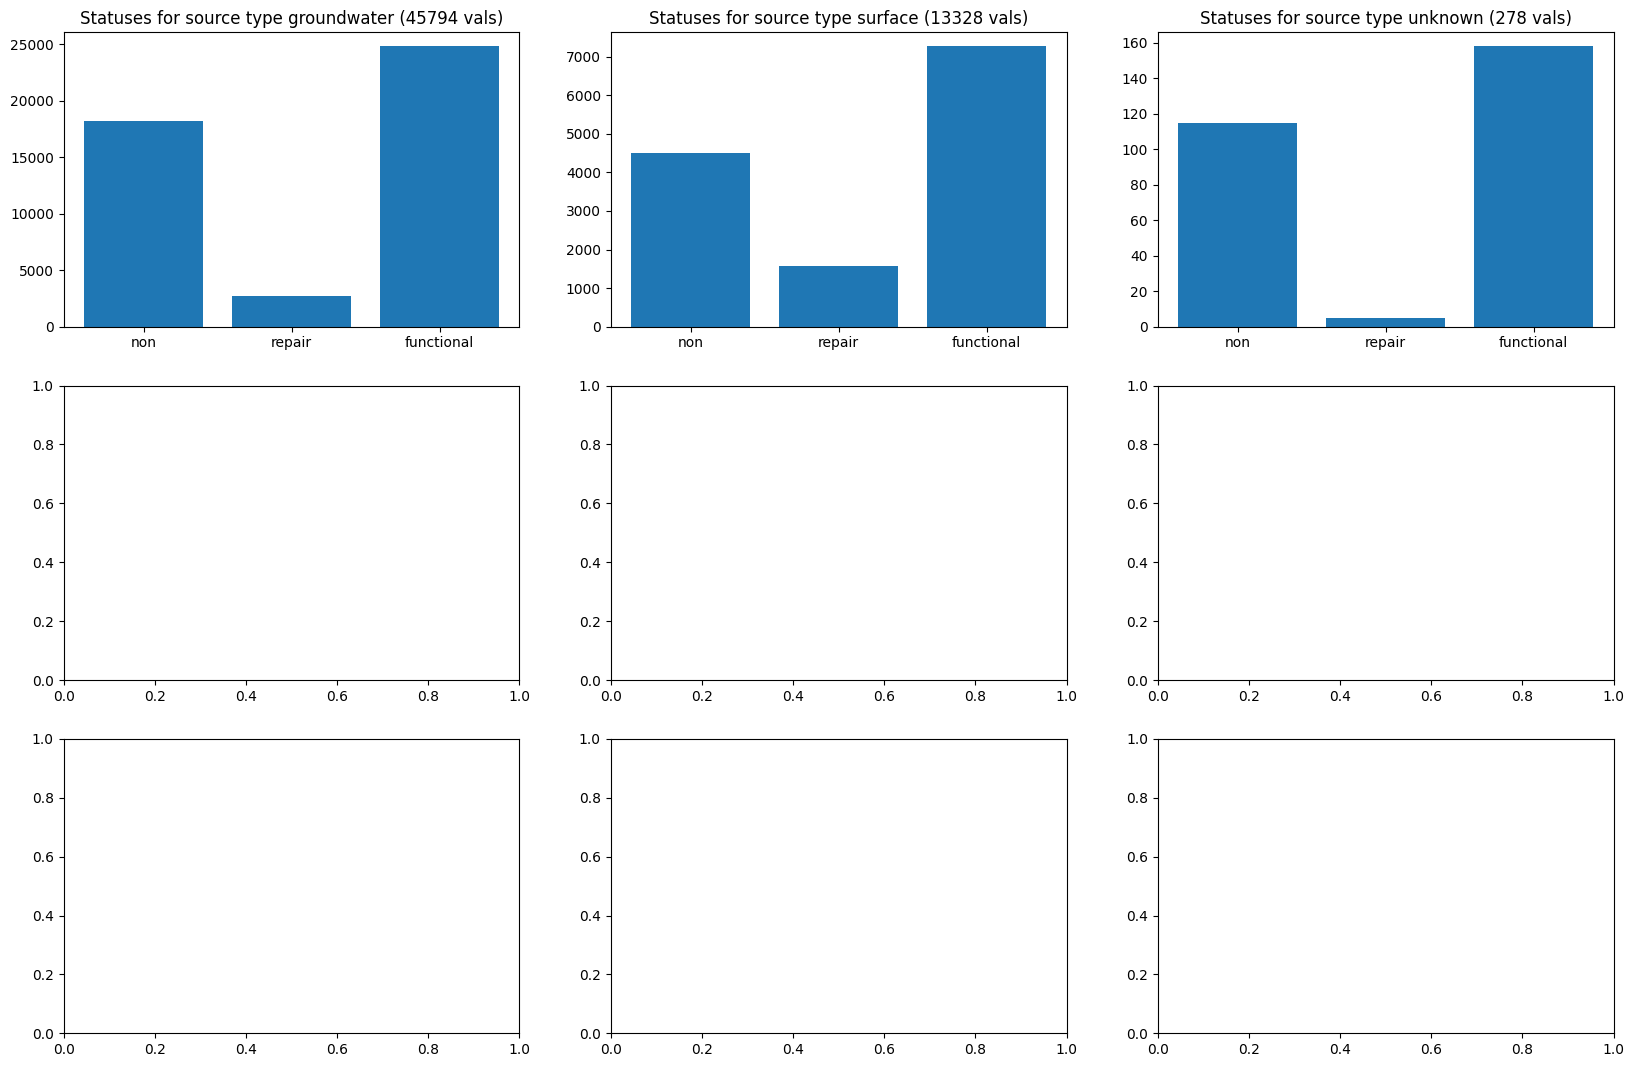

In [92]:
sources = df.source_class.unique()

fig, axes = plt.subplots(3,3, figsize=(20,13))

for i in range(3):
    
    row = i//3
    col=i%3
    
    copy = df.copy()
    copy = copy[copy.source_class == sources[i]]
    
    axes[row][col].bar(['non', 'repair', 'functional'], [len(copy[copy.status_group == i]) for i in statuses])
    axes[row][col].set_title("Statuses for source type {} ({} vals)".format(sources[i], len(copy)))

# waterpoint_type – The kind of waterpoint

Closely related to exraction_type

In [93]:
df.waterpoint_type.value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

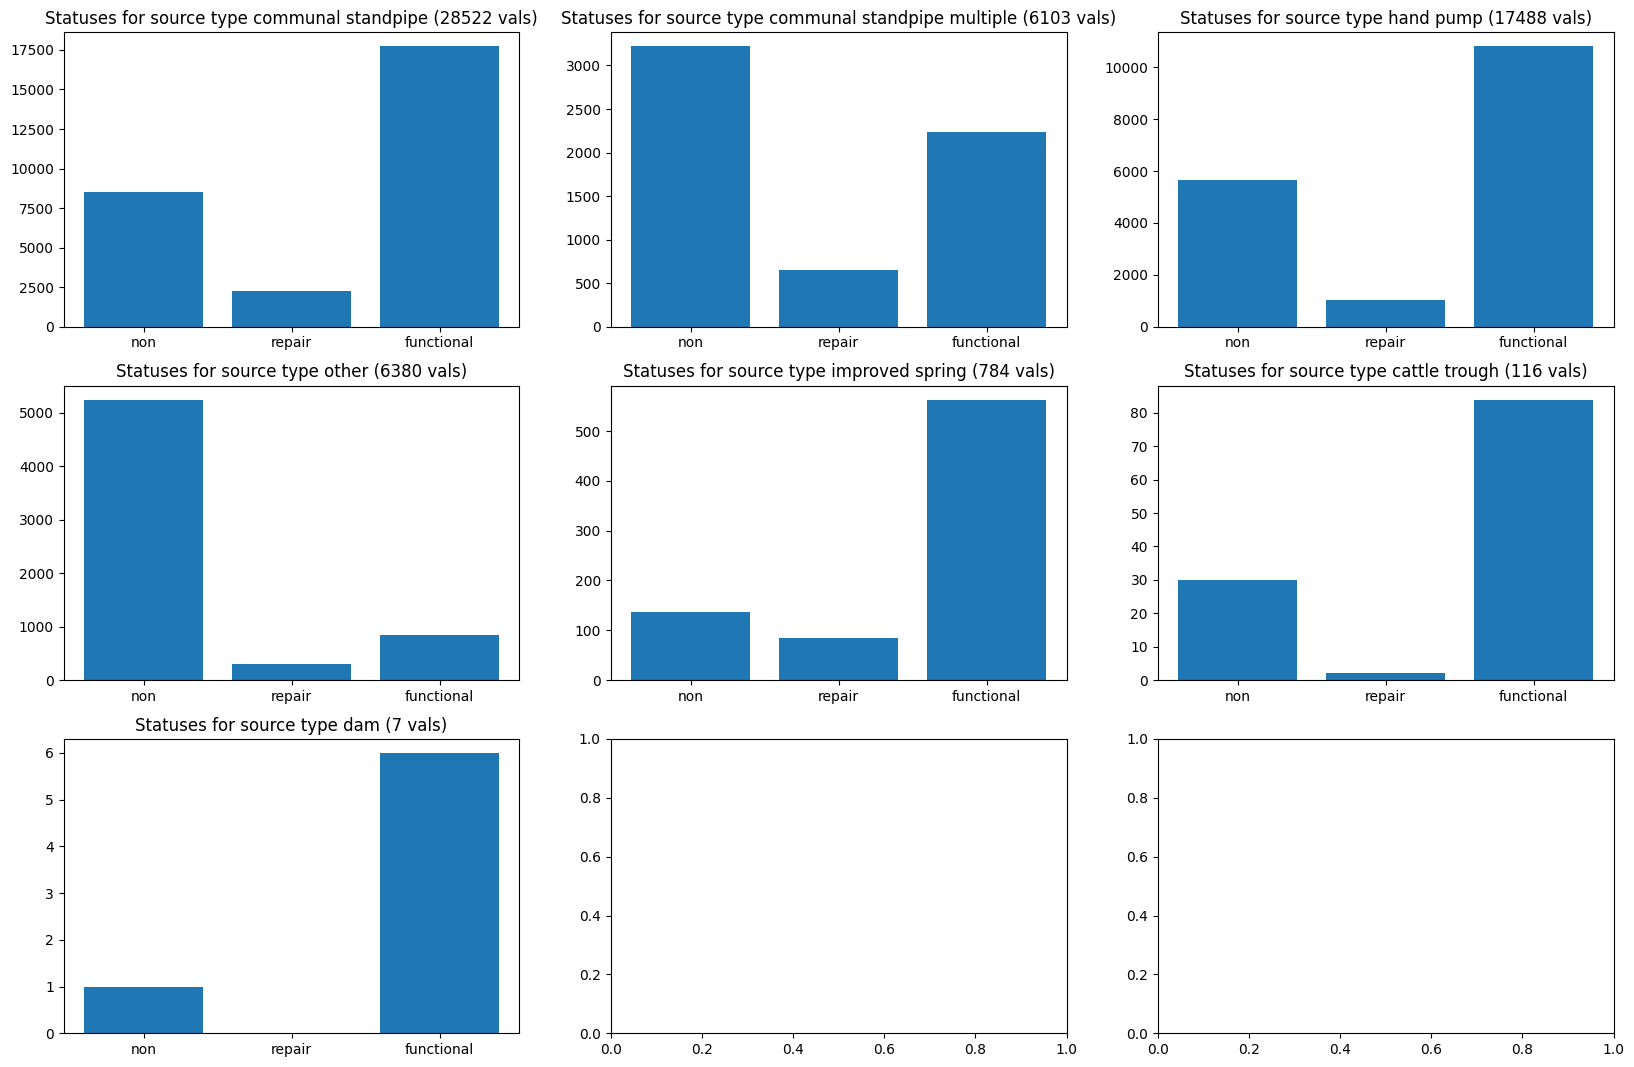

In [94]:
types = df.waterpoint_type.unique()

fig, axes = plt.subplots(3,3, figsize=(20,13))

for i in range(7):
    
    row = i//3
    col=i%3
    
    copy = df.copy()
    copy = copy[copy.waterpoint_type == types[i]]
    
    axes[row][col].bar(['non', 'repair', 'functional'], [len(copy[copy.status_group == i]) for i in statuses])
    axes[row][col].set_title("Statuses for source type {} ({} vals)".format(types[i], len(copy)))

# waterpoint_type_group – The kind of waterpoint

Almost a duplicate of the previous variable.

In [95]:
df.waterpoint_type_group.value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

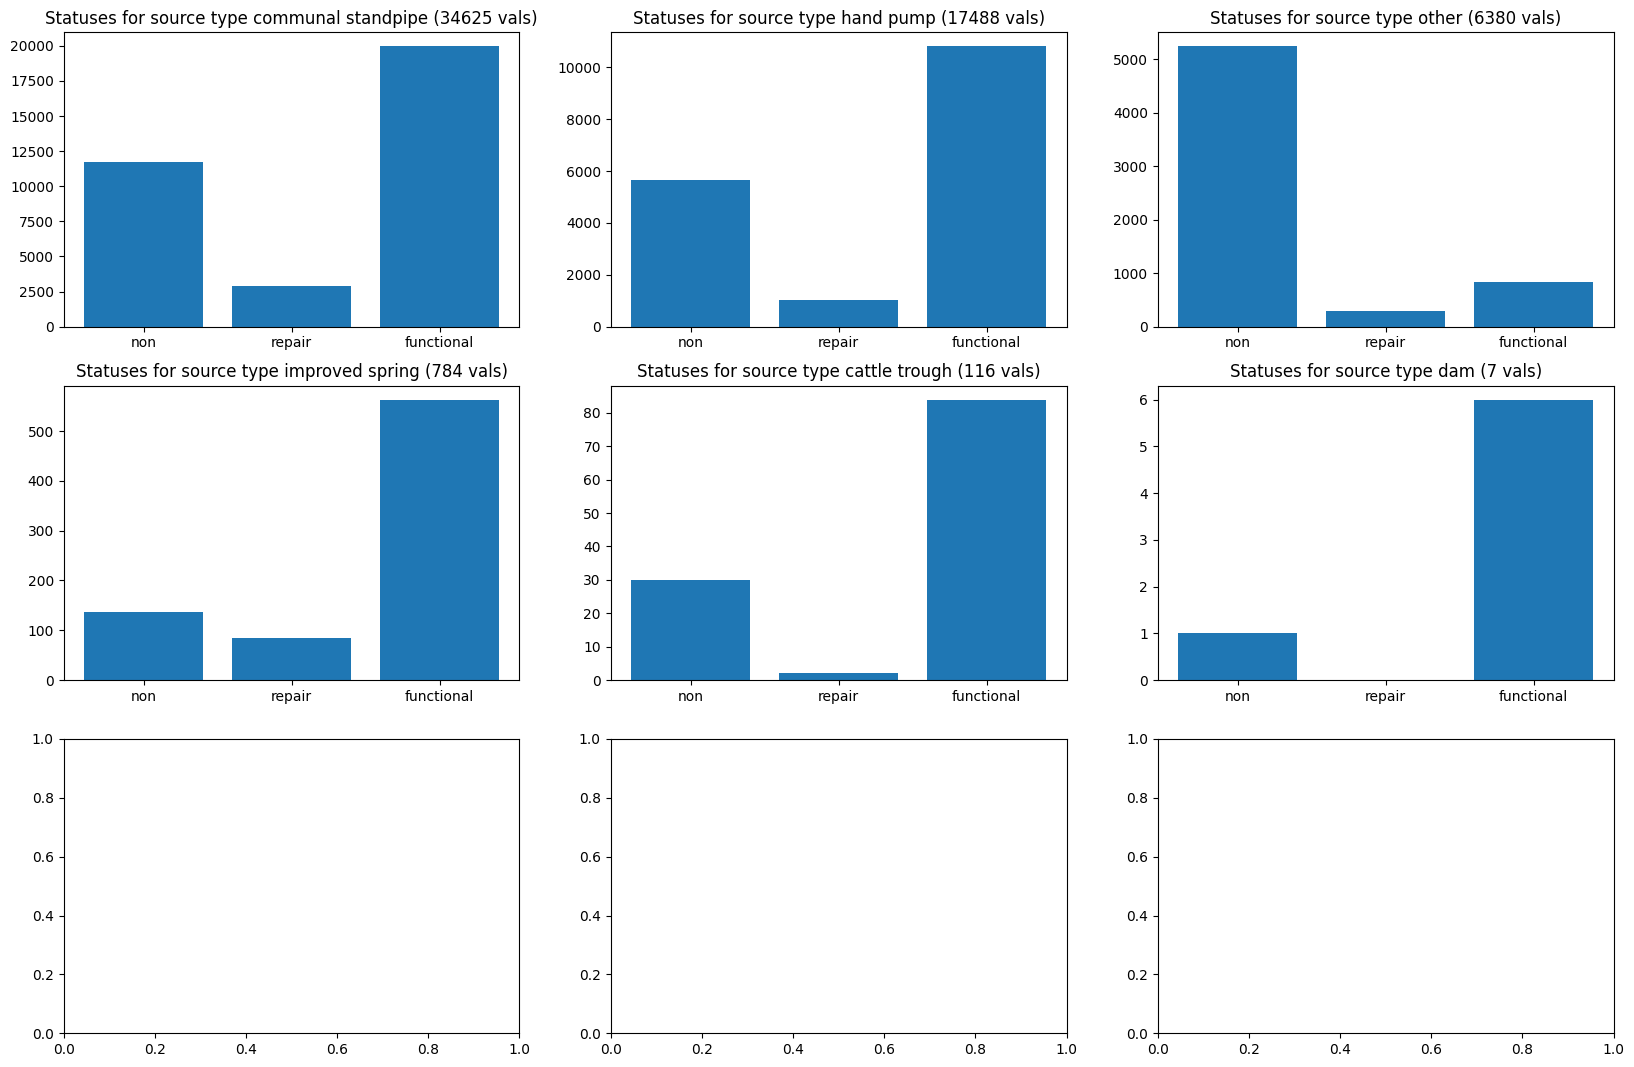

In [96]:
types = df.waterpoint_type_group.unique()

fig, axes = plt.subplots(3,3, figsize=(20,13))

for i in range(6):
    
    row = i//3
    col=i%3
    
    copy = df.copy()
    copy = copy[copy.waterpoint_type_group == types[i]]
    
    axes[row][col].bar(['non', 'repair', 'functional'], [len(copy[copy.status_group == i]) for i in statuses])
    axes[row][col].set_title("Statuses for source type {} ({} vals)".format(types[i], len(copy)))